# Курс Специализация Data Science. Дипломный проект. 
# Бриф «Лаборатории исследований гражданского общества». Определение уязвимых групп населения.

Александр Журавлев
***
***

Нам предоставлены данные о доходах, заболеваемости, социально незащищённых слоях населения России и другие экономические и демографические данные.

# Задача:
- кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;
- описать группы населения, сталкивающиеся с бедностью;
- определить:
    - влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
    - связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
    - какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

**Примечания:**
- Методологии подсчёта некоторых показателей могли меняться за время их наблюдения.
- Не всегда один и тот же регион пишется одинаково в разных датасетах. Такое очень часто происходит с написаниями регионов РФ в разных документах, а также в других странах (их нет в данной задаче). Это необходимо учитывать при объединении датасетов.
- Особенностью Тюменской области является то, что в её состав входят два других субъекта Российской Федерации: Ханты-Мансийский автономный округ — Югра и Ямало-Ненецкий автономный округ. При этом чаще всего в датасетах указывается отдельно Тюменская область и отдельно — без учёта автономных округов.
- То же самое касается Архангельской области — в её состав входит самостоятельный субъект Ненецкий автономный округ. Способы написания такие же, как с Тюменской областью.
- Нежелательно использовать данные по федеральному округу в совокупности. Во-первых, это агрегированные данные, и чаще всего по ним нельзя сделать никаких интересных выводов, а во-вторых, на протяжении последних 20 лет составы федеральных округов менялись (некоторые регионы меняли принадлежность к округу), из-за чего в них мог произойти резкий рост/снижение численности населения, что не отображало какое-то демографическое явление.
***
***

# 1 Этап: сбор, обработка, промежуточный анализ и подготовка данных для проведения кластеризации.

# План решения

- Разведка в интернете: возможно эту задачу уже решали и мы можем оценить это решение, попытаться его улучшить или, как минимум, сравнить результаты. И действительно, одно решение есть: [DKudryavtsev](https://github.com/DKudryavtsev/RussiaRegions/tree/main)
- Загрузим и обработаем предоставленные данные по регионам. Проблемой этих данных прежде всего является то, что по разному пишутся названия регионов, кроме того есть 2 проблемных региона с округами (Архангельская и Тюменская области), а также пропуски в данных за ранние периоды по Крыму и Севастополю. Ну и конечно, в самих данных много пропусков. 
- В качестве словаря со стандартными названиями возьмем готовый словарь [DKudryavtsev](https://github.com/DKudryavtsev/RussiaRegions/tree/main), слегка его подправив под себя (это позволит сэкономить время не набирая вручную названия субъектов)
- Будем стараться, чтобы в датасетах присутствовали Архангельская и Тюменская области, Архангельская и Тюменская области без АО и их отдельные округа. Там где данные отсутствуют, мы будем пытаться их вычислить вручную либо заполним NaN, либо запишем другие цифры - определимся в процессе решения. Скорее всего, данные по целым областям нам не понадобятся и из окончательной общей таблицы мы их удалим, но пока будем пытаться их считать. 
- Закрепим, что термин '*проблемного региона*' мы будем применять именно к Архангельской и Тюменской областям с их округами.
- Контролируем размерность таблиц: должно быть 88 записей (все регионы + общие данные по РФ).
- Контролируем идентичность названий регионов (в разных таблицах можно вручную перевести значения признака *region* в множества и производить их вычитание)
- Если данные представляются за период времени (несколько лет), то будем расчитывать тренд показателей: на повышение, понижение или без направления. Используем для этого скользящую среднюю.
- Если данные представлены в абсолютных числах, то для того, чтобы их сравнивать между регионами, необходимо их как-то привести к "одному знаменателю". Будем их пересчитывать на 100000 (100k) населения, для этого будем использовать данные по численности населения.
- Будем сохранять тренд (если данные представленны за период времени), данные за последний год, отношение показателя региона к показателю по РФ в процентах за последний год.
- Создадим признак "*плохого региона*" (*bad_region*), т.е. регион где показатели сильно хуже, чем в целом по РФ, плохой тренд либо сочетание этих факторов.
- по итогу, (почти)каждая таблица в результате будет содержать 88 записей (все регионы + РФ), и следующие признаки:
    - признак показателя за последний представленный год, 
    - признак тренда за весь представленный период данных (*trend*), 
    - отношения показателя региона за последний год к уровню РФ в целом в % (*per_of_rf*), 
    - метку плохого региона по данному показателю (*bad_region*).
- последний этап: сведение всех таблиц в одну итоговую.

***
***

## 0. Подготовительный этап

### Загрузка необходимых библиотек

In [1]:
# для работы с таблицами
import pandas as pd
# для вычислений и работы с массивами
import numpy as np
# для очистки и преобразования названий регионов
import regex as re
# для глубокого копирования объектов
import copy

# для визуализации
import matplotlib.pyplot as plt

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

# импорт из собственного модуля
from project_module import (
    # функция для стандартизации названий регионов
    get_region_names_standart,
    # функция для 1-го этапа обработки данных:
    # стандартизация названий регионов и вывод общей информации
    data_preparation_step_1,
    # функция для вычисления тренда показателя за представленный период
    get_trend,
    # функция вычисляет тренд, отношения показателей за последний год к уровню РФ,
    # удаляет ненужные для дальнейшей работы данные и выводит информацию
    data_preparation_step_2,
    # функция отмечает ПЛОХИЕ регионы на основе введенных критериев
    data_preparation_step_3,
    # функция выводит распределение значений признака датафрейма в виде гистограммы
    feature_histogram,
    # функция переименовывает признаки итоговой таблицы, используя префикс
    data_features_rename,
    # функция выводит данные по проблемным регионам
    output_problem_regions,
    # функция для пересчета абсолютных показателей на 100000 населения
    index_into_100k_population,
    # словарь стандартизированных названий регионов
    regions_names_standart
    )

***
***

## 1. Загрузка  и обработка предоставленных данных

### 1.1. Население

Данные представляют собой файл формата *.xlsx*, который содержит таблицу:
- **population** - Численность постоянного населения на 1 января за период 1999-2022.

Данные представлены в абсолютных числах, что делает **невозможным их сравнение напрямую между регионами**. Но нам этого и не надо - мы будем использовать для кластеризации данные за последний год и тренд. Кроме того, копия этой таблицы будет использована для расчета абсолютных показателей на 100k населения.

In [2]:
# загружаем данные и производим их первичную очистку
population = pd.read_excel('data_provided/population.xlsx', header=1)
population.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
population.drop('Unnamed: 1', axis=1, inplace=True)

population.head()

,region,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,январь 2007 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
0,все население,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Российская Федерация,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Раздел 1. Муниципальные образования субъектов ...,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,142862692.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
3,Центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Раздел 1. Муниципальные образования субъектов ...,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,38183357.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0


Данные по численности населения в регионах "съехали" на 1 строку вниз, по сравнению с колонкой с названиями регионов. Поправим это.

In [3]:
# сдвигаем данные о численности населения на 1 строку вверх по отношению к названиям регионов
population = pd.concat([population.iloc[:,0], population.iloc[:,1:].shift(periods=-1)], axis=1)

# присваиваем имя таблице
population.name = 'population - Население'


In [4]:
# производим предварительную обработку данных и выводим их
population = data_preparation_step_1(df=population, region='region', replacement='без')

*** Данные после первичной обработки ***
population - Население


,region,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,январь 2007 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
0,РФ,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,142862692.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
1,Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
2,Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
3,Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0
4,Воронежская область,2458558.0,2441337.0,2422371.0,2397111.0,2374461.0,2367457.0,2364932.0,2360912.0,2353805.0,...,2330377.0,2328959.0,2331147.0,2333477.0,2335408.0,2333768.0,2327821.0,2324205.0,2305608.0,2287678.0


Размерность: (94, 25)
Количество строк, содержащих пропуски 10
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,январь 2007 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,1273668.0,1257312.0,1239924.0,1224813.0,...,1159506.0,1148760.0,1139950.0,1130240.0,1121813.0,1111031.0,1100290.0,1092424.0,1082662.0,1069782.0
33,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1895915.0,1907106.0,1912168.0,1913731.0,1911818.0,1912622.0,1901578.0,1896393.0
38,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,398973.0,416263.0,428753.0,436670.0,443212.0,449138.0,509992.0,522057.0
65,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,1317268.0,1311562.0,1308653.0,1309889.0,...,1385008.0,1409426.0,1429232.0,1454626.0,1477903.0,1498779.0,1518695.0,1537416.0,1543389.0,1552148.0
71,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14709.0,14513.0,14407.0,14062.0,13680.0,13330.0,NaN
72,Кировская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,528.0,527.0,529.0,515.0,513.0,501.0,NaN
73,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3220.0,3214.0,3200.0,3191.0,3184.0,3203.0,NaN
74,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,414.0,416.0,412.0,401.0,377.0,358.0,NaN
75,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,838.0,818.0,795.0,774.0,750.0,714.0,NaN
76,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,787.0,769.0,757.0,742.0,749.0,708.0,NaN


----------------------------------------------------------------------------------------------------


Видим дубликаты названий регионов.

In [5]:
# выясним какие регионы дублируются
population.region.value_counts()[:3]

region
Алтайский край       6
Кировская область    2
РФ                   1
Name: count, dtype: int64

In [6]:
# изучим дублирующиеся регионы
mask = (population['region'] == 'Алтайский край') | (population['region'] == 'Кировская область') 
population[mask]

,region,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,январь 2007 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
53,Кировская область,1568722.0,1553595.0,1536772.0,1518378.0,1498976.0,1472481.0,1445356.0,1418645.0,1396017.0,...,1319076.0,1310929.0,1304348.0,1297474.0,1291684.0,1283238.0,1272109.0,1262402.0,1250173.0,1234780.0
70,Алтайский край,2662738.0,2651628.0,2641079.0,2621050.0,2602595.0,2571987.0,2539430.0,2503510.0,2473024.0,...,2398751.0,2390638.0,2384812.0,2376774.0,2365680.0,2350080.0,2332813.0,2317153.0,2296353.0,2268179.0
71,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14709.0,14513.0,14407.0,14062.0,13680.0,13330.0,NaN
72,Кировская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,528.0,527.0,529.0,515.0,513.0,501.0,NaN
73,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3220.0,3214.0,3200.0,3191.0,3184.0,3203.0,NaN
74,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,414.0,416.0,412.0,401.0,377.0,358.0,NaN
75,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,838.0,818.0,795.0,774.0,750.0,714.0,NaN
76,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,787.0,769.0,757.0,742.0,749.0,708.0,NaN


Очевидно, что в данной выборке смысл несут только верхние 2 строки, остальные данные можно удалять.

In [7]:
# удалим ненужные данные
population.drop(labels=[71,72,73,74,75,76], axis=0, inplace=True)

Создадим таблицу population_temp с данными за весь период и **отложим** ее (она будет нужна для пересчета абсолютных показателей на 100k населения).

In [8]:
population_temp = population.copy()

In [9]:
# производим второй этап обработки данных
population = data_preparation_step_2(df=population, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)

*** Данные после второго этапа обработки ***
population - Население


,region,январь 2022 г.,trend,per_of_rf
0,РФ,145557576.0,-1,100.00
1,Белгородская область,1531917.0,1,1.05
2,Брянская область,1168771.0,-1,0.80
3,Владимирская область,1323659.0,-1,0.91
4,Воронежская область,2287678.0,-1,1.57


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,январь 2022 г.,trend,per_of_rf
0,РФ,145557576.0,-1,100.00
2,Брянская область,1168771.0,-1,0.80
3,Владимирская область,1323659.0,-1,0.91
4,Воронежская область,2287678.0,-1,1.57
5,Ивановская область,976918.0,-1,0.67
...,...,...,...,...
89,Амурская область,772525.0,-1,0.53
90,Магаданская область,137767.0,-1,0.09
91,Сахалинская область,484177.0,-1,0.33
92,Еврейская автономная область,153831.0,-1,0.11


----------------------------------------------------------------------------------------------------


Итак, мы видим, что в 61 регионе и РФ в целом отмечается убыль населения.    
Сделаем следующее:
- сохраним в таблице данные за 2022 год,тренд и признак *per_of_rf* 
- отметим в качестве ПЛОХИХ регионов (bad_region) регионы с отрицательным трендом по численности населения

In [10]:
# отмечаем проблемные регионы
population['bad_region'] = population['trend'].apply(lambda x: 1 if x == -1 else 0)

print(population.name)
print("* 'ПЛОХИЕ' регионы *")
display(population[population['bad_region'] == 1])

population - Население
* 'ПЛОХИЕ' регионы *


,region,январь 2022 г.,trend,per_of_rf,bad_region
0,РФ,145557576.0,-1,100.00,1
2,Брянская область,1168771.0,-1,0.80,1
3,Владимирская область,1323659.0,-1,0.91,1
4,Воронежская область,2287678.0,-1,1.57,1
5,Ивановская область,976918.0,-1,0.67,1
...,...,...,...,...,...
89,Амурская область,772525.0,-1,0.53,1
90,Магаданская область,137767.0,-1,0.09,1
91,Сахалинская область,484177.0,-1,0.33,1
92,Еврейская автономная область,153831.0,-1,0.11,1


Теперь подправим названия признаков, используя префикс.

In [11]:
# правим названия признаков
data_features_rename(df=population, prefix='population')

population - Население
Размерность данных: (88, 5)


,region,population,population_trend,population_per_of_rf,population_bad_region
0,РФ,145557576.0,-1,100.00,1
1,Белгородская область,1531917.0,1,1.05,0
2,Брянская область,1168771.0,-1,0.80,1
3,Владимирская область,1323659.0,-1,0.91,1
4,Воронежская область,2287678.0,-1,1.57,1


**Примечание:** здесь и ниже, если суммировать абсолютные показатели регионов (например, в таблице населения выше), то чтобы итоговая цифра по РФ совпала с табличной, необходимо вычесть из общей суммы данные Архангельской и Тюменской областей (т.к. в таблице будут присутствовать эти данные по областям без АО и отдельно по их АО).

***

### 1.2. Данные по доходам населения 

Данные **cash_real_income_wages_2015_2020** представляют собой файл формата *.xlsx* и содержит следующие таблицы:
- **per_capita_cash_income** - Среднедушевые денежные доходы (в месяц), руб.
- **real_incomes** - Реальные денежные доходы, в процентах к предыдущему году
- **formal_wage_paid** - Среднемесячная номинальная начисленная заработная плата, руб.
- **real_pay** - Реальная начисленная заработная плата, в процентах к предыдущему году

In [12]:
# загружаем данные
per_capita_cash_income = pd.read_excel(io='data_provided/cash_real_income_wages_2015_2020.xlsx', sheet_name=0)
real_incomes = pd.read_excel(io='data_provided/cash_real_income_wages_2015_2020.xlsx', sheet_name=1)
formal_wage_paid = pd.read_excel(io='data_provided/cash_real_income_wages_2015_2020.xlsx', sheet_name=2)
real_pay = pd.read_excel(io='data_provided/cash_real_income_wages_2015_2020.xlsx', sheet_name=3)

# присваиваем имена таблицам
per_capita_cash_income.name = 'per_capita_cash_income - Среднедушевые денежные доходы (в месяц), руб.'
real_incomes.name = 'real_incomes - Реальные денежные доходы, в процентах к предыдущему году'
formal_wage_paid.name = 'formal_wage_paid - Среднемесячная номинальная начисленная заработная плата, руб.'
real_pay.name = 'real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году'

# производим предварительную обработку данных и выводим их
per_capita_cash_income = data_preparation_step_1(df=per_capita_cash_income, region='region', replacement='')
real_incomes = data_preparation_step_1(df=real_incomes, region='region', replacement='')
formal_wage_paid = data_preparation_step_1(df=formal_wage_paid, region='region', replacement='')
real_pay = data_preparation_step_1(df=real_pay, region='region', replacement='')

*** Данные после первичной обработки ***
per_capita_cash_income - Среднедушевые денежные доходы (в месяц), руб.


,region,2015,2016,2017,2018,2019,2020
0,РФ,302541.0,30865.0,31897.0,33266.0,35338.0,36073.0
1,Белгородская область,28043.0,29799.0,30342.0,30778.0,32352.0,32841.0
2,Брянская область,23428.0,24006.0,25107.0,26585.0,28371.0,28596.0
3,Владимирская область,22712.0,22365.0,23554.0,23539.0,25358.0,25922.0
4,Воронежская область,29366.0,29284.0,29498.0,30289.0,32022.0,32078.0


Размерность: (88, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
real_incomes - Реальные денежные доходы, в процентах к предыдущему году


,region,2015,2016,2017,2018,2019,2020
0,РФ,96.42,95.5,99.8,101.4,101.7,98.6
1,Белгородская область,99.30,100.8,99.1,98.7,100.6,98.1
2,Брянская область,97.00,95.0,99.4,102.1,100.5,96.3
3,Владимирская область,99.50,92.2,100.9,96.4,101.9,98.0
4,Воронежская область,101.10,93.6,97.4,100.0,101.1,95.4


Размерность: (88, 7)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2015,2016,2017,2018,2019,2020
33,Республика Крым,NaN,102.1,106.4,105.9,99.0,99.5
38,Севастополь,NaN,139.3,104.1,101.4,101.2,102.9


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
formal_wage_paid - Среднемесячная номинальная начисленная заработная плата, руб.


,region,2015,2016,2017,2018,2019,2020
0,РФ,34030.0,36709.0,39167.0,43724.0,47867.0,51344.0
1,Белгородская область,25456.0,27091.0,29066.0,31852.0,34615.0,37442.0
2,Брянская область,21679.0,22923.0,24743.0,27251.0,29853.0,31946.0
3,Владимирская область,23877.0,25135.0,26975.0,30460.0,33076.0,35240.0
4,Воронежская область,24906.0,26335.0,28007.0,31207.0,33690.0,36317.0


Размерность: (88, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году


,region,2015,2016,2017,2018,2019,2020
0,РФ,91.01,100.8,102.9,108.5,104.8,103.8
1,Белгородская область,93.20,100.8,104.5,106.8,104.0,104.8
2,Брянская область,89.00,98.5,103.2,107.0,104.0,102.9
3,Владимирская область,91.00,99.2,103.6,109.9,103.5,103.0
4,Воронежская область,89.10,99.1,102.8,108.7,103.4,103.2


Размерность: (88, 7)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2015,2016,2017,2018,2019,2020
33,Республика Крым,NaN,96.2,103.6,110.5,105.3,101.5
38,Севастополь,NaN,101.1,108.1,111.8,103.5,101.3


----------------------------------------------------------------------------------------------------


Теперь в представленных данных расчитаем тренд (признак *trend*, значение 1 - возрастающий тренд, 0 - без направления, -1 - убывающий) показателей за указанный период (используем скользящую среднюю), оставим показатели только за последний представленный год и сравним их в процентном соотношении с показателями в целом по РФ (признак *per_of_rf*).

In [13]:
# производим второй этап обработки данных и выводим их
per_capita_cash_income = data_preparation_step_2(df=per_capita_cash_income, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)
real_incomes = data_preparation_step_2(df=real_incomes, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)
formal_wage_paid = data_preparation_step_2(df=formal_wage_paid, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)
real_pay = data_preparation_step_2(df=real_pay, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)

*** Данные после второго этапа обработки ***
per_capita_cash_income - Среднедушевые денежные доходы (в месяц), руб.


,region,2020,trend,per_of_rf
0,РФ,36073.0,1,100.00
1,Белгородская область,32841.0,1,91.04
2,Брянская область,28596.0,1,79.27
3,Владимирская область,25922.0,1,71.86
4,Воронежская область,32078.0,1,88.93


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 68 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
real_incomes - Реальные денежные доходы, в процентах к предыдущему году


,region,2020,trend,per_of_rf
0,РФ,98.6,1,100.00
1,Белгородская область,98.1,-1,99.49
2,Брянская область,96.3,1,97.67
3,Владимирская область,98.0,1,99.39
4,Воронежская область,95.4,1,96.75


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
1,Белгородская область,98.1,-1,99.49
5,Ивановская область,97.2,-1,98.58
7,Костромская область,97.3,-1,98.68
9,Липецкая область,94.9,-1,96.25
10,Московская область,97.8,-1,99.19
14,Тамбовская область,94.3,-1,95.64
26,Ленинградская область,100.8,-1,102.23
31,Республика Адыгея,101.4,-1,102.84
33,Республика Крым,99.5,-1,100.91
38,Севастополь,102.9,-1,104.36


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 40 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf
1,Белгородская область,98.1,-1,99.49
5,Ивановская область,97.2,-1,98.58
7,Костромская область,97.3,-1,98.68
9,Липецкая область,94.9,-1,96.25
10,Московская область,97.8,-1,99.19
14,Тамбовская область,94.3,-1,95.64
43,Республика Северная Осетия-Алания,94.6,-1,95.94
46,Республика Башкортостан,95.1,-1,96.45
61,Свердловская область,92.5,-1,93.81


Всего таких регионов: 9 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
formal_wage_paid - Среднемесячная номинальная начисленная заработная плата, руб.


,region,2020,trend,per_of_rf
0,РФ,51344.0,1,100.00
1,Белгородская область,37442.0,1,72.92
2,Брянская область,31946.0,1,62.22
3,Владимирская область,35240.0,1,68.64
4,Воронежская область,36317.0,1,70.73


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 67 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году


,region,2020,trend,per_of_rf
0,РФ,103.8,1,100.00
1,Белгородская область,104.8,1,100.96
2,Брянская область,102.9,1,99.13
3,Владимирская область,103.0,1,99.23
4,Воронежская область,103.2,1,99.42


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
30,Санкт-Петербург,101.0,-1,97.30
50,Удмуртская Республика,103.4,-1,99.61
56,Пензенская область,102.9,-1,99.13


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 53 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf
30,Санкт-Петербург,101.0,-1,97.30
50,Удмуртская Республика,103.4,-1,99.61
56,Пензенская область,102.9,-1,99.13


Всего таких регионов: 3 *
----------------------------------------------------------------------------------------------------


**Выводы:**
- *Среднемесячная номинальная начисленная заработная плата* и *Среднедушевые денежные доходы (в месяц)* не могут отражать реальное финансовое благополучие региона: это будет зависеть от цен на товары и услуги в данном регионе, сколько денег уходит на квартплату, сколько стоит жилье и т.д.
- Кроме того, мы видим, что в указанных выше данных отсутствует отрицательный тренд, т.е. *Среднемесячная номинальная начисленная заработная плата* и *Среднедушевые денежные доходы (в месяц)* не падают, что ЯКОБЫ говорит о благополучии, но на самом деле нет.
- Однако, по этим же показателям в 68 и 67 регионах соответственно, эти показатели ниже уровня по РФ в целом.
- Честно говоря, не вижу смысла в использовании этих 2-х таблиц в кластеризации. Пока **отложим** их.
- В данных по реальным доходам (*Реальные денежные доходы, в процентах к предыдущему году* и *Реальная начисленная заработная плата, в процентах к предыдущему году*) мы видим пропуски в регонах Крым и Севастополь, что логично, т.к. данных по предыдущему году нет по понятным причинам.
- В данных по реальным доходам мы уже видим отрицательный тренд по показателям в некоторых регионах и даже регионы, где есть отрицательный тренд и уровень показателей за последний представленный год ниже уровня в целом по РФ.

Далее работаем с данными только по реальным доходам и зарплатам. Выведем распределение признака *per_of_rf* в обеих таблицах, это поможет нам определить какие еще регионы можно отнести к "плохим".

real_incomes - Реальные денежные доходы, в процентах к предыдущему году


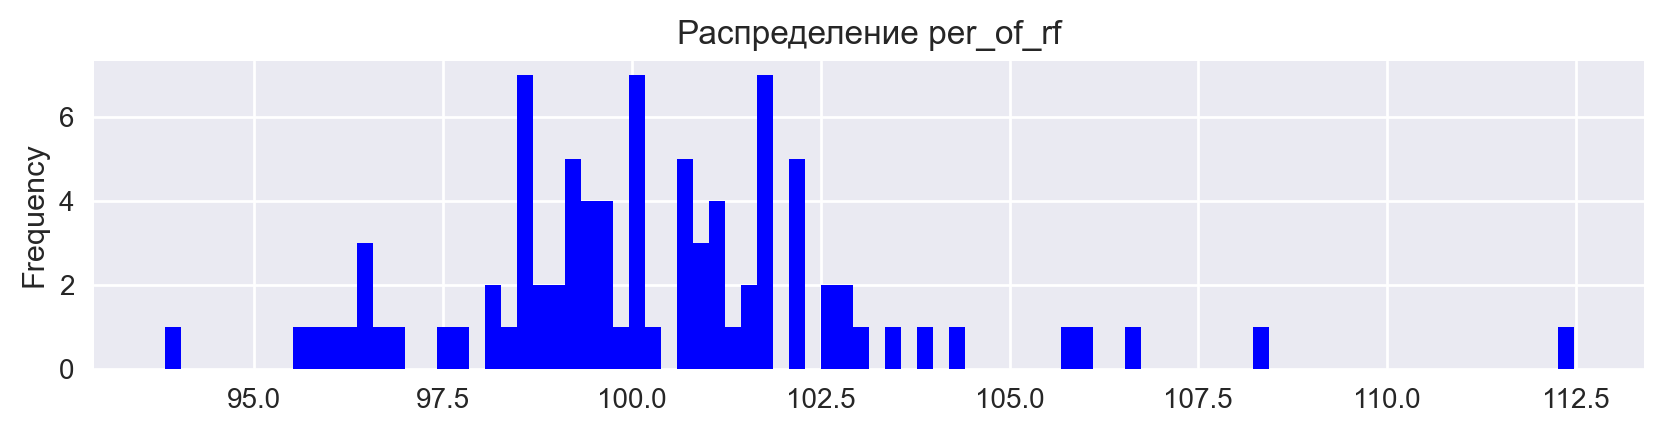

In [14]:
# выведем распределние признака per_of_rf в данных real_incomes
feature_histogram(df=real_incomes, feature='per_of_rf')

real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году


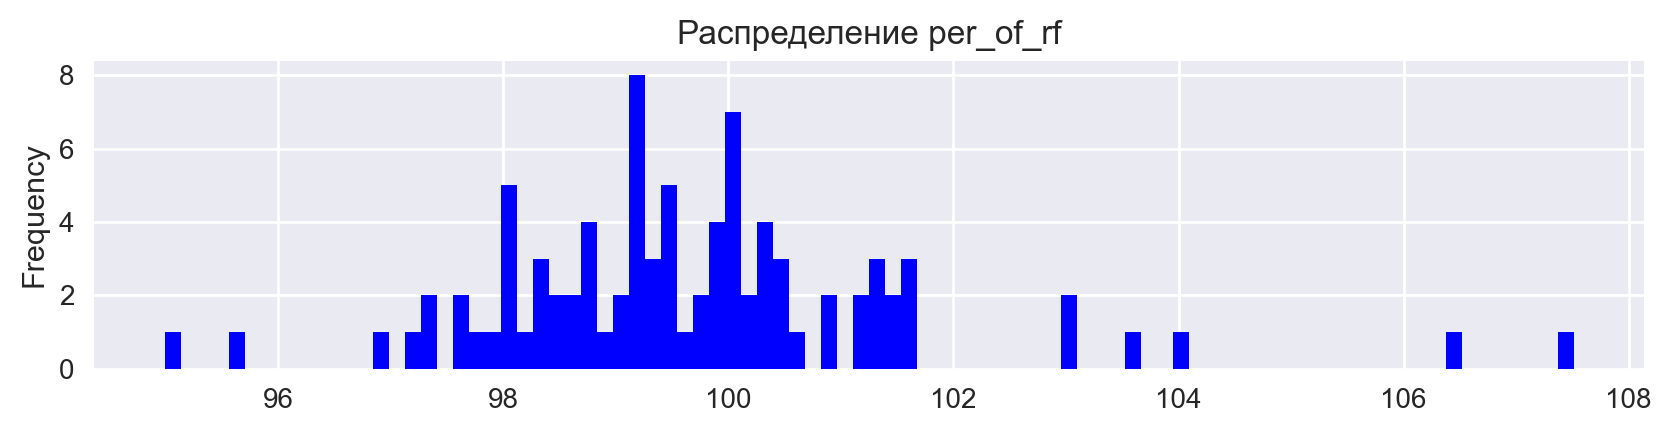

In [15]:
# выведем распределние признака per_of_rf в данных real_pay
feature_histogram(df=real_pay, feature='per_of_rf')

Теперь в таблицах с реальными доходами и зарплатами пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- отрицательный тренд в данных + уровень показателей за последний год ниже уровня по РФ (т.е. менее 100%)
- а также отношение показателей за последний год к показателям РФ ниже 97 процентов в обеих таблицах

In [16]:
# отмечаем ПЛОХИЕ регионы
real_incomes = data_preparation_step_3(real_incomes, bad_trend=-1, bad_per_of_rf='less', and_threshold=100, add_threshold=97)
real_pay = data_preparation_step_3(real_pay, bad_trend=-1, bad_per_of_rf='less', and_threshold=100, add_threshold=97)

real_incomes - Реальные денежные доходы, в процентах к предыдущему году
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
1,Белгородская область,98.1,-1,99.49,1
4,Воронежская область,95.4,1,96.75,1
5,Ивановская область,97.2,-1,98.58,1
7,Костромская область,97.3,-1,98.68,1
9,Липецкая область,94.9,-1,96.25,1
10,Московская область,97.8,-1,99.19,1
14,Тамбовская область,94.3,-1,95.64,1
43,Республика Северная Осетия-Алания,94.6,-1,95.94,1
45,Ставропольский край,94.5,1,95.84,1
46,Республика Башкортостан,95.1,-1,96.45,1


* Всего 'ПЛОХИХ' регионов: 14 *
----------------------------------------------------------------------------------------------------
real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
7,Костромская область,98.6,1,94.99,1
25,Калининградская область,99.2,1,95.57,1
30,Санкт-Петербург,101.0,-1,97.30,1
50,Удмуртская Республика,103.4,-1,99.61,1
56,Пензенская область,102.9,-1,99.13,1
73,Кемеровская область,100.6,1,96.92,1


* Всего 'ПЛОХИХ' регионов: 6 *
----------------------------------------------------------------------------------------------------


Теперь подправим названия признаков в таблицах, используя префикс.

In [17]:
# правим названия признаков и выводим первые пять строк обновленных таблиц
data_features_rename(df=real_incomes, prefix='real_incomes')
data_features_rename(df=real_pay, prefix='real_pay')

real_incomes - Реальные денежные доходы, в процентах к предыдущему году
Размерность данных: (88, 5)


,region,real_incomes,real_incomes_trend,real_incomes_per_of_rf,real_incomes_bad_region
0,РФ,98.6,1,100.00,0
1,Белгородская область,98.1,-1,99.49,1
2,Брянская область,96.3,1,97.67,0
3,Владимирская область,98.0,1,99.39,0
4,Воронежская область,95.4,1,96.75,1


real_pay - Реальная начисленная заработная плата, в процентах к предыдущему году
Размерность данных: (88, 5)


,region,real_pay,real_pay_trend,real_pay_per_of_rf,real_pay_bad_region
0,РФ,103.8,1,100.00,0
1,Белгородская область,104.8,1,100.96,0
2,Брянская область,102.9,1,99.13,0
3,Владимирская область,103.0,1,99.23,0
4,Воронежская область,103.2,1,99.42,0


***

### 1.3. Доля населения с доходом ниже 40% от медианного

Это дополнительные официальные данные Росстата, взятые мной [отсюда](https://rosstat.gov.ru/storage/mediabank/tab1-2-10.xlsx).    
Они представляют собой файл *.xlsx*, который содержит таблицы с информацией о доли населения, имеющего среднедушевые денежные доходы ниже границы медианного среднедушевого денежного дохода населения за период 2013-2022 по уровням 40-50-60%. Нас интересуют данные по уровням ниже 40%, т.к. это будут люди гарантированно находящиеся ниже черты бедности, т.к. с 2021 года прожиточный минимум рассчитывается как 44.2 % от медианного дохода граждан РФ за прошлый год

**Примечание:** конечно мы не можем говорить, что из данной таблицы мы можем получить долю людей ниже черты бедности по новой методике расчета: мы используем порог 40%, а не 44.2% и данные за текущий год, а не прошлый. Но, на мой взгляд, эти данные будут полезны, т.к. позволяют выделить долю населения с минимальными доходами. 

In [18]:
# загружаем данные
for n in range(1,11):
    if n==1:
        poor = pd.read_excel(io='data_provided/tab1-2-10.xlsx', sheet_name=n, header=2, skipfooter=3, usecols='A,B')
        poor.rename(columns={'Unnamed: 0':'region', 0.4:2013}, inplace=True)
    else:
        poor = pd.concat([poor, pd.read_excel(io='data_provided/tab1-2-10.xlsx', sheet_name=n, header=2, skipfooter=3, usecols='B')], axis=1)
        poor.rename(columns={0.4:2012+n}, inplace=True)

# удалим лишние строки и присвоим имя таблице
poor.drop(labels=[96,97,98], axis=0, inplace=True)
poor.name = 'poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022'

# производим предварительную обработку данных и выводим их
poor = data_preparation_step_1(df=poor, region='region', replacement='')

*** Данные после первичной обработки ***
poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022


,region,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,РФ,11.8,11.7,11.5,11.5,11.4,11.6,11.5,13.6,11.3,10.5
1,Белгородская область,10.9,10.5,10.0,10.6,10.3,10.3,10.0,9.3,9.3,8.7
2,Брянская область,9.7,9.6,9.1,9.2,9.0,9.3,9.2,8.5,9.1,8.2
3,Владимирская область,8.8,8.2,7.9,7.7,7.5,7.2,6.9,6.4,6.8,5.9
4,Воронежская область,11.4,11.4,11.3,11.1,10.7,10.6,10.4,10.3,10.5,9.8


Размерность: (88, 11)
Количество строк, содержащих пропуски 1
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
33,Республика Крым,NaN,NaN,4.9,6.2,6.9,7.4,6.6,6.4,7.2,5.8


----------------------------------------------------------------------------------------------------


Причины пропусков в Крыму за 2013-2014 понятны. Больше пропусков нет.

In [19]:
# производим второй этап обработки данных и выводим их
poor = data_preparation_step_2(df=poor, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022


,region,2022,trend,per_of_rf
0,РФ,10.5,-1,100.00
1,Белгородская область,8.7,-1,82.86
2,Брянская область,8.2,-1,78.10
3,Владимирская область,5.9,-1,56.19
4,Воронежская область,9.8,-1,93.33


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2022,trend,per_of_rf
13,Смоленская область,8.5,1,80.95
31,Республика Адыгея,11.0,1,104.76
33,Республика Крым,5.8,1,55.24
64,Ямало-Ненецкий автономный округ,13.3,1,126.67
78,Республика Саха (Якутия),10.9,1,103.81
84,Магаданская область,10.5,1,100.00


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 9 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2022,trend,per_of_rf
31,Республика Адыгея,11.0,1,104.76
64,Ямало-Ненецкий автономный округ,13.3,1,126.67
78,Республика Саха (Якутия),10.9,1,103.81


Всего таких регионов: 3 *
----------------------------------------------------------------------------------------------------


Данные представлены выше. Обращает на себя внимание Ямало-Ненецкий автономный округ - доля бедных выше уровня РФ почти на 27% и тренд по данному показателю положительный.

poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022


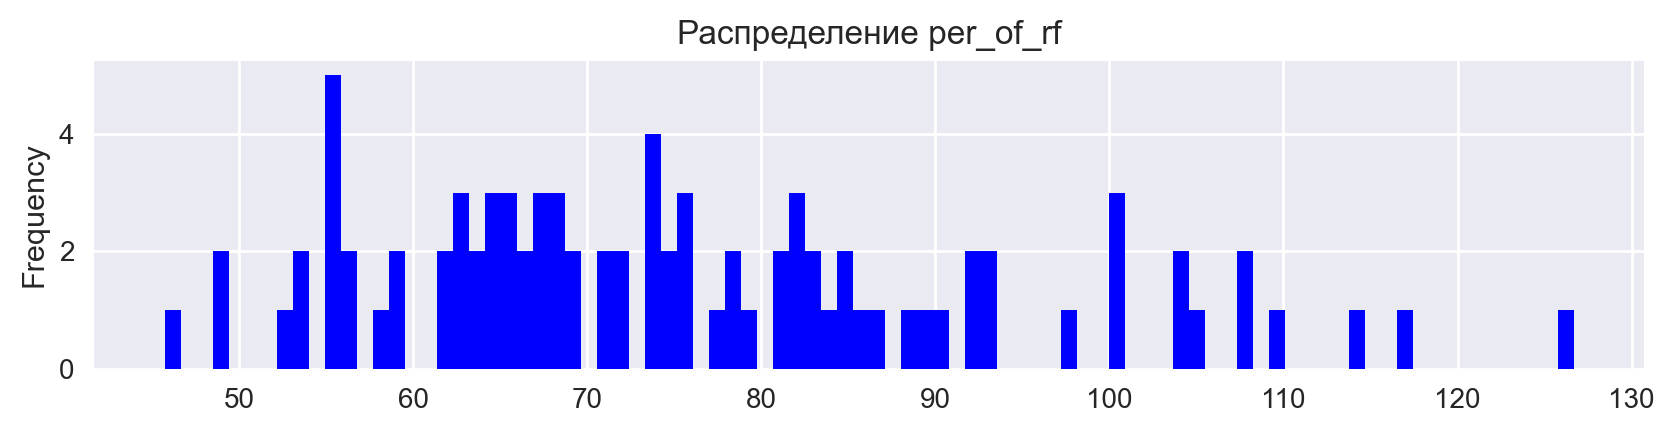

In [20]:
# выведем распределние признака per_of_rf в данных poor
feature_histogram(df=poor, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд в данных (растет доля бедных) + уровень показателей за последний год выше уровня по РФ
- а также отношение показателей за последний год к показателям РФ более 110 процентов

In [21]:
# отмечаем ПЛОХИЕ регионы
poor = data_preparation_step_3(poor, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=110)

poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022
* 'ПЛОХИЕ' регионы *


,region,2022,trend,per_of_rf,bad_region
22,Ненецкий автономный округ,12.0,-1,114.29,1
31,Республика Адыгея,11.0,1,104.76,1
62,Тюменская область,12.3,-1,117.14,1
64,Ямало-Ненецкий автономный округ,13.3,1,126.67,1
78,Республика Саха (Якутия),10.9,1,103.81,1


* Всего 'ПЛОХИХ' регионов: 5 *
----------------------------------------------------------------------------------------------------


Теперь подправим названия признаков в таблицах, используя префикс.

In [22]:
# правим названия признаков и выводим первые пять строк обновленных таблиц
data_features_rename(df=poor, prefix='poor')

poor - Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022
Размерность данных: (88, 5)


,region,poor,poor_trend,poor_per_of_rf,poor_bad_region
0,РФ,10.5,-1,100.00,0
1,Белгородская область,8.7,-1,82.86,0
2,Брянская область,8.2,-1,78.10,0
3,Владимирская область,5.9,-1,56.19,0
4,Воронежская область,9.8,-1,93.33,0


***

### 1.4. Данные о детской смертности

Данные представляют собой файлы формата *.xls* и содержат следующие таблицы:
- **child_mortality_rural_1990_2021** - Число умерших на первом году жизни детей за год (человек, значение показателя за год) - сельское население
- **child_mortality_urban_1990_2021** - Число умерших на первом году жизни детей за год (человек, значение показателя за год) - городское население

С одной стороны, мы имеем данные в разрезе городской и сельской местности. Однако других данных в таком же разрезе мы не имеем. Кроме того, данные представлены в абсолютных числах и их надо переводить на доли (в нашем случае, на 100k населения).     
В **итоге**: данные суммируем в одну таблицу и пересчитываем на 100k населения. Необходимо удалить данные за период 1990-1998, т.к. в данных по населению у нас за период 1999-2022.

In [23]:
# загружаем данные и переименовываем признак названия региона в region
child_mortality_rural = pd.read_excel(io='data_provided/child_mortality_rural_1990_2021.xls', header=2, skipfooter=13, usecols='A, D:AI')
child_mortality_rural.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
child_mortality_urban = pd.read_excel(io='data_provided/child_mortality_urban_1990_2021.xls', header=2, skipfooter=13, usecols='A, D:AI')
child_mortality_urban.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)

# присваиваем имя таблице
child_mortality_rural.name = 'child_mortality_rural\nЧисло умерших на первом году жизни детей за год (человек, значение показателя за год) СЕЛЬСКОЕ население'
child_mortality_urban.name = 'child_mortality_urban\nЧисло умерших на первом году жизни детей за год (человек, значение показателя за год) ГОРОДСКОЕ население'

# производим предварительную обработку данных и выводим их
child_mortality_rural = data_preparation_step_1(df=child_mortality_rural, region='region', replacement='без')
child_mortality_urban = data_preparation_step_1(df=child_mortality_urban, region='region', replacement='без')

*** Данные после первичной обработки ***
child_mortality_rural
Число умерших на первом году жизни детей за год (человек, значение показателя за год) СЕЛЬСКОЕ население


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,РФ,11186.0,10943.0,10111.0,9840.0,9010.0,8582.0,7983.0,7701.0,7214.0,...,5463.0,5059.0,4681.0,4165.0,3568.0,3032.0,2521.0,2122.0,1916.0,1852.0
1,Белгородская область,103.0,92.0,75.0,79.0,80.0,72.0,72.0,67.0,61.0,...,43.0,48.0,41.0,42.0,36.0,34.0,33.0,16.0,22.0,20.0
2,Брянская область,124.0,109.0,83.0,121.0,99.0,104.0,96.0,67.0,75.0,...,46.0,47.0,39.0,44.0,36.0,31.0,12.0,11.0,12.0,13.0
3,Владимирская область,80.0,58.0,60.0,62.0,46.0,50.0,47.0,38.0,39.0,...,30.0,31.0,23.0,31.0,28.0,17.0,22.0,15.0,10.0,14.0
4,Воронежская область,138.0,179.0,156.0,149.0,154.0,137.0,133.0,132.0,125.0,...,32.0,33.0,33.0,25.0,24.0,18.0,22.0,7.0,12.0,10.0


Размерность: (88, 33)
Количество строк, содержащих пропуски 8
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
18,Москва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,3.0,9.0,11.0,6.0,11.0,13.0,14.0,5.0,10.0,9.0
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.0,29.0,25.0,17.0,22.0,14.0,16.0,5.0,10.0
30,Санкт-Петербург,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,88.0,63.0,63.0,43.0,53.0,54.0,51.0
38,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,1.0,1.0,0.0,0.0,0.0
44,Чеченская Республика,662.0,660.0,510.0,0.0,0.0,0.0,0.0,NaN,NaN,...,439.0,269.0,319.0,244.0,190.0,171.0,137.0,99.0,72.0,81.0
63,Ханты-Мансийский автономный округ - Югра,44.0,44.0,40.0,46.0,25.0,47.0,31.0,34.0,33.0,...,15.0,9.0,10.0,10.0,8.0,15.0,5.0,4.0,5.0,NaN
65,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,75.0,62.0,62.0,46.0,41.0,44.0,29.0,23.0,17.0


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
child_mortality_urban
Число умерших на первом году жизни детей за год (человек, значение показателя за год) ГОРОДСКОЕ население


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,РФ,23902.0,21549.0,19097.0,18106.0,17131.0,16258.0,14842.0,14034.0,13883.0,...,10843.0,10418.0,9641.0,8499.0,7860.0,6545.0,5723.0,5206.0,4573.0,4664.0
1,Белгородская область,209.0,198.0,165.0,165.0,153.0,131.0,102.0,100.0,99.0,...,84.0,68.0,62.0,68.0,72.0,43.0,40.0,23.0,25.0,34.0
2,Брянская область,198.0,195.0,200.0,176.0,157.0,125.0,116.0,135.0,107.0,...,81.0,77.0,87.0,67.0,67.0,65.0,33.0,26.0,29.0,14.0
3,Владимирская область,221.0,209.0,179.0,148.0,165.0,146.0,114.0,123.0,130.0,...,97.0,86.0,87.0,76.0,72.0,59.0,45.0,43.0,51.0,52.0
4,Воронежская область,261.0,262.0,262.0,213.0,194.0,184.0,140.0,143.0,177.0,...,134.0,153.0,112.0,101.0,96.0,90.0,77.0,74.0,58.0,73.0


Размерность: (88, 33)
Количество строк, содержащих пропуски 6
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,84.0,68.0,59.0,62.0,50.0,39.0,42.0,24.0,22.0
33,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,62.0,58.0,49.0,37.0,36.0,48.0,46.0
38,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.0,24.0,19.0,12.0,15.0,15.0,21.0
44,Чеченская Республика,263.0,326.0,393.0,0.0,0.0,0.0,0.0,NaN,NaN,...,322.0,301.0,174.0,141.0,114.0,102.0,72.0,68.0,109.0,116.0
63,Ханты-Мансийский автономный округ - Югра,331.0,315.0,279.0,311.0,244.0,280.0,195.0,167.0,162.0,...,109.0,141.0,113.0,124.0,97.0,93.0,60.0,83.0,70.0,NaN
65,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,87.0,77.0,83.0,68.0,50.0,43.0,52.0,48.0,40.0


----------------------------------------------------------------------------------------------------


**Выводы:**
- Данные содержат пропуски по Крыму и Севастополю (причины понятны), по Чеченской Республике (из-за войны) и в проблемных (с точки зрения делений на округа) регионах: Архангельская и Тюменская области. 
- Имеется пропуск за последний (2021) год в Ханты-Мансийский автономном округе - Югра: и это проблема, т.к. нам нужен этот показатель для кластеризации. 
- Севастополь в **child_mortality_rural** имеет пропуски до 2015 (это объяснимо), и 0 за последние 3 года. 
- Санкт-Петербург и Москва в **child_mortality_rural** имеют пропуски и нулевые значения
- Последние две аномалии можно попробовать объяснить тем, что в городах действительно не было смертности детей, относящихся к сельской местности, но это вызывет большие сомнения

Посмотрим, можем ли мы заменить пропуск по Ханты-Мансийскому автономномному округу - Югра, рассчитав его отнимая сумму показателя всех регионов из показателя по РФ:

In [24]:
# рассчитаем лишние данные (Архангельская и Тюменская области) в обеих таблицах

mask_1 = child_mortality_rural['region'] == 'Архангельская область'
mask_2 = child_mortality_rural['region'] == 'Тюменская область'
excessive_value_rural = child_mortality_rural[mask_1 | mask_2].iloc[:,-1].sum()

mask_1 = child_mortality_urban['region'] == 'Архангельская область'
mask_2 = child_mortality_urban['region'] == 'Тюменская область'
excessive_value_urban = child_mortality_urban[mask_1 | mask_2].iloc[:,-1].sum()

In [25]:
# расчитываем пропущенные значения в обеих таблицах
lost_value_rural = child_mortality_rural['2021'].iloc[0] - (child_mortality_rural['2021'].iloc[1:].sum() - excessive_value_rural)
lost_value_urban = child_mortality_urban['2021'].iloc[0] - (child_mortality_urban['2021'].iloc[1:].sum() - excessive_value_urban)

child_mortality_rural.iloc[63, -1] = lost_value_rural
child_mortality_urban.iloc[63, -1] = lost_value_urban

print(lost_value_rural, ';', lost_value_urban)

9.0 ; 66.0


Цифры подходят в пропущенные ячейки, будем считать, что с пропусками за 2021 в обеих таблицах мы справились.

Теперь объединим данные в одну таблицу, удалим данные за период 1990-1998 и сделаем перерасчет на 100k населения по формуле: число умерших за год / численность населения * 100000

In [26]:
# проверка на идентичность регионов в обеих таблицах
if child_mortality_rural['region'].equals(child_mortality_urban['region']):
    print('Названия и порядок регионов в таблицах идентичны')
    # суммируем данные обеих таблиц
    child_mortality = pd.concat(
        [child_mortality_rural.region, child_mortality_rural.iloc[:,1:] + child_mortality_urban.iloc[:,1:]], axis=1)
    # удалим данные 1990-1998
    child_mortality.drop(list(child_mortality)[1:10], axis=1, inplace=True)
    # выведем новые данные
    print(f'Размерность: {child_mortality.shape}')
    display(child_mortality.head())
else:
    print('Названия и/или порядок регионов в таблицах отличаются')

Названия и порядок регионов в таблицах идентичны
Размерность: (88, 24)


,region,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,РФ,20731.0,19286.0,19104.0,18407.0,18142.0,17339.0,16073.0,15079.0,14858.0,...,16306.0,15477.0,14322.0,12664.0,11428.0,9577.0,8244.0,7328.0,6489.0,6516.0
1,Белгородская область,161.0,157.0,173.0,155.0,130.0,122.0,118.0,123.0,76.0,...,127.0,116.0,103.0,110.0,108.0,77.0,73.0,39.0,47.0,54.0
2,Брянская область,184.0,177.0,175.0,168.0,160.0,153.0,145.0,94.0,114.0,...,127.0,124.0,126.0,111.0,103.0,96.0,45.0,37.0,41.0,27.0
3,Владимирская область,174.0,171.0,182.0,171.0,129.0,140.0,128.0,108.0,104.0,...,127.0,117.0,110.0,107.0,100.0,76.0,67.0,58.0,61.0,66.0
4,Воронежская область,280.0,245.0,245.0,205.0,214.0,207.0,203.0,158.0,168.0,...,166.0,186.0,145.0,126.0,120.0,108.0,99.0,81.0,70.0,83.0


In [27]:
# пересчитываем детскую смертность на 100k населения
child_mortality_100k = index_into_100k_population(
    child_mortality, population_temp.iloc[:,1:24], round=0, year_first=1999, year_last=2021)
# задаем имя новой таблице
child_mortality_100k.name = 'child_mortality_100k - Число умерших на первом году жизни детей за год на 100k насления (за год)'

In [28]:
# производим второй этап обработки данных и выводим их
child_mortality_100k = data_preparation_step_2(df=child_mortality_100k, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
child_mortality_100k - Число умерших на первом году жизни детей за год на 100k насления (за год)


,region,2021,trend,per_of_rf
0,РФ,4.0,-1,100.0
1,Белгородская область,4.0,-1,100.0
2,Брянская область,2.0,-1,50.0
3,Владимирская область,5.0,-1,125.0
4,Воронежская область,4.0,-1,100.0


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
44,Чеченская Республика,13.0,1,325.0


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 37 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
44,Чеченская Республика,13.0,1,325.0


Всего таких регионов: 1 *
----------------------------------------------------------------------------------------------------


**Выводы:**
- Чеченская Республика показывает более чем 3-хкратное превышение показателя детской смертности, по сравнению с РФ в целом, кроме того демонстрирует при этом положительный тренд. Почему ???
- 37 регионов по данному показателю хуже уровня РФ, но у них тренд на снижение детской смертности.

child_mortality_100k - Число умерших на первом году жизни детей за год на 100k насления (за год)


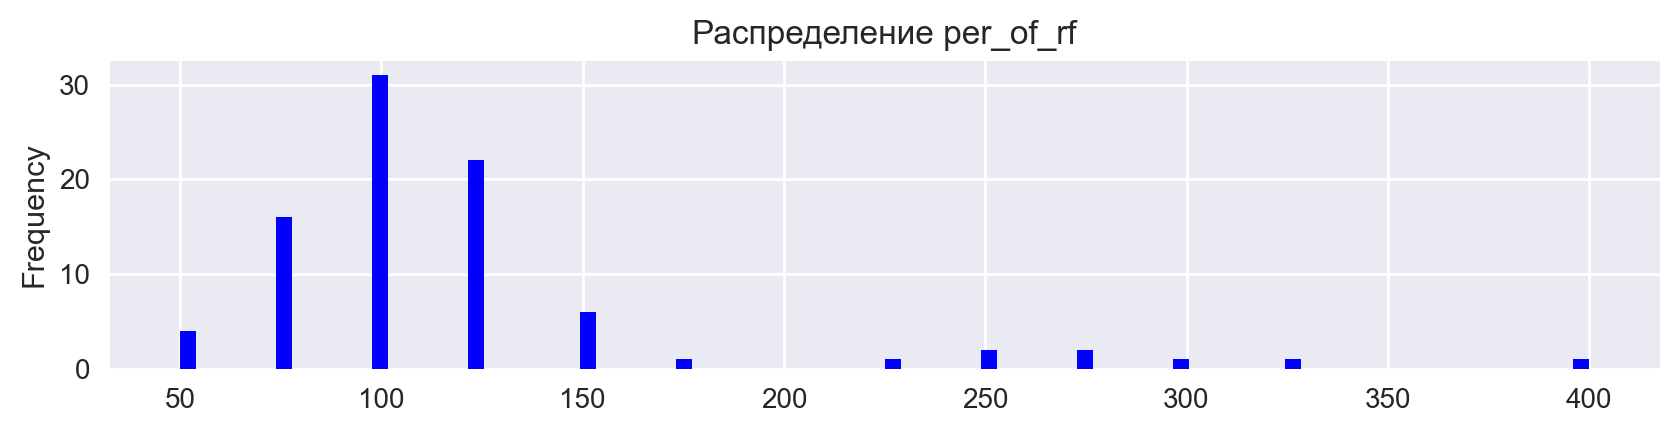

In [29]:
# выведем распределние признака per_of_rf в данных child_mortality_100k
feature_histogram(df=child_mortality_100k, feature='per_of_rf')

Теперь в этих таблицах пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд в данных (детская смертность растет) + показатель детской смертности более 120% от уровня по РФ в целом
- а также, если показатель детской смертности более 130% от уровня по РФ в целом

In [30]:
# отмечаем проблемные регионы
child_mortality_100k = data_preparation_step_3(child_mortality_100k, bad_trend=1, bad_per_of_rf='more', and_threshold=120, add_threshold=130)

child_mortality_100k - Число умерших на первом году жизни детей за год на 100k насления (за год)
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
22,Ненецкий автономный округ,7.0,-1,175.0,1
37,Ростовская область,6.0,-1,150.0,1
39,Республика Дагестан,11.0,-1,275.0,1
40,Республика Ингушетия,10.0,-1,250.0,1
41,Кабардино-Балкарская Республика,6.0,-1,150.0,1
44,Чеченская Республика,13.0,1,325.0,1
64,Ямало-Ненецкий автономный округ,6.0,-1,150.0,1
67,Республика Алтай,10.0,-1,250.0,1
68,Республика Тыва,11.0,-1,275.0,1
69,Республика Хакасия,6.0,-1,150.0,1


* Всего 'ПЛОХИХ' регионов: 15 *
----------------------------------------------------------------------------------------------------


Помимо Чеченской Республики, мы видим ОЧЕНЬ высокие показатели детской смертности в Еврейской автономной области и Чукотском автономном округе, не смотря на отрицаетльный тренд в этих регионах.

Теперь подправим названия признаков в таблицах, используя префикс.

In [31]:
# правим названия признаков
data_features_rename(df=child_mortality_100k, prefix='child_mortality_100k')

child_mortality_100k - Число умерших на первом году жизни детей за год на 100k насления (за год)
Размерность данных: (88, 5)


,region,child_mortality_100k,child_mortality_100k_trend,child_mortality_100k_per_of_rf,child_mortality_100k_bad_region
0,РФ,4.0,-1,100.0,0
1,Белгородская область,4.0,-1,100.0,0
2,Брянская область,2.0,-1,50.0,0
3,Владимирская область,5.0,-1,125.0,0
4,Воронежская область,4.0,-1,100.0,0


***

### 1.5. Число людей с инвалидностью

Данные представляют собой файл формата *.xls* и содержит следующую таблицу:
- **disabled_total_by_age_2017_2022** - число людей с инвалидностью по регионам, по месяцам, по возрастным группам

Для дополнительного изучения темы использовано:    
[Нацун Л. Н. Исследование особенностей статистического учета первичной инвалидности взрослого населения в России в контексте социальной политики / Л. Н. Нацун // Siberian Socium. 2020. Том 4. No 2 (12). С. 32-47.
DOI: 10.21684/2587-8484-2020-4-2-32-47](https://elib.utmn.ru/jspui/bitstream/ru-tsu/5116/1/SibSoc_2020_2_32_47.pdf)

In [32]:
# загружаем данные
disabled_total_by_age = pd.read_csv('data_provided/disabled_total_by_age_2017_2022.csv')

# преобразуем признак date в тип datetime
disabled_total_by_age['date'] = pd.to_datetime(disabled_total_by_age['date'],format='%Y-%m-%d')

# выведем данные
display(disabled_total_by_age.head())
print(f'Минимальная дата: {disabled_total_by_age.date.min()}')
print(f'Максимальная дата: {disabled_total_by_age.date.max()}')

,region,total,18_30,31_40,41_50,51_60,60_,date
0,Российская Федерация,11640873.0,550895.0,766054.0,1030652.0,2135436.0,7157836.0,2017-01-01
1,Центральный федеральный округ,3420310.0,118579.0,172662.0,257484.0,598102.0,2273483.0,2017-01-01
2,Белгородская область,223030.0,6318.0,10383.0,16596.0,37444.0,152289.0,2017-01-01
3,Брянская область,110418.0,4215.0,6568.0,10230.0,21481.0,67924.0,2017-01-01
4,Владимирская область,133352.0,4454.0,6811.0,9606.0,23322.0,89159.0,2017-01-01


Минимальная дата: 2017-01-01 00:00:00
Максимальная дата: 2022-04-01 00:00:00


Понятно, что представленные данные нужно сгруппировать по годам. Нужно учесть, что данные за 2022 года ограничиваются только первыми 3-мя месяцами. Группировать будем по годам, последний год для кластеризации - 2021.    
Как правильно поступить с данными? Взять общее количество людей с инвалидностью или отдельно пожилых и работоспособного возраста?    
Мы видим, что людей старше 60 лет с инвалидностью довольно много, по сравнению с остальными возрастными группами. Почему?

- люди старше 60 лет (назовем их условно 'пенсионеры', хотя с учетом поднятия пенсионного возраста это не совсем корректно) чаще имеют хронические заболевания, которые приводят к инвалидности
- инвалидность бывает 3 групп, полностью нерабочая только 1-я
- из приведенной статьи можно сделать вывод, что первичная инвалидность растет за счет тех представителей населения, которые имеют нарушения здоровья, приводящие к ограничениям жизнедеятельности, тогда, когда для них сравнительные выгоды от получения второй или третьей групп инвалидности заметно превышают выгоды от трудовой деятельности
- из этой же статьи следует еще один вывод: показатели инвалидности взрослого населения в рамках действующей системы статистического учета в большей степени отражают социально-экономическое благополучие и защищенность населения (а это нам и надо!), нежели служат критериями оценки общественного здоровья
- людям старше 60 лет труднее найти работу, им сложнее выполнять обязанности из-за наличие сопутствующих заболеваний, у них есть уже пенсия - им выгодней оформить инвалидность
- если человеку трудоспособного возраста выгодней оформить пенсию по инвалидности, вместо того, чтобы работать - значит он не может найти высокооплачиваемую работу и это говорит о том, что регион неблагополучный.

**Вывод:** группируем данные по годам считая среднее по году, берем данные по 2021 год включительно, оставляем данные только по трудоспособному населению.

In [33]:
# создадим признак year в исходных данных
disabled_total_by_age['year'] = disabled_total_by_age['date'].dt.year
# создадим признак 18_60 и суммируем показатели трудоспособного населения
disabled_total_by_age['18_60'] = disabled_total_by_age[['18_30', '31_40', '41_50', '51_60']].sum(axis=1)

# выделим новый датасет из исходного с необходимыми данными
disabled_18_60 = disabled_total_by_age[['region', '18_60', 'year']]

# сгруппируем данные по годам и регионам рассчитав средние показатели за год
disabled_18_60 = disabled_18_60.groupby(by=['year', 'region']).mean().round()

# создадим готовую рабочую таблицу
disabled = pd.pivot_table(data=disabled_18_60, values='18_60', index='region', columns='year').reset_index().drop(2022, axis=1)
disabled.head()

year,region,2017,2018,2019,2020,2021
0,Алтайский край,60204.0,63661.0,62145.0,60675.0,59463.0
1,Амурская область,27333.0,26312.0,25531.0,24683.0,23825.0
2,Архангельская область,28715.0,27877.0,27333.0,26803.0,26297.0
3,Астраханская область,20665.0,20136.0,19694.0,19490.0,19363.0
4,Белгородская область,68943.0,65230.0,62494.0,59634.0,56958.0


In [34]:
# присваиваем имя таблице
disabled.name = 'disabled\nЧисло людей с инвалидностью по регионам (трудоспособный возраст)'

# производим предварительную обработку данных и выводим их
disabled = data_preparation_step_1(disabled, region='region', replacement='без')

*** Данные после первичной обработки ***
disabled
Число людей с инвалидностью по регионам (трудоспособный возраст)


,region,2017,2018,2019,2020,2021
0,Алтайский край,60204.0,63661.0,62145.0,60675.0,59463.0
1,Амурская область,27333.0,26312.0,25531.0,24683.0,23825.0
2,Архангельская область,28715.0,27877.0,27333.0,26803.0,26297.0
3,Астраханская область,20665.0,20136.0,19694.0,19490.0,19363.0
4,Белгородская область,68943.0,65230.0,62494.0,59634.0,56958.0


Размерность: (86, 6)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


В таблице только 86 регионов: вылезают косяки с Архангельской и Тюменской областями. В таблице нет отдельно этих данных по областям без регионов. Придется считать самим.

In [35]:
# выведем данные по проблемным областям и округам
mask_1 = (disabled['region'] == 'Архангельская область') | (disabled['region'] == 'Ненецкий автономный округ')
mask_2 = (disabled['region'] == 'Тюменская область') | (disabled['region'] == 'Ханты-Мансийский автономный округ - Югра')\
    | (disabled['region'] == 'Ямало-Ненецкий автономный округ')
disabled[mask_1 | mask_2]

,region,2017,2018,2019,2020,2021
2,Архангельская область,28715.0,27877.0,27333.0,26803.0,26297.0
31,Ненецкий автономный округ,1185.0,1166.0,1168.0,1156.0,1113.0
72,Тюменская область,36918.0,36020.0,35329.0,34687.0,34011.0
76,Ханты-Мансийский автономный округ - Югра,27386.0,27282.0,27560.0,27337.0,27110.0
81,Ямало-Ненецкий автономный округ,7921.0,7740.0,7632.0,7581.0,7578.0


In [36]:
# рассчитываем разницу между показателями Архангельской области и Ненецким автономным округом
add_row_1 = (disabled[mask_1 | mask_2].iloc[0,1:] - disabled[mask_1 | mask_2].iloc[1,1:]).to_list()
add_row_1.insert(0, 'Архангельская область без Ненецкого АО')
# рассчитываем разницу между показателями Тюменской области и ее округами
add_row_2 = (disabled[mask_1 | mask_2].iloc[2,1:] - (disabled[mask_1 | mask_2].iloc[3,1:] + disabled[mask_1 | mask_2].iloc[4,1:])).to_list()
add_row_2.insert(0, 'Тюменская область без округов')

# создадим новый датафрейм с результами и выведем его
disabled_add = pd.DataFrame(
    [add_row_1,add_row_2], 
    columns=['region',2017,2018,2019,2020,2021]
   
    )
disabled_add

,region,2017,2018,2019,2020,2021
0,Архангельская область без Ненецкого АО,27530.0,26711.0,26165.0,25647.0,25184.0
1,Тюменская область без округов,1611.0,998.0,137.0,-231.0,-677.0


Понятно, что отрицательные значения получены из-за того, что мы считали среднее в сгруппированных данных выше.    
Добавим рассчитанные данные в исходную таблицу.

In [37]:
# обновляем рабочую таблицу, добавив новые данные 
disabled = pd.concat([disabled, disabled_add]).reset_index().drop('index', axis=1)

Теперь пересчитываем инвалидность на 100k населения.

In [38]:
# отсортируем таблицы инвалидности и населения, чтобы порядок регионов совпадал
disabled_sorted = disabled.sort_values(by = "region").reset_index().drop('index', axis=1)
population_temp_sorted = population_temp.sort_values(by = "region").reset_index().drop('index', axis=1)

# проверка на идентичность регионов в обеих таблицах
if disabled_sorted['region'].equals(population_temp_sorted['region']):
    print('Названия и порядок регионов в таблицах идентичны')
    # пересчитываем инвалидность на 100k населения
    disabled_100k = index_into_100k_population(
    disabled_sorted, population_temp_sorted.iloc[:,19:24], round=0, year_first=2017, year_last=2021)
    # выведем новые данные
    print(f'Размерность: {disabled_100k.shape}')
    display(disabled_100k.head())
else:
    print('Названия и/или порядок регионов в таблицах отличаются')

Названия и порядок регионов в таблицах идентичны
Размерность: (88, 6)


,region,2017,2018,2019,2020,2021
0,Алтайский край,2545.0,2709.0,2664.0,2619.0,2589.0
1,Амурская область,3409.0,3295.0,3219.0,3124.0,3047.0
2,Архангельская область,2463.0,2414.0,2389.0,2358.0,2333.0
3,Архангельская область без Ненецкого АО,2454.0,2404.0,2378.0,2348.0,2326.0
4,Астраханская область,2028.0,1979.0,1942.0,1938.0,1941.0


In [39]:
# для корректной работы функций надо сместить строку РФ вверх таблицы
ixs_rf = disabled_100k[disabled_100k['region'] == 'РФ'].index[0]
disabled_100k = pd.concat([disabled_100k.iloc[[ixs_rf],:], disabled_100k.drop(ixs_rf, axis=0)], axis=0)

# задаем имя новой таблице
disabled_100k.name = 'disabled_100k - Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)'

In [40]:
# производим второй этап обработки данных и выводим их
disabled_100k = data_preparation_step_2(df=disabled_100k, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
disabled_100k - Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)


,region,2021,trend,per_of_rf
44,РФ,2793.0,-1,100.00
0,Алтайский край,2589.0,-1,92.70
1,Амурская область,3047.0,-1,109.09
2,Архангельская область,2333.0,-1,83.53
3,Архангельская область без Ненецкого АО,2326.0,-1,83.28


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
32,Мурманская область,1586.0,1,56.78
36,Новосибирская область,2531.0,1,90.62
50,Республика Ингушетия,8551.0,1,306.16
67,Сахалинская область,1985.0,1,71.07
74,Томская область,2715.0,1,97.21
83,Чеченская Республика,9830.0,1,351.95
85,Чукотский автономный округ,2156.0,1,77.19


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 38 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
50,Республика Ингушетия,8551.0,1,306.16
83,Чеченская Республика,9830.0,1,351.95


Всего таких регионов: 2 *
----------------------------------------------------------------------------------------------------


Республика Ингушетия и Чеченская Республика в лидерах по числу инвалидов трудоспособного возраста, причем превышение показателей над общероссийскими более чем в 3 раза. Учитывая положительный тренд в этих же регионах и периодом данных 2017-2021 эти цифры нельзя объяснить войной.

disabled_100k - Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)


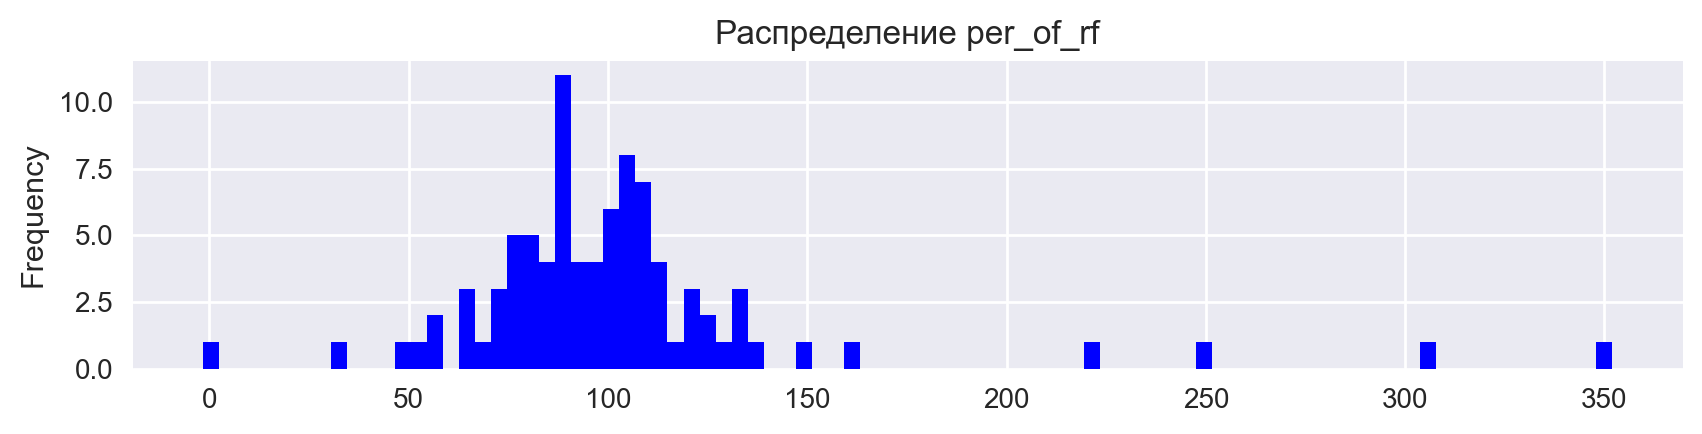

In [41]:
# выведем распределние признака per_of_rf в данных disabled_100k
feature_histogram(df=disabled_100k, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд в данных (рост числа людей с инвалидностью в трудоспособном возрасте) + показатель инвалидности более 140% от уровня по РФ в целом
- а также, если показатель инвалидности более 140% от уровня по РФ в целом

In [42]:
# отмечаем проблемные регионы
disabled_100k = data_preparation_step_3(disabled_100k, bad_trend=1, bad_per_of_rf='more', and_threshold=140, add_threshold=140)

disabled_100k - Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
19,Карачаево-Черкесская Республика,6230.0,-1,223.06,1
26,Курская область,4544.0,-1,162.69,1
49,Республика Дагестан,6990.0,-1,250.27,1
50,Республика Ингушетия,8551.0,1,306.16,1
60,Республика Тыва,4209.0,-1,150.70,1
83,Чеченская Республика,9830.0,1,351.95,1


* Всего 'ПЛОХИХ' регионов: 6 *
----------------------------------------------------------------------------------------------------


По итогу плохие данные по инвалидности мы видим в республиках Северного Кавказа, Республика Тыва, Курская область.

Теперь подправим названия признаков, используя префикс.

In [43]:
# правим названия признаков
data_features_rename(df=disabled_100k, prefix='disabled_100k')

disabled_100k - Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)
Размерность данных: (88, 5)


,region,disabled_100k,disabled_100k_trend,disabled_100k_per_of_rf,disabled_100k_bad_region
44,РФ,2793.0,-1,100.00,0
0,Алтайский край,2589.0,-1,92.70,0
1,Амурская область,3047.0,-1,109.09,0
2,Архангельская область,2333.0,-1,83.53,0
3,Архангельская область без Ненецкого АО,2326.0,-1,83.28,0


***

### 1.6. Алкоголизм и наркомания

Данные представляют собой файл формата *.xlsx* и содержит следующие таблицы:
- **alco** - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения (2005-2016)
- **alco1718** - то же, но за 2017-2018
- **drugs** - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января) (2005-2016)
- **drug1718** - то же, но за 2017-2018

In [44]:
# загружаем данные
alco = pd.read_excel(io='data_provided/drug_alco.xlsx', sheet_name=0)
alco1718 = pd.read_excel(io='data_provided/drug_alco.xlsx', sheet_name=1)
drugs = pd.read_excel(io='data_provided/drug_alco.xlsx', sheet_name=2)
drug1718 = pd.read_excel(io='data_provided/drug_alco.xlsx', sheet_name=3)

# присваиваем имена таблицам
alco.name = 'alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения'
alco1718.name = 'alco - Дополнительные данные 2017-2018'
drugs.name = 'drugs - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)'
drug1718.name = 'drugs - Дополнительные данные 2017-2018'

# производим предварительную обработку данных и выводим их
alco = data_preparation_step_1(df=alco, region='region', replacement='')
alco1718 = data_preparation_step_1(df=alco1718, region='region', replacement='')
drugs = data_preparation_step_1(df=drugs, region='region', replacement='')
drug1718 = data_preparation_step_1(df=drug1718, region='region', replacement='')

*** Данные после первичной обработки ***
alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,147.4,135.3,123.1,122.2,112.5,108.5,96.7,85.8,78.3,74.6,70.9,64.9
1,Белгородская область,99.6,93.2,84.0,92.3,94.3,86.4,72.6,74.8,66.9,56.8,50.7,46.1
2,Брянская область,243.8,231.8,242.0,225.8,180.2,180.6,133.2,134.4,130.2,120.6,102.5,107.9
3,Владимирская область,178.3,161.5,147.1,145.0,140.5,135.0,120.8,88.8,94.1,87.7,81.7,75.7
4,Воронежская область,154.4,172.4,141.7,156.1,141.6,130.9,116.2,111.7,113.8,109.9,109.1,97.1


Размерность: (84, 13)
Количество строк, содержащих пропуски 15
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
21,Архангельская область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN
30,Республика Адыгея,120.6,126.7,102.0,132.8,132.7,129.1,116.4,110.5,82.8,NaN,NaN,NaN
31,Республика Калмыкия,98.9,92.7,90.8,111.3,117.1,96.1,70.3,60.3,52.8,NaN,NaN,NaN
32,Краснодарский край,111.6,99.1,105.1,96.7,90.3,78.9,67.2,52.0,45.6,NaN,NaN,NaN
33,Астраханская область,137.1,166.0,130.3,116.1,134.5,113.4,91.7,84.7,61.8,NaN,NaN,NaN
34,Волгоградская область,156.6,137.9,113.6,116.0,102.6,93.6,88.0,73.6,67.9,NaN,NaN,NaN
35,Ростовская область,102.5,100.9,82.7,86.6,79.8,72.7,63.5,56.2,50.3,NaN,NaN,NaN
36,Республика Дагестан,36.8,37.7,32.7,31.9,31.3,31.8,23.9,28.8,23.1,NaN,NaN,NaN
37,Республика Ингушетия,2.7,2.9,0.0,0.6,0.4,0.4,0.5,0.7,1.6,NaN,NaN,NaN
38,Кабардино-Балкарская Республика,90.2,85.8,80.7,81.6,88.8,82.9,62.1,63.9,81.0,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
alco - Дополнительные данные 2017-2018


,region,2017,2018
0,РФ,53.2,51.6
1,Белгородская область,45.2,41.3
2,Брянская область,92.2,82.2
3,Владимирская область,65.3,66.5
4,Воронежская область,76.2,73.4


Размерность: (86, 3)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
drugs - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,17.2,19.1,19.1,18.7,17.8,17.6,15.4,13.9,12.6,14.5,14.1,11.1
1,Белгородская область,4.5,9.5,9.5,4.2,3.9,4.8,4.0,2.3,2.4,1.9,2.0,1.6
2,Брянская область,14.3,11.5,11.5,14.4,15.4,18.3,20.3,15.4,12.8,14.8,6.7,13.2
3,Владимирская область,6.4,5.7,5.7,6.8,8.3,7.8,7.4,9.8,11.5,15.5,21.3,10.7
4,Воронежская область,7.7,12.3,12.3,16.2,16.1,12.6,20.0,18.1,16.8,19.9,26.0,20.1


Размерность: (84, 13)
Количество строк, содержащих пропуски 15
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
21,Архангельская область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN
30,Республика Адыгея,45.8,50.2,50.2,37.3,16.9,14.0,15.2,12.4,5.9,NaN,NaN,NaN
31,Республика Калмыкия,19.7,29.2,29.2,10.9,6.0,5.3,3.8,4.5,0.4,NaN,NaN,NaN
32,Краснодарский край,39.9,43.3,43.3,27.8,15.3,10.5,9.8,6.0,4.3,NaN,NaN,NaN
33,Астраханская область,10.7,12.9,12.9,6.8,8.1,9.8,7.5,5.1,2.3,NaN,NaN,NaN
34,Волгоградская область,11.0,17.9,17.9,13.9,19.8,21.9,16.1,15.0,6.0,NaN,NaN,NaN
35,Ростовская область,7.1,8.4,8.4,7.4,9.8,10.8,17.5,12.8,12.3,NaN,NaN,NaN
36,Республика Дагестан,15.3,20.0,20.0,17.1,12.9,16.8,16.7,14.5,14.6,NaN,NaN,NaN
37,Республика Ингушетия,6.4,6.7,6.7,4.8,4.1,0.6,1.2,0.7,1.4,NaN,NaN,NaN
38,Кабардино-Балкарская Республика,31.9,37.6,37.6,21.1,16.7,17.7,17.7,17.2,12.8,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
drugs - Дополнительные данные 2017-2018


,region,2017,2018
0,РФ,11.0,10.1
1,Белгородская область,2.3,3.2
2,Брянская область,10.7,6.1
3,Владимирская область,12.9,7.8
4,Воронежская область,23.2,22.5


Размерность: (86, 3)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


In [45]:
# проверка идентичности названий регионов
set_1 = set(alco.region)
set_2 = set(alco1718.region)
print('Рзазница регионов в таблицах alco и alco1718')
print(set_1 - set_2)
print(set_2 - set_1)

set_1 = set(drugs.region)
set_2 = set(drug1718.region)
print('Разница регионов в таблицах drugs и drug1718')
print(set_1 - set_2)
print(set_2 - set_1)

Рзазница регионов в таблицах alco и alco1718
{'Архангельская область', 'Тюменская область'}
{'Республика Крым', 'Тюменская область без округов', 'Архангельская область без Ненецкого АО', 'Севастополь'}
Разница регионов в таблицах drugs и drug1718
{'Архангельская область', 'Тюменская область'}
{'Республика Крым', 'Тюменская область без округов', 'Архангельская область без Ненецкого АО', 'Севастополь'}


**Выводы:**
- таблица alco, в отличие от таблицы alco1718, содержит данные по регионам 'Архангельская область', 'Тюменская область' и не содержит данные по 'Севастополь', 'Республика Крым', 'Тюменская область без округов', 'Архангельская область без Ненецкого АО'
- с данными по наркоманам ситуация аналогична
- данные предствлены по заболеваемости на 100тыс населения и я не представляю, как их можно восстановить для пропущенных регионов (уже по строчке с РФ видно, что цифры не получить вычитанием)
- кроме того, имеются 15 регионов с пропусками за период 2014-2016 год
- если будем расчитывать тренд, то на итоговые данные нужно будет смотреть с изрядной долей скепсиса
- при объединении таблиц показатели за последние 2 года для Архангельской и Тюменской областей будут пустые

Объединим таблицы.

In [46]:
# объединим таблицы
alco = pd.merge(alco, alco1718, on="region", how='outer')
drug = pd.merge(drugs, drug1718, on="region", how='outer')

# присвоим имена итоговым таблицам
alco.name = 'alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения'
drug.name = 'drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)'

Продолжим разведку в отношении проблемных регионов (с точки зрения стастистики по округам и без округов).

In [47]:
output_problem_regions(alco)
output_problem_regions(drug)

alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
21,Архангельская область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN,NaN,NaN
22,Ненецкий автономный округ,276.4,321.6,290.5,304.6,289.4,245.9,242.3,271.0,212.7,209.8,145.3,98.1,120.5,181.8
59,Тюменская область,163.1,166.5,152.1,149.8,133.3,129.7,115.6,89.4,65.6,NaN,NaN,NaN,NaN,NaN
60,Ханты-Мансийский автономный округ - Югра,165.4,165.2,160.4,159.5,146.7,137.5,121.9,91.7,81.4,80.3,77.7,75.5,50.2,33.7
61,Ямало-Ненецкий автономный округ,213.1,175.6,172.9,158.9,145.3,168.2,155.5,127.9,123.7,117.0,125.9,113.1,91.9,94.7
84,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.3,64.7
87,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.2,61.2


drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
21,Архангельская область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN,NaN,NaN
22,Ненецкий автономный округ,2.4,19.1,19.1,16.7,9.5,4.7,9.5,11.8,4.7,4.6,4.6,0.0,0.0,2.3
59,Тюменская область,24.7,26.8,26.8,20.6,22.8,19.9,18.0,13.3,13.0,NaN,NaN,NaN,NaN,NaN
60,Ханты-Мансийский автономный округ - Югра,34.6,38.2,38.2,26.8,30.5,26.0,22.4,13.9,16.2,18.5,21.0,15.3,12.0,6.2
61,Ямало-Ненецкий автономный округ,18.2,26.6,26.6,21.0,27.5,26.3,19.8,13.6,9.0,7.8,14.3,9.5,14.1,18.9
84,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,9.2
87,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,13.2


Не понимаю, честно говоря, как в данной ситуации лучше поступить. Можно конечно, вместо пропусков в 2018 году в Архангельской и Тюменской областях поставить показатели за последний известный год (2013) или высчитать среднюю, но мне эта идея не нравится. Думаю, что нужно сделать следующее: оставим все как есть, ведь все идет к тому, что скорее всего мы будет проводить кластеризацию на основе данных отдельно по этим областям без АО и АО, то есть эти пропущенные данные скорее всего не понадобятся.

**Итого:** 
- оставим данные за 2018 год вместе с пропусками в Архангельской и Тюменской областях
- тренд учитывать не будем, т.к. много пропусков в данных
- расчитаем отношение показателя за 2018 год по отношению к показателю РФ в процентах

In [48]:
# производим второй этап обработки данных
alco = data_preparation_step_2(df=alco, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
drug = data_preparation_step_2(df=drug, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения


,region,2018,trend,per_of_rf
0,РФ,51.6,-1,100.00
1,Белгородская область,41.3,-1,80.04
2,Брянская область,82.2,-1,159.30
3,Владимирская область,66.5,-1,128.88
4,Воронежская область,73.4,-1,142.25


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2018,trend,per_of_rf
21,Архангельская область,NaN,-1,NaN
59,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2018,trend,per_of_rf
84,Архангельская область без Ненецкого АО,64.7,1,125.39
85,Республика Крым,57.6,1,111.63
86,Севастополь,90.0,1,174.42


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 52 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2018,trend,per_of_rf
84,Архангельская область без Ненецкого АО,64.7,1,125.39
85,Республика Крым,57.6,1,111.63
86,Севастополь,90.0,1,174.42


Всего таких регионов: 3 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)


,region,2018,trend,per_of_rf
0,РФ,10.1,-1,100.00
1,Белгородская область,3.2,-1,31.68
2,Брянская область,6.1,-1,60.40
3,Владимирская область,7.8,1,77.23
4,Воронежская область,22.5,1,222.77


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2018,trend,per_of_rf
21,Архангельская область,NaN,1,NaN
59,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2018,trend,per_of_rf
3,Владимирская область,7.8,1,77.23
4,Воронежская область,22.5,1,222.77
6,Калужская область,6.0,1,59.41
7,Костромская область,8.9,1,88.12
11,Орловская область,4.4,1,43.56
12,Рязанская область,17.2,1,170.30
14,Тамбовская область,5.1,1,50.50
16,Тульская область,9.0,1,89.11
17,Ярославская область,7.6,1,75.25
21,Архангельская область,NaN,1,NaN


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 27 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2018,trend,per_of_rf
4,Воронежская область,22.5,1,222.77
12,Рязанская область,17.2,1,170.30
35,Ростовская область,10.6,1,104.95
56,Ульяновская область,19.1,1,189.11
77,Приморский край,35.5,1,351.49
78,Хабаровский край,17.3,1,171.29
82,Еврейская автономная область,65.4,1,647.52
87,Тюменская область без округов,13.2,1,130.69


Всего таких регионов: 8 *
----------------------------------------------------------------------------------------------------


В данных по алкоголизму положительный тренд и уровень показателей выше РФ (одновременно) отмечается в 3-х регионах с небольшим количеством данных: Архангельская область без Ненецкого АО, Республика Крым и Севастополь. Кроме того в данных по алкоголизму довольно много пропусков. В целом, картина по алкоголизму представляется более приятной (если можно так сказать), по сравнению с картиной по наркомании. Распространенность наркомании при одновременном превышении показателей РФ в целом мы видим уже в 8 регионах. 

alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения


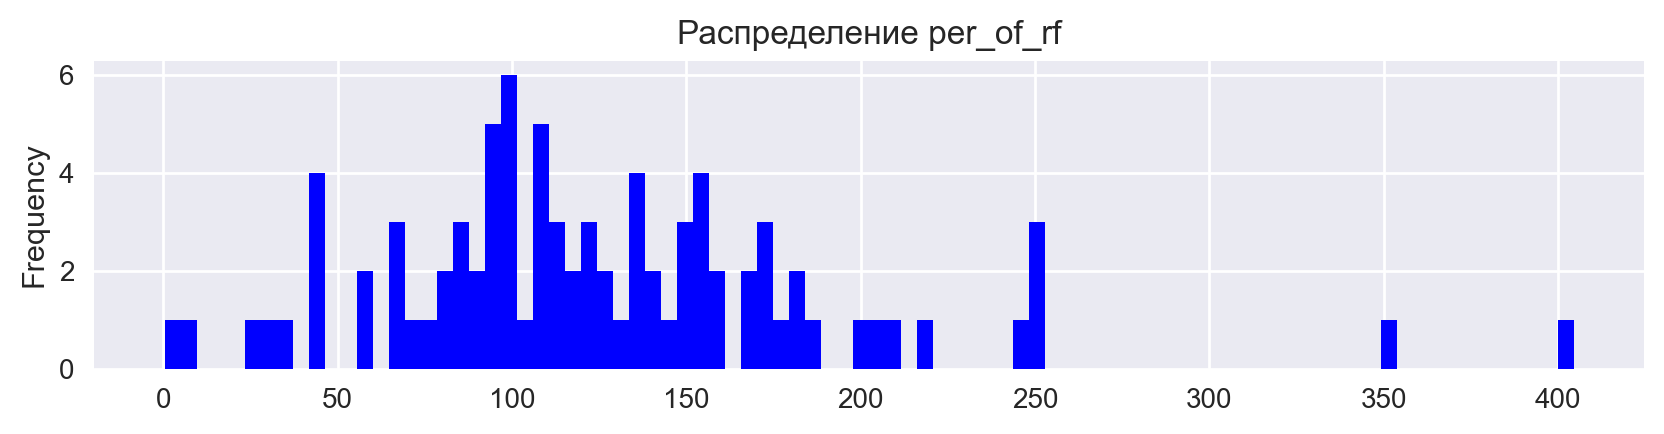

In [49]:
# выведем распределние признака per_of_rf в данных alco
feature_histogram(df=alco, feature='per_of_rf')

drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)


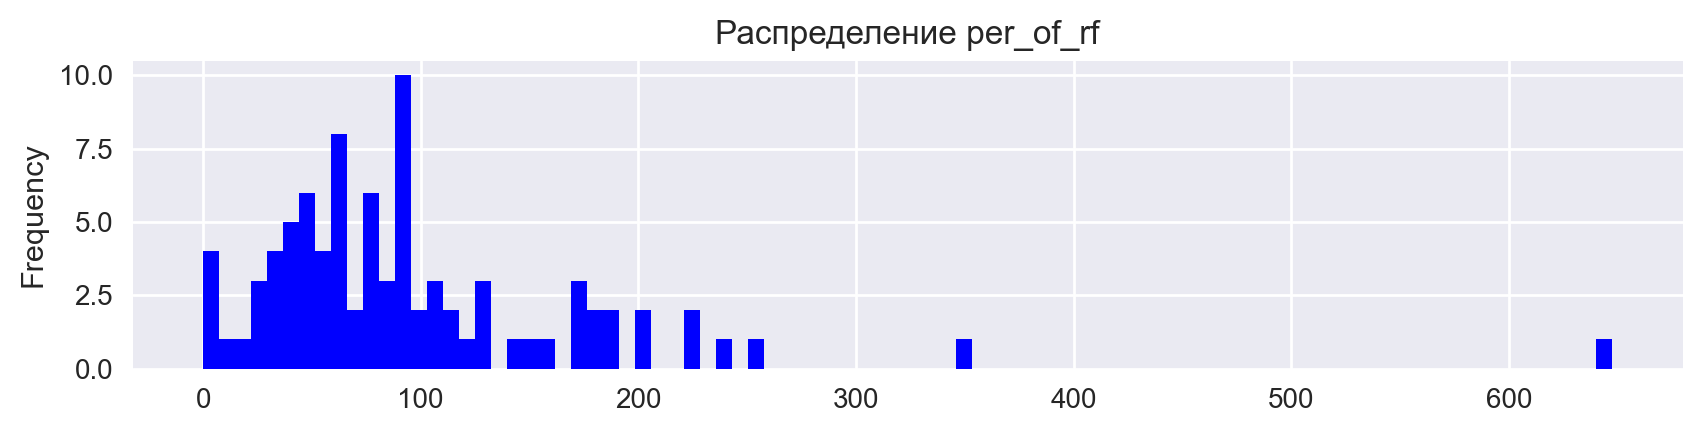

In [50]:
# выведем распределние признака per_of_rf в данных drug
feature_histogram(df=drug, feature='per_of_rf')

Теперь в таблицах пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- в данных по алкоголизму: превышения показателя региона за последний год (2018) больше 150% показателя по РФ. Признак тренда удалим.
- в данных по наркомании:
    - положительный тренд в данных + уровень выше 130% от уровня РФ
    - а также уровень показателя выше 130% от уровня РФ

In [51]:
# создадим признак bad_region в данных по алкоголизму
alco['bad_region'] = alco['per_of_rf'].apply(lambda x: 1 if x>150 else 0)

# удалим признак trend в данных по алкоголизму
alco.drop('trend', axis=1, inplace=True)

# выведем ПЛОХИЕ регионы по алкоголизму
print(alco.name)
display(alco[alco['bad_region'] == 1])

# отмечаем проблемные регионы по наркомании и выводим их
drug = data_preparation_step_3(drug, bad_trend=1, bad_per_of_rf='more', and_threshold=130, add_threshold=130)

alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения


,region,2018,per_of_rf,bad_region
2,Брянская область,82.2,159.30,1
5,Ивановская область,78.5,152.13,1
11,Орловская область,90.3,175.00,1
19,Республика Карелия,78.1,151.36,1
20,Республика Коми,107.5,208.33,1
22,Ненецкий автономный округ,181.8,352.33,1
24,Калининградская область,79.1,153.29,1
28,Псковская область,85.9,166.47,1
48,Чувашская Республика,79.0,153.10,1
49,Пермский край,95.3,184.69,1


drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)
* 'ПЛОХИЕ' регионы *


,region,2018,trend,per_of_rf,bad_region
4,Воронежская область,22.5,1,222.77,1
12,Рязанская область,17.2,1,170.30,1
56,Ульяновская область,19.1,1,189.11,1
57,Курганская область,22.5,-1,222.77,1
61,Ямало-Ненецкий автономный округ,18.9,-1,187.13,1
62,Челябинская область,20.6,0,203.96,1
65,Республика Хакасия,17.9,-1,177.23,1
66,Алтайский край,17.4,-1,172.28,1
67,Красноярский край,14.9,-1,147.52,1
68,Иркутская область,15.7,-1,155.45,1


* Всего 'ПЛОХИХ' регионов: 19 *
----------------------------------------------------------------------------------------------------


Обращают на себя внимание регионы "чемпионы" по алкоголизму (Чукотский автономный округ) и наркомании (Еврейская автономная область).

In [52]:
# правим названия признаков
data_features_rename(df=alco, prefix='alco')
data_features_rename(df=drug, prefix='drug')

alco - Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения
Размерность данных: (88, 4)


,region,alco,alco_per_of_rf,alco_bad_region
0,РФ,51.6,100.00,0
1,Белгородская область,41.3,80.04,0
2,Брянская область,82.2,159.30,1
3,Владимирская область,66.5,128.88,0
4,Воронежская область,73.4,142.25,0


drug - Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)
Размерность данных: (88, 5)


,region,drug,drug_trend,drug_per_of_rf,drug_bad_region
0,РФ,10.1,-1,100.00,0
1,Белгородская область,3.2,-1,31.68,0
2,Брянская область,6.1,-1,60.40,0
3,Владимирская область,7.8,1,77.23,0
4,Воронежская область,22.5,1,222.77,1


***

### 1.7. Валовой региональный продукт на душу населения

Данные представляют собой файл формата *.xls* и содержит следующие таблицу:
- **gross_regional_product_1996_2020** - Валовой региональный продукт на душу населения (рубль, значение показателя за год)

In [53]:
# загружаем данные
grp = pd.read_excel(io='data_provided/gross_regional_product_1996_2020.xls', header=2, skipfooter=1)
grp.rename(columns={'Unnamed: 0': 'region'}, inplace=True)

# присваиваем имя таблице
grp.name = 'gross_regional_product (grp)\nВаловой региональный продукт на душу населения (рубль, значение показателя за год)'

# производим предварительную обработку данных и выводим их
grp = data_preparation_step_1(df=grp, region='region', replacement='без')

*** Данные после первичной обработки ***
gross_regional_product (grp)
Валовой региональный продукт на душу населения (рубль, значение показателя за год)


,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,РФ,12225.0,13938.4,15371.1,26200.6,39532.3,49474.8,60611.4,74840.5,97691.9,...,317515.3,348641.5,377006.0,405147.7,449097.9,505337.7,543065.9,614333.2,646144.1,640519.0
1,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
2,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
3,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
4,Воронежская область,7651.9,8686.6,9082.1,14808.3,20365.1,24905.4,34789.6,42237.5,49530.0,...,203575.5,241947.4,262578.3,308004.7,345566.8,354657.9,374125.7,408140.7,431037.0,459629.5


Размерность: (88, 26)
Количество строк, содержащих пропуски 7
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
22,Ненецкий автономный округ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3913588.7,3685897.1,4035943.2,4329031.1,5210143.9,5964557.0,6045235.6,7296374.4,7530484.7,5206287.1
23,Архангельская область без Ненецкого АО,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,232540.7,270662.9,283264.5,310817.4,352837.9,400764.6,441961.6,493205.1,509917.0,514200.4
33,Республика Крым,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100526.4,139873.3,189916.6,201251.2,228692.9,245411.7,270363.8
38,Севастополь,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,78009.3,119384.5,211366.0,234060.8,276550.7,306891.7,295304.9
63,Ханты-Мансийский автономный округ - Югра,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1575300.0,1719109.2,1715722.4,1782617.7,1947653.2,1912836.6,2155227.7,2715827.8,2733622.7,1994630.3
64,Ямало-Ненецкий автономный округ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1820301.3,2209803.4,2544898.0,3025745.6,3336453.4,3790547.2,4571566.9,5650999.3,5710467.4,5072483.6
65,Тюменская область без округов,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,522064.8,532020.4,604921.2,564680.5,628098.5,659860.8,727930.9,872684.2,821610.6,757076.0


----------------------------------------------------------------------------------------------------


**Выводы:**
- Республика Крым и Севастополь содержат пропуски или нули до 2013 года включительно (причины понятны)
- имеем пропуски и нули снова в проблемных регионах (Тюменская и Архангельская области с их АО)

In [54]:
# производим второй этап обработки данных
grp = data_preparation_step_2(df=grp, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)

*** Данные после второго этапа обработки ***
gross_regional_product (grp)
Валовой региональный продукт на душу населения (рубль, значение показателя за год)


,region,2020,trend,per_of_rf
0,РФ,640519.0,1,100.00
1,Белгородская область,646569.0,1,100.94
2,Брянская область,347204.5,1,54.21
3,Владимирская область,410443.6,1,64.08
4,Воронежская область,459629.5,1,71.76


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 66 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------


Тренд везде положительный, плохие регионы по этому показателю не отобрать. Признак тренда можно не учитывать и удалить его.

gross_regional_product (grp)
Валовой региональный продукт на душу населения (рубль, значение показателя за год)


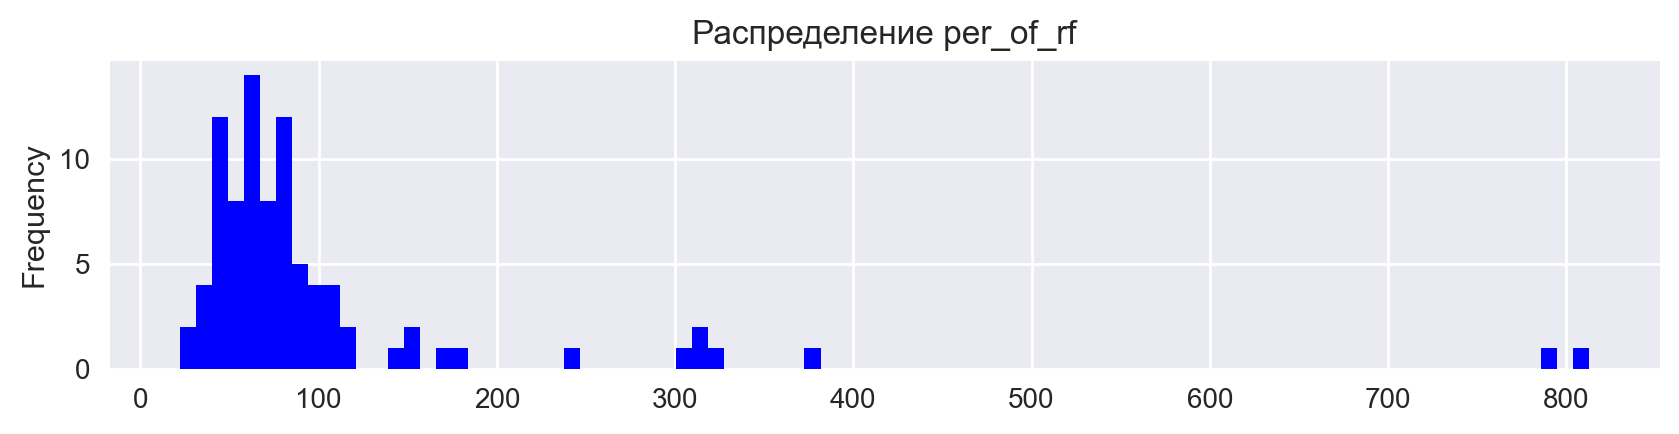

In [55]:
# выведем распределние признака per_of_rf в данных grp
feature_histogram(df=grp, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- Валовой региональный продукт на душу населения менее 50% от уровня по РФ (для корректной работы функции отметим тренд =1, но учитывать его не будем)

In [56]:
# отмечаем проблемные регионы
grp = data_preparation_step_3(grp, bad_trend=1, bad_per_of_rf='less', and_threshold=50, add_threshold=50)

gross_regional_product (grp)
Валовой региональный продукт на душу населения (рубль, значение показателя за год)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
5,Ивановская область,273821.5,1,42.75,1
31,Республика Адыгея,309184.1,1,48.27,1
33,Республика Крым,270363.8,1,42.21,1
38,Севастополь,295304.9,1,46.10,1
39,Республика Дагестан,239640.7,1,37.41,1
40,Республика Ингушетия,142199.7,1,22.20,1
41,Кабардино-Балкарская Республика,210674.1,1,32.89,1
42,Карачаево-Черкесская Республика,207471.5,1,32.39,1
43,Республика Северная Осетия-Алания,267814.4,1,41.81,1
44,Чеченская Республика,171029.5,1,26.70,1


* Всего 'ПЛОХИХ' регионов: 19 *
----------------------------------------------------------------------------------------------------


По валовому региональному продукту на душу населения хуже всего дело обстоит в Республике Ингушетия, Чеченской республике. Да и вообще, регионы Северного Кавказа показывают не лучший уровень данного показателя.

Теперь подправим названия признаков, используя префикс.

In [57]:
# удалим признак trend
grp.drop('trend', axis=1, inplace=True)

# правим названия признаков
data_features_rename(df=grp, prefix='grp')

gross_regional_product (grp)
Валовой региональный продукт на душу населения (рубль, значение показателя за год)
Размерность данных: (88, 4)


,region,grp,grp_per_of_rf,grp_bad_region
0,РФ,640519.0,100.00,0
1,Белгородская область,646569.0,100.94,0
2,Брянская область,347204.5,54.21,0
3,Владимирская область,410443.6,64.08,0
4,Воронежская область,459629.5,71.76,0


***

### 1.8. Жилищные условия

Данные представляют собой файл формата *.xlsx* и содержат следующие таблицы:
- **housing_cond** - Характеристика жилищных условий домохозяйств, % от всех домохозяйств
- **housing_intent** - Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств      

Данные представлены только за 2020 год, следовательно тренд учитывать не будем.

Данных в таблицах слишком много. Наша основная задача - какие регионы наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения. Исходя из этого оставим только следующие признаки:
- в таблице **housing_cond**: *'в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность'*, *'Размер жилой площади в расчете на члена домохозяйства'*
- в таблице **housing_intent**: *'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания'*

При попытке стандартизировать названия регионов вылезают проблемы по следующими субъектами: 'Владимирская область',  'Воронежская область',  'Вологодская область', 'Волгоградская область'. Причина - непонятна (кодировка? или может латиница в буквах а,р,с,т,о,В ?).

Напишем функцию для обновления названий проблемных регионов представленного датасета.

In [58]:
def housing_rename_regions(df):
    ''''
    Функция принимает на вход датафрейм и меняет название указанных регионов на кирилицу.
    Возвращается обновленный датафрейм.
    '''
    
    df.replace({'Bладимирская область': 'Владимирская'}, inplace=True)
    df.replace({'Bолгоградская область': 'Волгоградская'}, inplace=True)
    df.replace({'Bологодская область': 'Вологодская'}, inplace=True)
    df.replace({'Bоронежская область': 'Воронежская'}, inplace=True)

    return df

In [59]:
# загружаем данные, переименовываем признаки, удаляем мусор
housing_cond = pd.read_excel(io='data_provided/housing_2020.xlsx', sheet_name=0, usecols='A,E,H')
housing_cond.columns = ['region','constraint','living_area'] 
housing_intent = pd.read_excel(io='data_provided/housing_2020.xlsx', sheet_name=1, usecols='A,F')
housing_intent.columns = ['region','very_bad_living_area']
housing_intent.drop([94,95], inplace = True)

# переименовываем регионы с неправильным написанием
housing_cond = housing_rename_regions(housing_cond)
housing_intent = housing_rename_regions(housing_intent)

# присваиваем имена таблицам
housing_cond.name = 'housing_cond'
housing_intent.name = 'housing_intent'

# производим предварительную обработку данных и выводим их
housing_cond = data_preparation_step_1(df=housing_cond, region='region', replacement='')
housing_intent = data_preparation_step_1(df=housing_intent, region='region', replacement='')

*** Данные после первичной обработки ***
housing_cond


,region,constraint,living_area
0,РФ,3.8,16.9
1,Белгородская область,2.0,17.8
2,Брянская область,0.6,24.1
3,Владимирская область,2.5,16.1
4,Воронежская область,1.6,19.9


Размерность: (86, 3)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
housing_intent


,region,very_bad_living_area
0,РФ,0.6
1,Белгородская область,0.4
2,Брянская область,0.0
3,Владимирская область,0.0
4,Воронежская область,0.1


Размерность: (86, 2)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


И снова у нас нет значений в регионах Архангельская и Тюменская области. Пока добавим их в таблицы с пропусками, потом будем думать, что с этим делать.

In [60]:
# добавляем пропущенные регионы в обе таблицы

housing_cond.loc[len(housing_cond.index)] = ['Архангельская область', np.nan, np.nan]
housing_cond.loc[len(housing_cond.index)] = ['Тюменская область', np.nan, np.nan]

housing_intent.loc[len(housing_intent.index)] = ['Архангельская область', np.nan]
housing_intent.loc[len(housing_intent.index)] = ['Тюменская область', np.nan]

Теперь из двух таблиц сделаем три, чтобы их обработать нашими функциями.

In [61]:
# создадим новые таблицы
constraint = housing_cond[['region', 'constraint']]
living_area = housing_cond[['region', 'living_area']]
very_bad_living_area = housing_intent

# присвоим имена новым таблицам
constraint.name = 'constraint - % домохозяйств, указавших, что при проживании испытывают большую стесненность'
living_area.name = 'living_area - Размер жилой площади в расчете на члена домохозяйства'
very_bad_living_area.name = 'very_bad_living_area - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания'

In [62]:
# производим второй этап обработки данных
constraint = data_preparation_step_2(constraint, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
living_area = data_preparation_step_2(living_area, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)
very_bad_living_area = data_preparation_step_2(very_bad_living_area, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
constraint - % домохозяйств, указавших, что при проживании испытывают большую стесненность


,region,constraint,trend,per_of_rf
0,РФ,3.8,0,100.00
1,Белгородская область,2.0,0,52.63
2,Брянская область,0.6,0,15.79
3,Владимирская область,2.5,0,65.79
4,Воронежская область,1.6,0,42.11


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,constraint,trend,per_of_rf
86,Архангельская область,NaN,0,NaN
87,Тюменская область,NaN,0,NaN


* Данные с ПЛОХИМ трендом *


,region,constraint,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 36 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,constraint,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
living_area - Размер жилой площади в расчете на члена домохозяйства


,region,living_area,trend,per_of_rf
0,РФ,16.9,0,100.00
1,Белгородская область,17.8,0,105.33
2,Брянская область,24.1,0,142.60
3,Владимирская область,16.1,0,95.27
4,Воронежская область,19.9,0,117.75


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,living_area,trend,per_of_rf
86,Архангельская область,NaN,0,NaN
87,Тюменская область,NaN,0,NaN


* Данные с ПЛОХИМ трендом *


,region,living_area,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 38 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,living_area,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
very_bad_living_area - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания


,region,very_bad_living_area,trend,per_of_rf
0,РФ,0.6,0,100.00
1,Белгородская область,0.4,0,66.67
2,Брянская область,0.0,0,0.00
3,Владимирская область,0.0,0,0.00
4,Воронежская область,0.1,0,16.67


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,very_bad_living_area,trend,per_of_rf
86,Архангельская область,NaN,0,NaN
87,Тюменская область,NaN,0,NaN


* Данные с ПЛОХИМ трендом *


,region,very_bad_living_area,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 33 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,very_bad_living_area,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------


Так как данные представлены за один год, тренд получился равен 0. Мы его потом удалим. Архангельская и Тюменская области с пропусками - пока не трогаем.

Визуализируем распределение признака *per_of_rf* в таблицах.

constraint - % домохозяйств, указавших, что при проживании испытывают большую стесненность


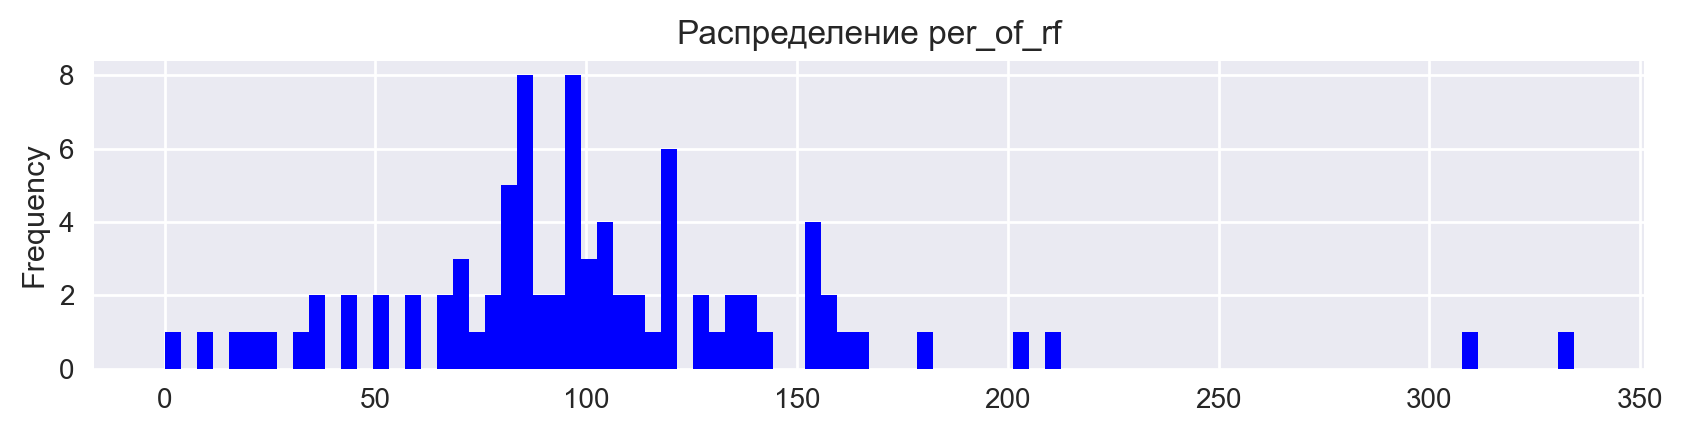

In [63]:
# выведем распределние признака per_of_rf в данных constraint
feature_histogram(df=constraint, feature='per_of_rf')

living_area - Размер жилой площади в расчете на члена домохозяйства


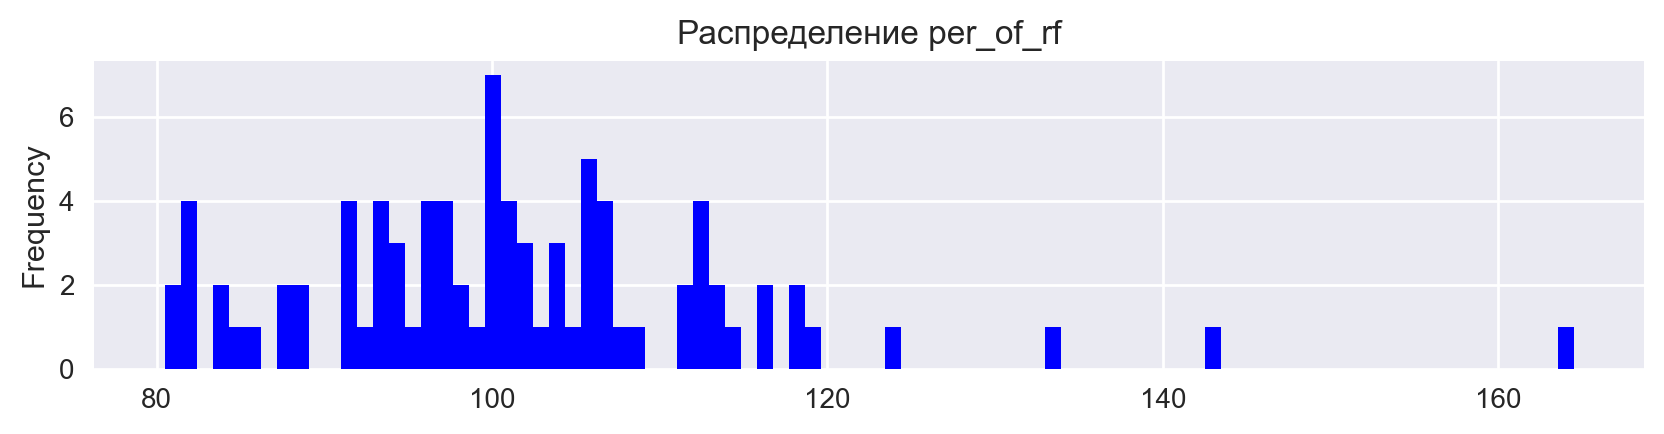

In [64]:
# выведем распределние признака per_of_rf в данных living_area
feature_histogram(df=living_area, feature='per_of_rf')

very_bad_living_area - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания


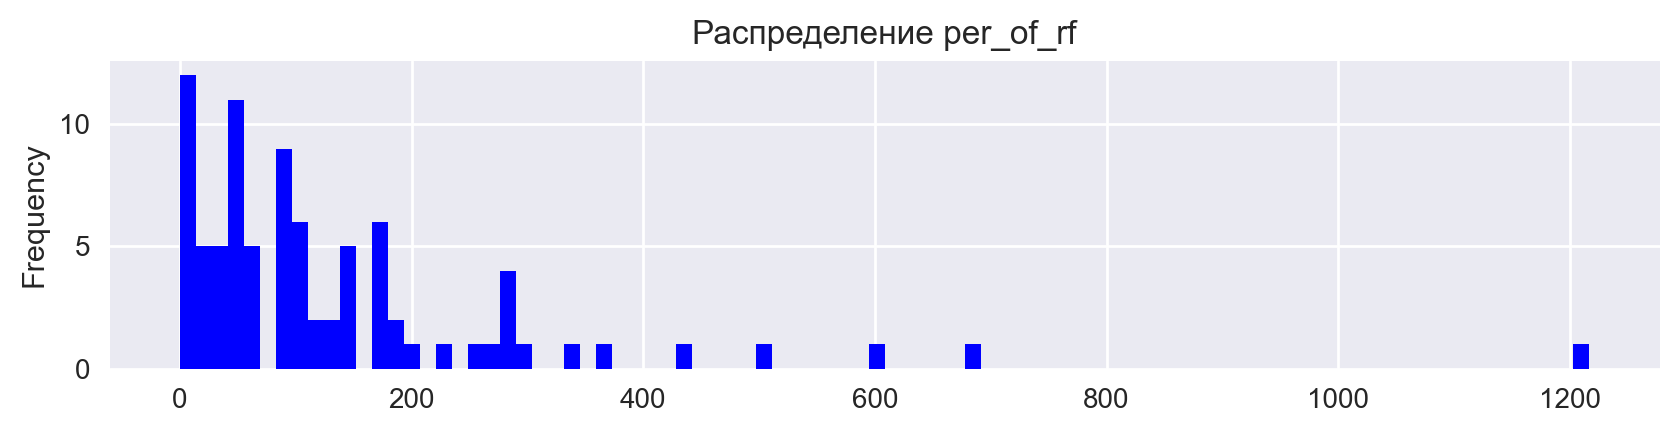

In [65]:
# выведем распределние признака per_of_rf в данных very_bad_living_area
feature_histogram(df=very_bad_living_area, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- для **constraint** значение показателя превышет 150% от уровня РФ в целом
- для **living_area** значение показателя менее 90% от уровня РФ в целом
- для **very_bad_living_area** значение показателя превышет 200% от уровня РФ в целом

In [66]:
# отмечаем проблемные регионы
constraint = data_preparation_step_3(constraint, bad_trend=0, bad_per_of_rf='more', and_threshold=150, add_threshold=150)
living_area = data_preparation_step_3(living_area, bad_trend=0, bad_per_of_rf='less', and_threshold=90, add_threshold=90)
very_bad_living_area = data_preparation_step_3(very_bad_living_area, bad_trend=0, bad_per_of_rf='more', and_threshold=200, add_threshold=200)

constraint - % домохозяйств, указавших, что при проживании испытывают большую стесненность
* 'ПЛОХИЕ' регионы *


,region,constraint,trend,per_of_rf,bad_region
11,Орловская область,6.3,0,165.79,1
19,Республика Карелия,6.1,0,160.53,1
24,Калининградская область,5.9,0,155.26,1
28,Псковская область,6.0,0,157.89,1
37,Севастополь,6.8,0,178.95,1
41,Карачаево-Черкесская Республика,5.8,0,152.63,1
42,Республика Северная Осетия-Алания,12.7,0,334.21,1
46,Республика Марий Эл,5.8,0,152.63,1
50,Чувашская Республика,8.0,0,210.53,1
66,Республика Тыва,7.7,0,202.63,1


* Всего 'ПЛОХИХ' регионов: 13 *
----------------------------------------------------------------------------------------------------
living_area - Размер жилой площади в расчете на члена домохозяйства
* 'ПЛОХИЕ' регионы *


,region,living_area,trend,per_of_rf,bad_region
7,Костромская область,14.5,0,85.80,1
10,Московская область,14.8,0,87.57,1
18,Москва,13.8,0,81.66,1
28,Псковская область,15.0,0,88.76,1
37,Севастополь,13.7,0,81.07,1
49,Удмуртская Республика,14.8,0,87.57,1
50,Чувашская Республика,14.2,0,84.02,1
52,Кировская область,14.9,0,88.17,1
62,Ханты-Мансийский автономный округ - Югра,13.9,0,82.25,1
65,Республика Алтай,14.4,0,85.21,1


* Всего 'ПЛОХИХ' регионов: 14 *
----------------------------------------------------------------------------------------------------
very_bad_living_area - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания
* 'ПЛОХИЕ' регионы *


,region,very_bad_living_area,trend,per_of_rf,bad_region
19,Республика Карелия,1.7,0,283.33,1
20,Республика Коми,3.6,0,600.00,1
22,Ненецкий автономный округ,4.1,0,683.33,1
24,Калининградская область,1.5,0,250.00,1
25,Ленинградская область,1.6,0,266.67,1
30,Республика Адыгея,3.0,0,500.00,1
41,Карачаево-Черкесская Республика,1.7,0,283.33,1
42,Республика Северная Осетия-Алания,2.2,0,366.67,1
57,Саратовская область,1.7,0,283.33,1
65,Республика Алтай,1.8,0,300.00,1


* Всего 'ПЛОХИХ' регионов: 15 *
----------------------------------------------------------------------------------------------------


Интересно, что в число аутсайдеров по показателю жилой площади на члена домохозяйства входит Москва, что вполне объяснимо, но характеризует данный регион по этому показателю как неблагополучный. Ну и Республика Тыва резко выделяется на фоне других плохих регионов.

Теперь подправим названия признаков, используя префикс.

In [67]:
# удалим признак trend
constraint.drop('trend', axis=1, inplace=True)
living_area.drop('trend', axis=1, inplace=True)
very_bad_living_area.drop('trend', axis=1, inplace=True)

# правим названия признаков
data_features_rename(df=constraint, prefix='constraint')
data_features_rename(df=living_area, prefix='living_area')
data_features_rename(df=very_bad_living_area, prefix='very_bad_living_area')

constraint - % домохозяйств, указавших, что при проживании испытывают большую стесненность
Размерность данных: (88, 4)


,region,constraint,constraint_per_of_rf,constraint_bad_region
0,РФ,3.8,100.00,0
1,Белгородская область,2.0,52.63,0
2,Брянская область,0.6,15.79,0
3,Владимирская область,2.5,65.79,0
4,Воронежская область,1.6,42.11,0


living_area - Размер жилой площади в расчете на члена домохозяйства
Размерность данных: (88, 4)


,region,living_area,living_area_per_of_rf,living_area_bad_region
0,РФ,16.9,100.00,0
1,Белгородская область,17.8,105.33,0
2,Брянская область,24.1,142.60,0
3,Владимирская область,16.1,95.27,0
4,Воронежская область,19.9,117.75,0


very_bad_living_area - % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания
Размерность данных: (88, 4)


,region,very_bad_living_area,very_bad_living_area_per_of_rf,very_bad_living_area_bad_region
0,РФ,0.6,100.00,0
1,Белгородская область,0.4,66.67,0
2,Брянская область,0.0,0.00,0
3,Владимирская область,0.0,0.00,0
4,Воронежская область,0.1,16.67,0


***

### 1.9. Заболеваемость

Данные представляют собой файл формата *.xls*, который содержит таблицу:
- **morbidity_2005_2020_age_disease** - Заболеваемость с диагнозом, установленным впервые в жизни, проживающих в районе обслуживания лечебного учреждения, на 100 тыс.человек населения

Данные представлены за период 2005-2016 годы, хотя в паспорте и названии файла речь идет о периоде 2005-2020 (ошибка?).    
И еще **проблема** - **дубликаты регионов**: разведывательный анализ показал (я не буду его приводить с целью не перегружать ноутбук лишней информацией), что 13 регионов дублируются: 'Чеченская Республика','Кабардино-Балкарская Республика','Волгоградская область','Ростовская область','Республика Калмыкия','Республика Адыгея','Республика Дагестан','Республика Ингушетия','Карачаево-Черкесская Республика','Краснодарский край','Республика Северная Осетия-Алания','Ставропольский край','Астраханская область'    
В указанных выше регионах в одной строке представлены данные за период 2005-2013, а в дублирующей строке за период 2015-2016, данные за 2014 отсутствуют. Необходимо сложить эти строки, чтобы получилась одна.

Надо выделить данные по *общей заболеваемости*, а также данные, которые говорят о социальном неблагополучии региона.     
Я согласен с [DKudryavtsev](https://github.com/DKudryavtsev/RussiaRegions/tree/main), что необходимо выеделить следующие данные: 
- *Врожденные аномалии (пороки развития), деформации и хромосомные нарушения*, 
- Психические расстройства и расстройства поведения*,
- *Беременность, роды и послеродовой период (0-14лет)*,
     
но я бы добавил еще 
- *Отдельные состояния, возникающие в перинатальном периоде*, 

т.к. перинатальный период — период с 22 полной недели (154-го дня) внутриутробной жизни плода по 7-й день включительно (168 часов) внеутробной жизни [источник](https://ru.wikipedia.org/wiki/Патологическая_анатомия_перинатального_периода).

Напишем функцию для обработки дублирующихся регионов.

In [68]:
def duplicate_regions_processing(df, replacement):
    ''''
    Функция принимает на вход датафрейм и параметр замены выражений в скобках для 
    функции data_preparation_step_1, производит его первичную обработку с помощью
    функции data_preparation_step_1, затем убирает дублирующиеся регионы из данных,
    суммируя значения их строк. Возращает обновленный датафрейм.
    '''
    # сохраним имя таблицы
    df_copy_name = df.name
    # производим предварительную обработку данных и выводим их
    df = data_preparation_step_1(df=df, region='region', replacement=replacement)
    # получим список дублирующихся регионов
    dubl_regions_list = df.region.value_counts()[:13].index.to_list()
    # создадим признак дублирющегося региона
    df['dubl_regions'] = df['region'].apply(lambda x: 1 if x in dubl_regions_list else 0)
    # создадим маску дублирющегося региона
    mask = df['dubl_regions'] == 1
    # создадим новую таблицу с дублирующимися регионами
    dubl_regions = df[mask].sort_values(by='region').reset_index().drop(['dubl_regions', 'index'], axis=1)
    # создадим новую таблицу без дубликатов регионов и с суммироваными значениями по годам, сохранив NaN
    dubl_regions_processing = dubl_regions.groupby('region').agg('sum').reset_index().replace(0, np.nan)
    # выделим недублированные регионы с данными из входящей таблицы
    df_no_dubl = df[df['dubl_regions'] == 0]
    # заменим исходную таблицу сложив таблицу без дублей и таблицу с обработанными дублями
    df = pd.concat([df_no_dubl.drop('dubl_regions', axis=1), dubl_regions_processing]).reset_index().drop('index', axis=1)
    # восстановим имя таблицы
    df.name = df_copy_name
    
    return df


In [69]:
# загружаем данные, переименовываем признаки
morbidity = pd.read_excel('data_provided/morbidity_2005_2020_age_disease.xls', header=2)
morbidity.rename({'Unnamed: 0': 'region', 'Unnamed: 1': 'type', 'Unnamed: 2': 'age'}, axis=1, inplace=True)

# выделим необходимые данные в отделные таблицы

# Общая заболеваемость
mask = ((morbidity['type'] == 'Все заболевания') & (morbidity['age'] ==  'Всего'))
general_morbidity = morbidity[mask].copy()
general_morbidity.name = 'general_morbidity - Общая заболеваемость'
general_morbidity.drop(['type','age'], axis=1, inplace=True)

# Врожденные пороки развития
mask = ((morbidity['type'] == 'Врожденные аномалии (пороки развития), деформации и хромосомные нарушения')& (morbidity['age'] ==  'Всего'))
congenital_malformation = morbidity[mask].copy()
congenital_malformation.name = 'congenital_malformation - Врожденные пороки развития'
congenital_malformation.drop(['type','age'], axis=1, inplace=True)

# Психические расстройства и расстройства поведения
mask = ((morbidity['type'] == 'Психические расстройства и расстройства поведения') & (morbidity['age'] ==  'Всего'))
psychosis = morbidity[mask].copy()
psychosis.name = 'psychosis - Психические расстройства и расстройства поведения'
psychosis.drop(['type','age'], axis=1, inplace=True)

# Подростковая беременность (до 14 лет)
mask = ((morbidity['type'] == 'Беременность, роды и послеродовой период') & (morbidity['age'] ==  '0-14 лет'))
teenage_pregnancy = morbidity[mask].copy()
teenage_pregnancy.name = 'teenage_pregnancy - Подростковая беременность (до 14 лет)'
teenage_pregnancy.drop(['type','age'], axis=1, inplace=True)

# Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)
mask = ((morbidity['type'] == 'Отдельные состояния, возникающие в перинатальном периоде') & (morbidity['age'] ==  '0-14 лет'))
conditions_in_perinatal = morbidity[mask].copy()
conditions_in_perinatal.name = 'conditions_in_perinatal - Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)'
conditions_in_perinatal.drop(['type','age'], axis=1, inplace=True)

In [70]:
%%capture
# производим предварительную обработку данных, в т.ч. дубликатов
general_morbidity = duplicate_regions_processing(general_morbidity, replacement='')
congenital_malformation = duplicate_regions_processing(congenital_malformation, replacement='')
psychosis = duplicate_regions_processing(psychosis, replacement='')
teenage_pregnancy = duplicate_regions_processing(teenage_pregnancy, replacement='')
conditions_in_perinatal = duplicate_regions_processing(conditions_in_perinatal, replacement='')

In [71]:
# производим второй этап обработки данных
general_morbidity = data_preparation_step_2(df=general_morbidity, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
congenital_malformation = data_preparation_step_2(df=congenital_malformation, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
psychosis = data_preparation_step_2(df=psychosis, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
teenage_pregnancy = data_preparation_step_2(df=teenage_pregnancy, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
conditions_in_perinatal = data_preparation_step_2(df=conditions_in_perinatal, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
general_morbidity - Общая заболеваемость


,region,2016,trend,per_of_rf
0,РФ,78602.1,1,100.00
1,Белгородская область,74637.4,-1,94.96
2,Брянская область,77439.0,-1,98.52
3,Владимирская область,94163.6,1,119.80
4,Воронежская область,55009.9,1,69.99


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,1,NaN
49,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2016,trend,per_of_rf
0,РФ,78602.1,1,100.00
3,Владимирская область,94163.6,1,119.80
4,Воронежская область,55009.9,1,69.99
5,Ивановская область,88473.5,1,112.56
6,Калужская область,75548.6,1,96.12
7,Костромская область,71386.8,1,90.82
10,Московская область,70054.0,1,89.12
11,Орловская область,94883.0,1,120.71
12,Рязанская область,70384.8,1,89.55
15,Тверская область,86566.6,1,110.13


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 40 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2016,trend,per_of_rf
3,Владимирская область,94163.6,1,119.80
5,Ивановская область,88473.5,1,112.56
11,Орловская область,94883.0,1,120.71
15,Тверская область,86566.6,1,110.13
19,Республика Карелия,112365.5,1,142.95
20,Республика Коми,111709.0,1,142.12
23,Вологодская область,91608.4,1,116.55
24,Калининградская область,82758.6,1,105.29
26,Мурманская область,87319.0,1,111.09
29,Санкт-Петербург,101498.4,1,129.13


Всего таких регионов: 26 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
congenital_malformation - Врожденные пороки развития


,region,2016,trend,per_of_rf
0,РФ,206.0,1,100.00
1,Белгородская область,136.2,1,66.12
2,Брянская область,192.1,1,93.25
3,Владимирская область,210.4,1,102.14
4,Воронежская область,98.4,1,47.77


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,-1,NaN
49,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2016,trend,per_of_rf
0,РФ,206.0,1,100.00
1,Белгородская область,136.2,1,66.12
2,Брянская область,192.1,1,93.25
3,Владимирская область,210.4,1,102.14
4,Воронежская область,98.4,1,47.77
7,Костромская область,134.9,1,65.49
8,Курская область,139.5,1,67.72
10,Московская область,90.1,1,43.74
11,Орловская область,315.4,1,153.11
12,Рязанская область,298.4,1,144.85


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 36 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2016,trend,per_of_rf
3,Владимирская область,210.4,1,102.14
11,Орловская область,315.4,1,153.11
12,Рязанская область,298.4,1,144.85
13,Смоленская область,321.6,1,156.12
19,Республика Карелия,442.3,1,214.71
20,Республика Коми,298.9,1,145.10
22,Ненецкий автономный округ,853.1,1,414.13
24,Калининградская область,388.8,1,188.74
29,Санкт-Петербург,254.5,1,123.54
30,Архангельская область без Ненецкого АО,458.9,1,222.77


Всего таких регионов: 30 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
psychosis - Психические расстройства и расстройства поведения


,region,2016,trend,per_of_rf
0,РФ,442.9,-1,100.00
1,Белгородская область,388.2,-1,87.65
2,Брянская область,411.3,-1,92.87
3,Владимирская область,572.7,-1,129.31
4,Воронежская область,583.5,-1,131.75


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,-1,NaN
49,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2016,trend,per_of_rf
30,Архангельская область без Ненецкого АО,685.3,1,154.73
34,Республика Марий Эл,662.5,1,149.58
55,Республика Тыва,389.7,1,87.99
73,Еврейская автономная область,635.7,1,143.53
82,Республика Ингушетия,106.0,1,23.93
86,Ставропольский край,246.4,1,55.63


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 44 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2016,trend,per_of_rf
30,Архангельская область без Ненецкого АО,685.3,1,154.73
34,Республика Марий Эл,662.5,1,149.58
73,Еврейская автономная область,635.7,1,143.53


Всего таких регионов: 3 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
teenage_pregnancy - Подростковая беременность (до 14 лет)


,region,2016,trend,per_of_rf
0,РФ,15.5,-1,100.00
1,Белгородская область,0.0,-1,0.00
2,Брянская область,0.0,-1,0.00
3,Владимирская область,22.5,1,145.16
4,Воронежская область,4.2,1,27.10


Размерность: (88, 4)
Количество строк, содержащих пропуски 11
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,1,NaN
49,Тюменская область,NaN,-1,NaN
75,Астраханская область,NaN,1,NaN
76,Волгоградская область,NaN,-1,NaN
78,Карачаево-Черкесская Республика,NaN,0,NaN
80,Республика Адыгея,NaN,-1,NaN
81,Республика Дагестан,NaN,0,NaN
82,Республика Ингушетия,NaN,0,NaN
83,Республика Калмыкия,NaN,0,NaN
84,Республика Северная Осетия-Алания,NaN,1,NaN


* Данные с ПЛОХИМ трендом *


,region,2016,trend,per_of_rf
3,Владимирская область,22.5,1,145.16
4,Воронежская область,4.2,1,27.10
16,Тульская область,16.5,1,106.45
17,Ярославская область,624.4,1,4028.39
19,Республика Карелия,31.8,1,205.16
20,Республика Коми,42.1,1,271.61
21,Архангельская область,NaN,1,NaN
23,Вологодская область,3.3,1,21.29
26,Мурманская область,20.4,1,131.61
27,Новгородская область,14.0,1,90.32


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 19 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2016,trend,per_of_rf
3,Владимирская область,22.5,1,145.16
16,Тульская область,16.5,1,106.45
17,Ярославская область,624.4,1,4028.39
19,Республика Карелия,31.8,1,205.16
20,Республика Коми,42.1,1,271.61
26,Мурманская область,20.4,1,131.61
32,Севастополь,23.4,1,150.97
36,Республика Татарстан,114.0,1,735.48
39,Пермский край,46.4,1,299.35
42,Оренбургская область,23.5,1,151.61


Всего таких регионов: 15 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
conditions_in_perinatal - Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)


,region,2016,trend,per_of_rf
0,РФ,2052.3,-1,100.00
1,Белгородская область,2424.0,-1,118.11
2,Брянская область,519.8,-1,25.33
3,Владимирская область,1904.7,-1,92.81
4,Воронежская область,1597.9,-1,77.86


Размерность: (88, 4)
Количество строк, содержащих пропуски 2
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,1,NaN
49,Тюменская область,NaN,-1,NaN


* Данные с ПЛОХИМ трендом *


,region,2016,trend,per_of_rf
21,Архангельская область,NaN,1,NaN
28,Псковская область,4145.0,1,201.97
36,Республика Татарстан,4939.0,1,240.66
55,Республика Тыва,5311.9,1,258.83
62,Омская область,2741.1,1,133.56
77,Кабардино-Балкарская Республика,2332.2,1,113.64
80,Республика Адыгея,2535.1,1,123.52
81,Республика Дагестан,2384.3,1,116.18
87,Чеченская Республика,846.7,1,41.26


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 36 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2016,trend,per_of_rf
28,Псковская область,4145.0,1,201.97
36,Республика Татарстан,4939.0,1,240.66
55,Республика Тыва,5311.9,1,258.83
62,Омская область,2741.1,1,133.56
77,Кабардино-Балкарская Республика,2332.2,1,113.64
80,Республика Адыгея,2535.1,1,123.52
81,Республика Дагестан,2384.3,1,116.18


Всего таких регионов: 7 *
----------------------------------------------------------------------------------------------------


Архангельская и Тюменская области содержат пропуски в данных за последний представленный год. Расчитать их точно не выйдет, пока оставляем и не трогаем. Отмечается рост общей заболеваемости и врожденных пороков в большинстве регионов. Тренд по психическим расстройствам положителен только в 6 регионах. Довольно много регионов с положительным трендом в показателе подростковой беременности, ОЧЕНЬ сильно выделяется Ярославская область, в то же время в 11 регионах данных за 2016 год нет, из них 7 регионов - это Северный Кавказ, что вероятно и объясняет отсутствие этих данных (строгие обычаи и воспитание молодежи). Положительный тренд по отдельным состояниям в перинатальном периоде отмечается в 9 регионах. 

general_morbidity - Общая заболеваемость


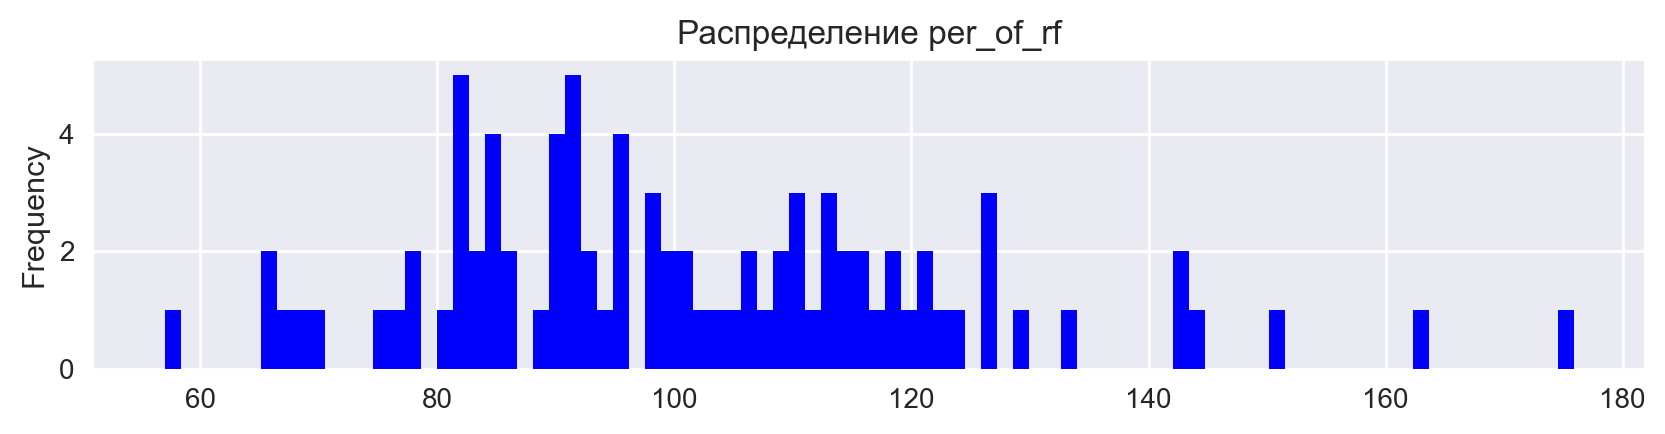

In [72]:
# выведем распределние признака per_of_rf в данных general_morbidity
feature_histogram(df=general_morbidity, feature='per_of_rf')

congenital_malformation - Врожденные пороки развития


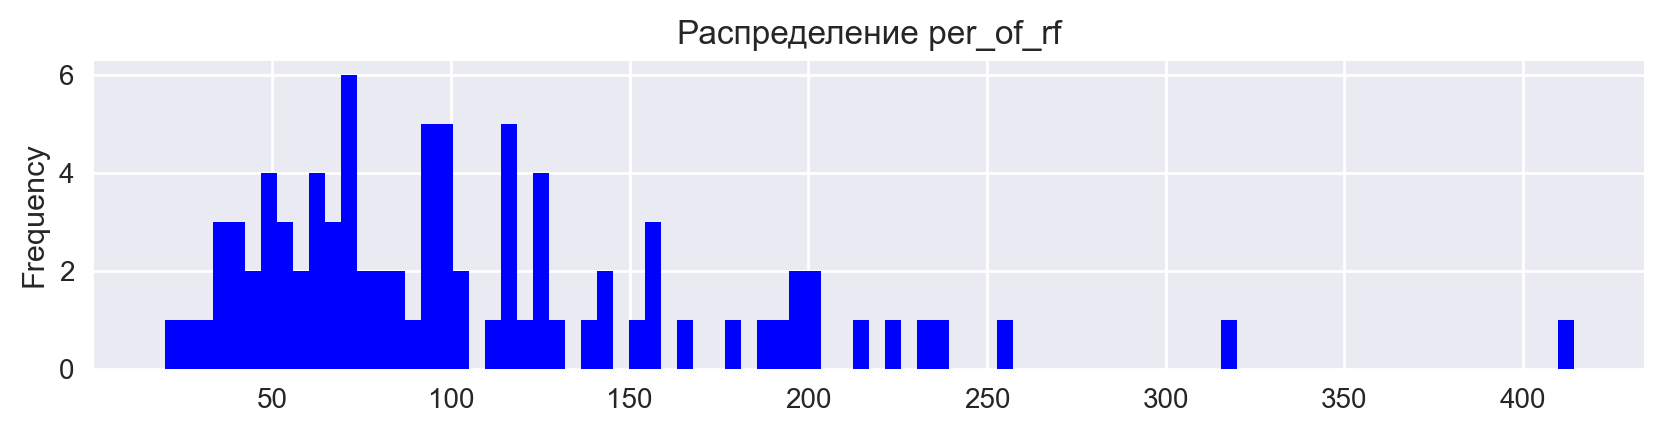

In [73]:
# выведем распределние признака per_of_rf в данных congenital_malformation
feature_histogram(df=congenital_malformation, feature='per_of_rf')

psychosis - Психические расстройства и расстройства поведения


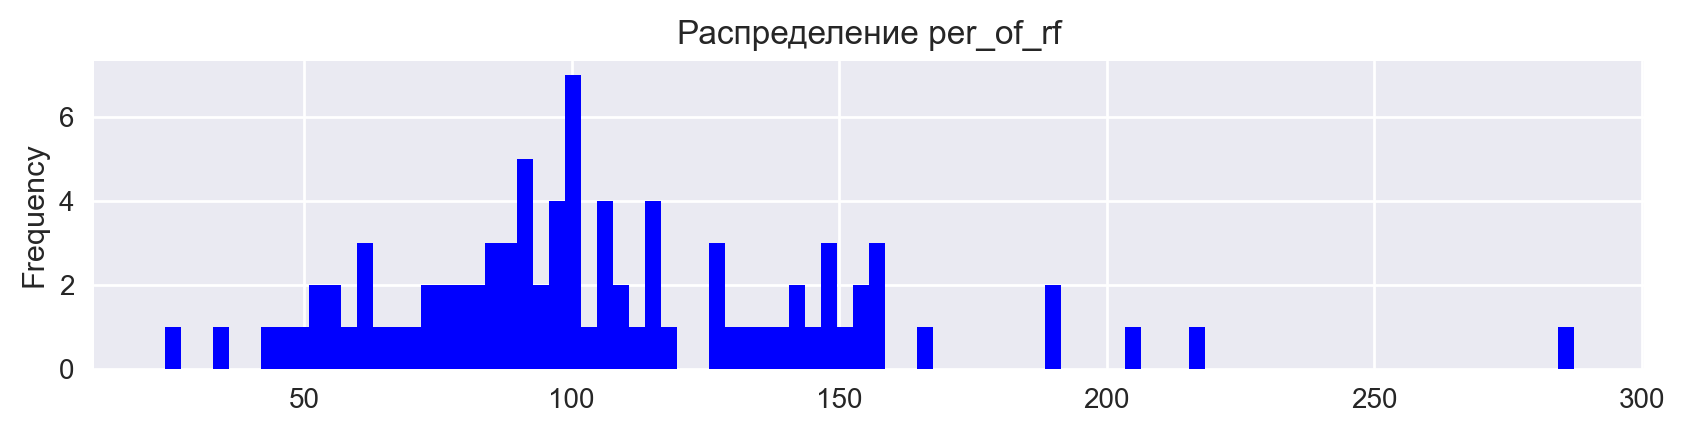

In [74]:
# выведем распределние признака per_of_rf в данных psychosis
feature_histogram(df=psychosis, feature='per_of_rf')

teenage_pregnancy - Подростковая беременность (до 14 лет)


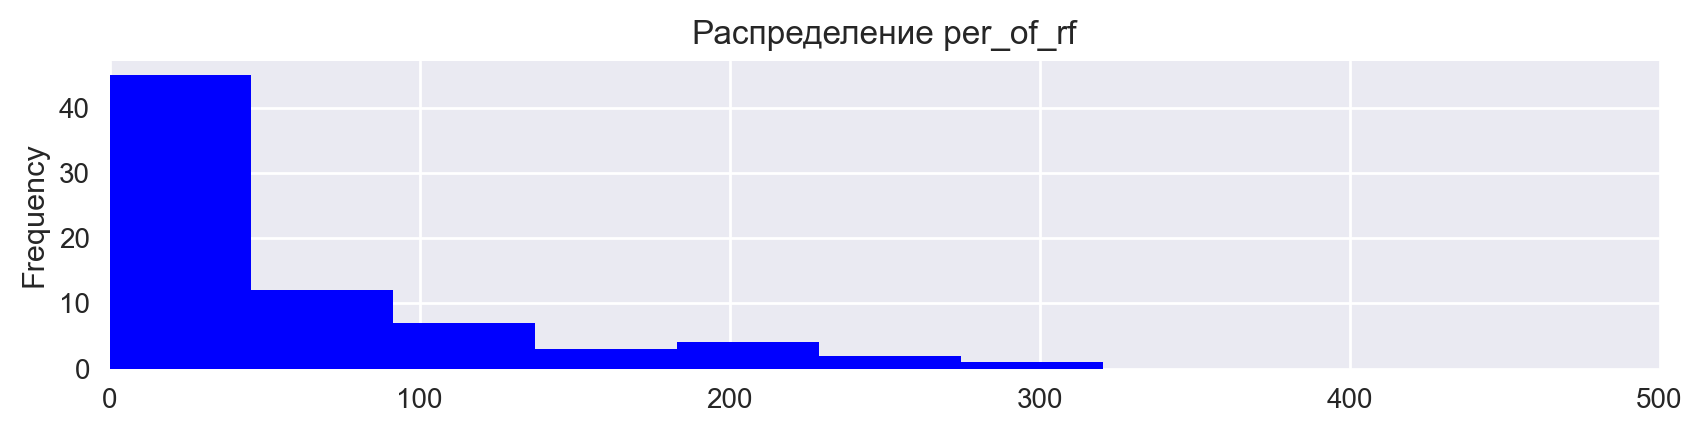

In [75]:
# выведем распределние признака per_of_rf в данных teenage_pregnancy
feature_histogram(df=teenage_pregnancy, feature='per_of_rf', min_x=0, max_x=500)

conditions_in_perinatal - Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)


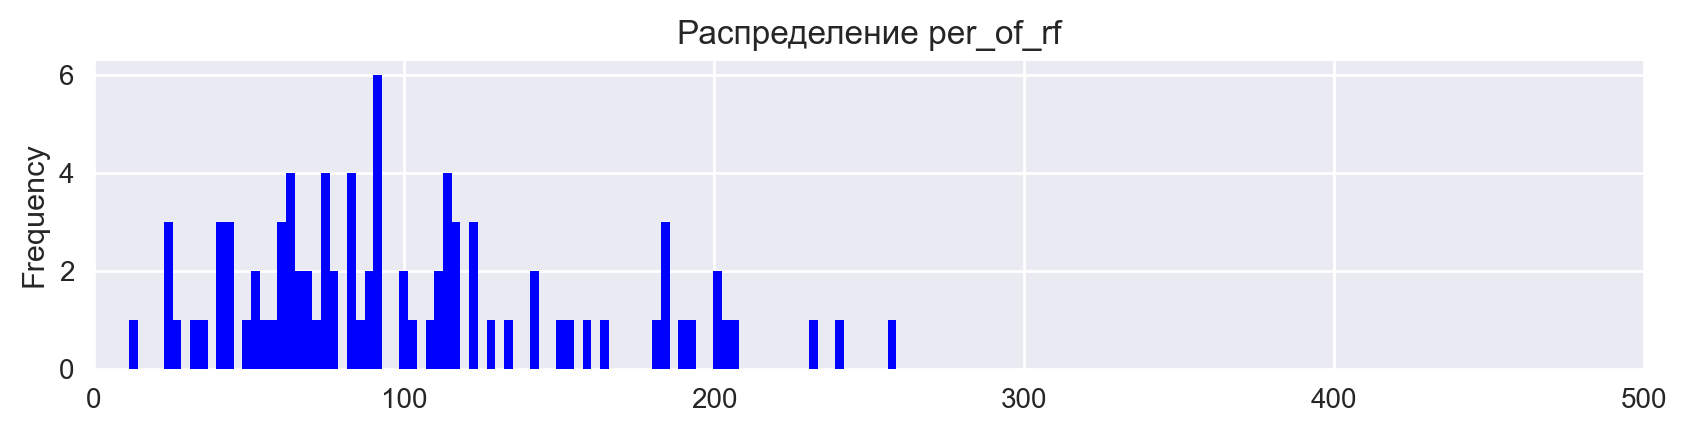

In [76]:
# выведем распределние признака per_of_rf в данных conditions_in_perinatal
feature_histogram(df=conditions_in_perinatal, feature='per_of_rf', min_x=0, max_x=500)

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд показателей при одновременном превышении уровня показателя уровня РФ в целом
- а также:
    - для **general_morbidity** значение показателя превышет 130% от уровня РФ в целом
    - для **congenital_malformation** значение показателя превышает 175% от уровня РФ в целом
    - для **psychosis** значение показателя превышает 170% от уровня РФ в целом
    - для **teenage_pregnancy** значение показателя превышает 170% от уровня РФ в целом
    - для **conditions_in_perinatal** значение показателя превышет 170% от уровня РФ в целом

In [77]:
# отмечаем проблемные регионы
general_morbidity = data_preparation_step_3(general_morbidity, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=130)
congenital_malformation = data_preparation_step_3(congenital_malformation, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=175)
psychosis = data_preparation_step_3(psychosis, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=170)
teenage_pregnancy = data_preparation_step_3(teenage_pregnancy, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=170)
conditions_in_perinatal = data_preparation_step_3(conditions_in_perinatal, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=170)

general_morbidity - Общая заболеваемость
* 'ПЛОХИЕ' регионы *


,region,2016,trend,per_of_rf,bad_region
3,Владимирская область,94163.6,1,119.80,1
5,Ивановская область,88473.5,1,112.56,1
11,Орловская область,94883.0,1,120.71,1
15,Тверская область,86566.6,1,110.13,1
19,Республика Карелия,112365.5,1,142.95,1
20,Республика Коми,111709.0,1,142.12,1
22,Ненецкий автономный округ,138231.7,-1,175.86,1
23,Вологодская область,91608.4,1,116.55,1
24,Калининградская область,82758.6,1,105.29,1
26,Мурманская область,87319.0,1,111.09,1


* Всего 'ПЛОХИХ' регионов: 27 *
----------------------------------------------------------------------------------------------------
congenital_malformation - Врожденные пороки развития
* 'ПЛОХИЕ' регионы *


,region,2016,trend,per_of_rf,bad_region
3,Владимирская область,210.4,1,102.14,1
11,Орловская область,315.4,1,153.11,1
12,Рязанская область,298.4,1,144.85,1
13,Смоленская область,321.6,1,156.12,1
19,Республика Карелия,442.3,1,214.71,1
20,Республика Коми,298.9,1,145.10,1
22,Ненецкий автономный округ,853.1,1,414.13,1
24,Калининградская область,388.8,1,188.74,1
29,Санкт-Петербург,254.5,1,123.54,1
30,Архангельская область без Ненецкого АО,458.9,1,222.77,1


* Всего 'ПЛОХИХ' регионов: 31 *
----------------------------------------------------------------------------------------------------
psychosis - Психические расстройства и расстройства поведения
* 'ПЛОХИЕ' регионы *


,region,2016,trend,per_of_rf,bad_region
22,Ненецкий автономный округ,903.3,-1,203.95,1
30,Архангельская область без Ненецкого АО,685.3,1,154.73,1
34,Республика Марий Эл,662.5,1,149.58,1
43,Пензенская область,843.3,-1,190.40,1
47,Курганская область,835.3,-1,188.60,1
57,Алтайский край,1272.1,-1,287.22,1
73,Еврейская автономная область,635.7,1,143.53,1
74,Чукотский автономный округ,957.0,-1,216.08,1


* Всего 'ПЛОХИХ' регионов: 8 *
----------------------------------------------------------------------------------------------------
teenage_pregnancy - Подростковая беременность (до 14 лет)
* 'ПЛОХИЕ' регионы *


,region,2016,trend,per_of_rf,bad_region
3,Владимирская область,22.5,1,145.16,1
16,Тульская область,16.5,1,106.45,1
17,Ярославская область,624.4,1,4028.39,1
19,Республика Карелия,31.8,1,205.16,1
20,Республика Коми,42.1,1,271.61,1
26,Мурманская область,20.4,1,131.61,1
32,Севастополь,23.4,1,150.97,1
36,Республика Татарстан,114.0,1,735.48,1
39,Пермский край,46.4,1,299.35,1
42,Оренбургская область,23.5,1,151.61,1


* Всего 'ПЛОХИХ' регионов: 17 *
----------------------------------------------------------------------------------------------------
conditions_in_perinatal - Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)
* 'ПЛОХИЕ' регионы *


,region,2016,trend,per_of_rf,bad_region
14,Тамбовская область,3733.6,-1,181.92,1
26,Мурманская область,4250.5,-1,207.11,1
28,Псковская область,4145.0,1,201.97,1
30,Архангельская область без Ненецкого АО,4145.0,-1,201.97,1
33,Республика Башкортостан,4170.1,-1,203.19,1
36,Республика Татарстан,4939.0,1,240.66,1
39,Пермский край,3956.1,-1,192.76,1
46,Ульяновская область,3807.9,-1,185.54,1
55,Республика Тыва,5311.9,1,258.83,1
61,Новосибирская область,3768.9,-1,183.64,1


* Всего 'ПЛОХИХ' регионов: 17 *
----------------------------------------------------------------------------------------------------


Теперь подправим названия признаков, используя префикс.

In [78]:
# правим названия признаков
data_features_rename(df=general_morbidity, prefix='general_morbidity')
data_features_rename(df=congenital_malformation, prefix='congenital_malformation')
data_features_rename(df=psychosis, prefix='psychosis')
data_features_rename(df=teenage_pregnancy, prefix='teenage_pregnancy')
data_features_rename(df=conditions_in_perinatal, prefix='conditions_in_perinatal')

general_morbidity - Общая заболеваемость
Размерность данных: (88, 5)


,region,general_morbidity,general_morbidity_trend,general_morbidity_per_of_rf,general_morbidity_bad_region
0,РФ,78602.1,1,100.00,0
1,Белгородская область,74637.4,-1,94.96,0
2,Брянская область,77439.0,-1,98.52,0
3,Владимирская область,94163.6,1,119.80,1
4,Воронежская область,55009.9,1,69.99,0


congenital_malformation - Врожденные пороки развития
Размерность данных: (88, 5)


,region,congenital_malformation,congenital_malformation_trend,congenital_malformation_per_of_rf,congenital_malformation_bad_region
0,РФ,206.0,1,100.00,0
1,Белгородская область,136.2,1,66.12,0
2,Брянская область,192.1,1,93.25,0
3,Владимирская область,210.4,1,102.14,1
4,Воронежская область,98.4,1,47.77,0


psychosis - Психические расстройства и расстройства поведения
Размерность данных: (88, 5)


,region,psychosis,psychosis_trend,psychosis_per_of_rf,psychosis_bad_region
0,РФ,442.9,-1,100.00,0
1,Белгородская область,388.2,-1,87.65,0
2,Брянская область,411.3,-1,92.87,0
3,Владимирская область,572.7,-1,129.31,0
4,Воронежская область,583.5,-1,131.75,0


teenage_pregnancy - Подростковая беременность (до 14 лет)
Размерность данных: (88, 5)


,region,teenage_pregnancy,teenage_pregnancy_trend,teenage_pregnancy_per_of_rf,teenage_pregnancy_bad_region
0,РФ,15.5,-1,100.00,0
1,Белгородская область,0.0,-1,0.00,0
2,Брянская область,0.0,-1,0.00,0
3,Владимирская область,22.5,1,145.16,1
4,Воронежская область,4.2,1,27.10,0


conditions_in_perinatal - Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)
Размерность данных: (88, 5)


,region,conditions_in_perinatal,conditions_in_perinatal_trend,conditions_in_perinatal_per_of_rf,conditions_in_perinatal_bad_region
0,РФ,2052.3,-1,100.00,0
1,Белгородская область,2424.0,-1,118.11,0
2,Брянская область,519.8,-1,25.33,0
3,Владимирская область,1904.7,-1,92.81,0
4,Воронежская область,1597.9,-1,77.86,0


В данных по подростковой беременности имеются пропуски. Их можно заполнить значениями по РФ в целом. 

In [79]:
values = {"teenage_pregnancy": 15.5, "teenage_pregnancy_per_of_rf": 100.00	}
teenage_pregnancy = teenage_pregnancy.fillna(value=values)

***

### 1.10. Рождаемость

Данные представляют собой файл формата *.csv*, который содержит таблицу:
- **newborn_2006_2022_monthly** - Описания данных нет, насколько я понял - количество новорожденных по регионам за период 2006-2022 по месяцам (от января 2006 до мая 2022).

В данных (последние две строки) присутствуют 'Московская обл. в старых границах' и 'Москва в старых границах', при этом строки содержат много пропусков, а там где есть информация - в регионах Москва и Московская область также есть информация, другими словами последние 2 строки данных для нас бесполезны и их можно удалить.     
Далее необходимо суммировать данные за год (воспользуемся готовым решением [DKudryavtsev](https://github.com/DKudryavtsev/RussiaRegions/tree/main)) и удалить даные за 2022 год, т.к. там даные долько за первые 5 месяцев.

Далее, представленные цифры - абсолютные, а значит мы по ним **не можем сравнить регионы**. Необходимо пересчитывать их на 100k населения.

In [80]:
# загружаем данные и выполняем первичную их очистку
newborn = pd.read_csv('data_provided/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
newborn.drop(columns='Unnamed: 198', axis=1, inplace=True)
newborn.drop(newborn.tail(2).index, inplace=True)
newborn.rename({'Region': 'region'}, axis=1, inplace=True)

# присваиваем имя таблице
newborn.name = 'newborn - Рождаемость'

# производим предварительную обработку данных и выводим их
newborn = data_preparation_step_1(df=newborn, region='region', replacement='без')

*** Данные после первичной обработки ***
newborn - Рождаемость


,region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,август 2021 г.,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.
0,РФ,109422.0,114068.99,129177.99,113391.99,125099.99,124238.0,125926.99,140227.99,123949.99,...,125356.99,121645.99,120080.99,114976.99,117945.99,103782.0,101082.0,115512.0,99696.99,103159.0
1,Белгородская область,1040.0,1094.00,1190.00,1044.00,1228.00,1249.0,1224.00,1389.00,1157.00,...,1154.00,1084.00,1053.00,990.00,1028.00,861.0,941.0,956.0,801.00,869.0
2,Брянская область,904.0,989.00,1039.00,936.00,1072.00,961.0,1058.00,1121.00,989.00,...,835.00,784.00,751.00,783.00,729.00,707.0,670.0,740.0,589.00,660.0
3,Владимирская область,1040.0,1059.00,1236.00,1063.00,1226.00,1144.0,1221.00,1333.00,1177.00,...,864.00,783.00,834.00,769.00,821.00,691.0,700.0,708.0,660.00,711.0
4,Воронежская область,1301.0,1479.00,1689.00,1513.00,1729.00,1555.0,1620.00,1897.00,1554.00,...,1708.00,1643.00,1278.00,1758.00,1584.00,1342.0,1326.0,1576.0,1309.00,1319.0


Размерность: (88, 198)
Количество строк, содержащих пропуски 4
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,август 2021 г.,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,729.0,681.0,702.0,659.0,707.0,614.0,579.0,709.0,629.0,649.0
33,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1650.0,1624.0,1542.0,1584.0,1520.0,1248.0,1302.0,1505.0,1258.0,1194.0
38,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,398.0,387.0,353.0,343.0,398.0,328.0,298.0,413.0,277.0,283.0
65,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1589.0,1635.0,1622.0,1544.0,1599.0,1479.0,1294.0,1551.0,1329.0,1410.0


----------------------------------------------------------------------------------------------------


Как обычно пропуски в данных по регионам Республика Крым,Севастополь, а также в регионах Архангельская область без Ненецкого АО,  Тюменская область без округов - причины понятны.

In [81]:
# Суммируем данные за год
# код взят отсюда (более красивого решения я не нашел)
# https://github.com/DKudryavtsev/RussiaRegions/blob/main/p1_dataset_compilation.ipynb
for year in range(2006, 2023):
    cols = []
    for col in newborn.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn[year] = newborn[cols].sum(axis=1).round(0).astype(int)
    newborn.drop(columns=cols, inplace=True)

# удаляем неполный год 
newborn = newborn.drop(columns=2022)

Теперь пересчитываем рождаемость на 100k населения.

In [82]:
# отсортируем таблицы рождаемости и населения, чтобы порядок регионов совпадал
newborn_sorted = newborn.sort_values(by = "region").reset_index().drop('index', axis=1)
population_temp_sorted = population_temp.sort_values(by = "region").reset_index().drop('index', axis=1)

# проверка на идентичность регионов в обеих таблицах
if newborn_sorted['region'].equals(population_temp_sorted['region']):
    print('Названия и порядок регионов в таблицах идентичны')
    # пересчитываем рождаемость на 100k населения
    newborn_100k = index_into_100k_population(
        newborn_sorted, population_temp_sorted.iloc[:,8:24], round=0, year_first=2006, year_last=2021)
    # выведем новые данные
    print(f'Размерность: {newborn_100k.shape}')
    display(newborn_100k.head())
else:
    print('Названия и/или порядок регионов в таблицах отличаются')

Названия и порядок регионов в таблицах идентичны
Размерность: (88, 17)


,region,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Алтайский край,1019.0,1141.0,1252.0,1273.0,1270.0,1272.0,1358.0,1353.0,1315.0,1261.0,1215.0,1079.0,1000.0,905.0,862.0,827.0
1,Амурская область,1208.0,1286.0,1330.0,1357.0,1374.0,1350.0,1428.0,1406.0,1375.0,1331.0,1288.0,1176.0,1113.0,998.0,994.0,939.0
2,Архангельская область,1091.0,1191.0,1215.0,1241.0,1254.0,1216.0,1275.0,1272.0,1263.0,1240.0,1203.0,1063.0,977.0,896.0,836.0,802.0
3,Архангельская область без Ненецкого АО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1248.0,1220.0,1178.0,1044.0,960.0,878.0,815.0,784.0
4,Астраханская область,1233.0,1335.0,1412.0,1421.0,1420.0,1424.0,1508.0,1484.0,1497.0,1456.0,1401.0,1209.0,1160.0,1085.0,1085.0,1073.0


In [83]:
# для корректной работы функций надо сместить строку РФ вверх таблицы
ixs_rf = newborn_100k[newborn_100k['region'] == 'РФ'].index[0]
newborn_100k = pd.concat([newborn_100k.iloc[[ixs_rf],:], newborn_100k.drop(ixs_rf, axis=0)], axis=0)

# присваиваем имя таблице
newborn_100k.name = 'newborn_100k - Количество новорожденных на 100k населения'

In [84]:
# производим второй этап обработки данных
newborn_100k = data_preparation_step_2(df=newborn_100k, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)

*** Данные после второго этапа обработки ***
newborn_100k - Количество новорожденных на 100k населения


,region,2021,trend,per_of_rf
44,РФ,960.0,-1,100.00
0,Алтайский край,827.0,-1,86.15
1,Амурская область,939.0,-1,97.81
2,Архангельская область,802.0,-1,83.54
3,Архангельская область без Ненецкого АО,784.0,1,81.67


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
44,РФ,960.0,-1,100.00
0,Алтайский край,827.0,-1,86.15
1,Амурская область,939.0,-1,97.81
2,Архангельская область,802.0,-1,83.54
4,Астраханская область,1073.0,-1,111.77
...,...,...,...,...
83,Чеченская Республика,2026.0,-1,211.04
84,Чувашская Республика,916.0,-1,95.42
85,Чукотский автономный округ,1052.0,-1,109.58
86,Ямало-Ненецкий автономный округ,1271.0,-1,132.40


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 51 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
0,Алтайский край,827.0,-1,86.15
1,Амурская область,939.0,-1,97.81
2,Архангельская область,802.0,-1,83.54
5,Белгородская область,793.0,-1,82.60
6,Брянская область,765.0,-1,79.69
7,Владимирская область,729.0,-1,75.94
8,Волгоградская область,790.0,-1,82.29
9,Вологодская область,905.0,-1,94.27
10,Воронежская область,806.0,-1,83.96
13,Ивановская область,742.0,-1,77.29


Всего таких регионов: 49 *
----------------------------------------------------------------------------------------------------


Итак, мы видим, что в 83 регионах (включая РФ) отмечается падение рождаемости. В 51 регионе рождаемость ниже уровня РФ в целом. В 49 регионах отмечается и падение рождаемости, и уровень ее ниже уровня РФ. Аутсайдер - Смоленская область.

newborn_100k - Количество новорожденных на 100k населения


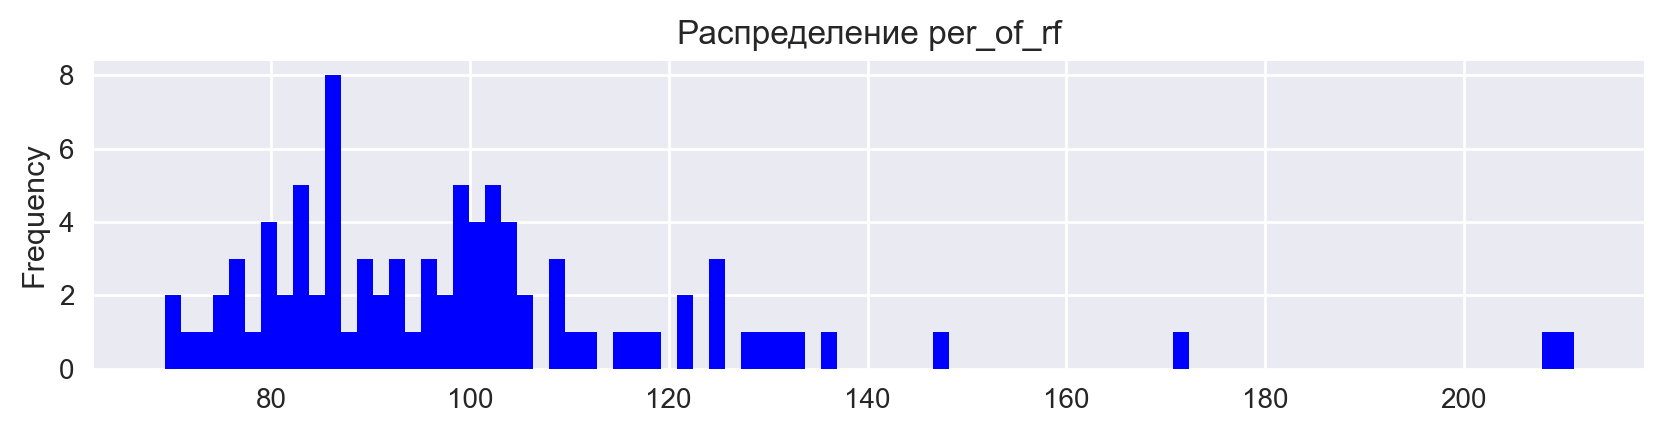

In [85]:
# выведем распределние признака per_of_rf в данных newborn_100k
feature_histogram(df=newborn_100k, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- отрицательный тренд по рождаемости + рождаемость на 100k населения менее 90% от уровня по РФ 
- а также уровень рождаемости ниже 85% от уровня РФ

In [86]:
# отмечаем проблемные регионы
newborn_100k = data_preparation_step_3(newborn_100k, bad_trend=-1, bad_per_of_rf='less', and_threshold=90, add_threshold=85)

newborn_100k - Количество новорожденных на 100k населения
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
0,Алтайский край,827.0,-1,86.15,1
2,Архангельская область,802.0,-1,83.54,1
3,Архангельская область без Ненецкого АО,784.0,1,81.67,1
5,Белгородская область,793.0,-1,82.60,1
6,Брянская область,765.0,-1,79.69,1
7,Владимирская область,729.0,-1,75.94,1
8,Волгоградская область,790.0,-1,82.29,1
10,Воронежская область,806.0,-1,83.96,1
13,Ивановская область,742.0,-1,77.29,1
17,Калужская область,863.0,-1,89.90,1


* Всего 'ПЛОХИХ' регионов: 35 *
----------------------------------------------------------------------------------------------------


Интересно то, что регионов Северного Кавказа здесь нет.

Теперь подправим названия признаков, используя префикс.

In [87]:
# правим названия признаков
data_features_rename(df=newborn_100k, prefix='newborn_100k')

newborn_100k - Количество новорожденных на 100k населения
Размерность данных: (88, 5)


,region,newborn_100k,newborn_100k_trend,newborn_100k_per_of_rf,newborn_100k_bad_region
44,РФ,960.0,-1,100.00,0
0,Алтайский край,827.0,-1,86.15,1
1,Амурская область,939.0,-1,97.81,0
2,Архангельская область,802.0,-1,83.54,1
3,Архангельская область без Ненецкого АО,784.0,1,81.67,1


***

### 1.9. Население за чертой бедности.

Данные представляют собой файл формата *.csv*, который содержит таблицу:
- **poverty_percent_by_regions_1992_2020** - процент людей, живущих за чертой бедности (с денежными доходами ниже величины
прожиточного минимума), оценка за год по регионам, период 1992-2020.

In [88]:
# загрузим данные
poverty_percent = pd.read_csv('data_provided/poverty_percent_by_regions_1992_2020.csv')

# преобразуем в таблицу привычного формата
poverty_percent = pd.pivot_table(
    data=poverty_percent, 
    values='poverty_percent', 
    columns='year', 
    index='region'
    ).reset_index()

# для корректной работы функций надо сместить строку РФ вверх таблицы
ixs_rf = poverty_percent[poverty_percent['region'] == 'Российская Федерация'].index[0]
poverty_percent = pd.concat([poverty_percent.iloc[[ixs_rf],:], poverty_percent.drop(ixs_rf, axis=0)], axis=0)

# зададим имя таблице 
poverty_percent.name = 'poverty_percent\nПроцент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)'

# производим предварительную обработку данных и выводим их
poverty_percent = data_preparation_step_1(df=poverty_percent, region='region', replacement='без')

*** Данные после первичной обработки ***
poverty_percent
Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)


,region,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,РФ,33.5,31.3,22.4,24.8,22.1,20.8,23.4,28.4,29.0,...,12.7,10.7,10.8,11.3,13.4,13.2,12.9,12.6,12.3,12.1
1,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.0,14.5,14.5,16.2,14.9,13.9,12.5,12.7,12.3
2,Ненецкий автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,37.9,...,7.7,6.5,7.8,8.9,9.4,10.1,10.6,9.7,9.4,9.4
3,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.4,11.8,12.0,14.7,15.5,15.4,14.3,14.4,13.6
4,Ханты-Мансийский автономный округ - Югра,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.8,...,10.6,9.8,10.4,11.1,11.9,11.6,9.5,9.0,8.9,8.4


Размерность: (88, 30)
Количество строк, содержащих пропуски 87
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.0,14.5,14.5,16.2,14.9,13.9,12.5,12.7,12.3
2,Ненецкий автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,37.9,...,7.7,6.5,7.8,8.9,9.4,10.1,10.6,9.7,9.4,9.4
3,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.4,11.8,12.0,14.7,15.5,15.4,14.3,14.4,13.6
4,Ханты-Мансийский автономный округ - Югра,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.8,...,10.6,9.8,10.4,11.1,11.9,11.6,9.5,9.0,8.9,8.4
5,Ямало-Ненецкий автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.1,...,7.4,6.4,6.4,6.7,7.5,7.1,6.1,5.8,5.5,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Челябинская область,NaN,NaN,NaN,27.9,27.2,22.1,26.9,32.3,30.7,...,10.8,10.1,11.1,11.7,13.7,13.8,13.2,12.8,12.8,12.6
84,Чеченская Республика,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,21.7,17.8,14.2,16.0,17.3,20.7,20.5,20.7,20.4
85,Чувашская Республика,NaN,NaN,NaN,27.0,27.0,28.4,43.0,57.2,51.3,...,19.3,16.0,16.5,16.4,17.9,18.8,18.4,17.8,17.4,16.8
86,Чукотский автономный округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,50.1,...,9.0,7.7,7.5,7.6,8.6,8.6,8.5,8.8,8.5,8.0


----------------------------------------------------------------------------------------------------


Пропуски почти во всех строках (кроме РФ).

In [89]:
# производим второй этап обработки данных
poverty_percent = data_preparation_step_2(df=poverty_percent, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
poverty_percent
Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)


,region,2020,trend,per_of_rf
0,РФ,12.1,-1,100.00
1,Архангельская область без Ненецкого АО,12.3,-1,101.65
2,Ненецкий автономный округ,9.4,1,77.69
3,Тюменская область без округов,13.6,1,112.40
4,Ханты-Мансийский автономный округ - Югра,8.4,1,69.42


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
2,Ненецкий автономный округ,9.4,1,77.69
3,Тюменская область без округов,13.6,1,112.40
4,Ханты-Мансийский автономный округ - Югра,8.4,1,69.42
5,Ямало-Ненецкий автономный округ,4.8,1,39.67
19,Еврейская автономная область,23.6,1,195.04
84,Чеченская Республика,20.4,1,168.60
86,Чукотский автономный округ,8.0,1,66.12


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 57 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf
3,Тюменская область без округов,13.6,1,112.40
19,Еврейская автономная область,23.6,1,195.04
84,Чеченская Республика,20.4,1,168.60


Всего таких регионов: 3 *
----------------------------------------------------------------------------------------------------


В 7 регионах мы видим плохой тренд (рост числа людей за чертой бедности). Из них в 3 регионах помимо плохого тренда имеется превышение данного показателя, по сравнению с уровнем РФ в целом.

poverty_percent
Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)


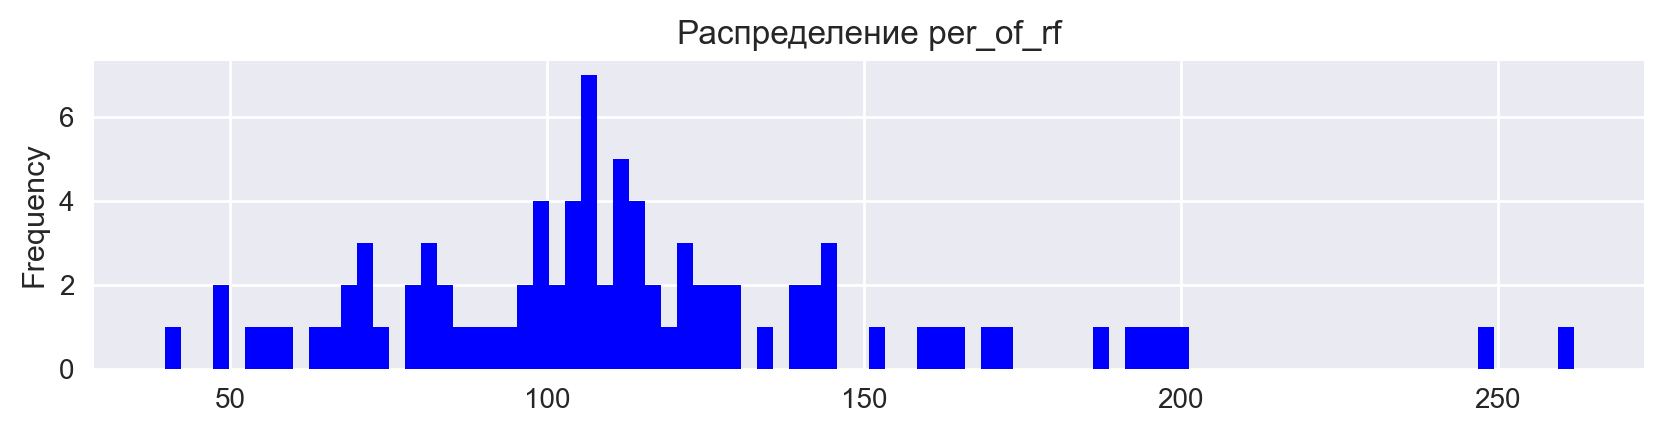

In [90]:
# выведем распределние признака per_of_rf в данных poverty_percent
feature_histogram(df=poverty_percent, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд в показателях (число людей за чертой бедности растет) и уровень показателей выше уровня РФ в целом
- а также показатель числа людей ниже черты бедности больше 150% уровня РФ в целом

In [91]:
# отмечаем проблемные регионы
poverty_percent = data_preparation_step_3(poverty_percent, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=150)

poverty_percent
Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
3,Тюменская область без округов,13.6,1,112.40,1
19,Еврейская автономная область,23.6,1,195.04,1
20,Забайкальский край,20.9,-1,172.73,1
23,Кабардино-Балкарская Республика,24.2,-1,200.00,1
27,Карачаево-Черкесская Республика,23.2,-1,191.74,1
33,Курганская область,19.3,-1,159.50,1
51,Республика Алтай,23.8,-1,196.69,1
53,Республика Бурятия,19.9,-1,164.46,1
55,Республика Ингушетия,30.0,-1,247.93,1
56,Республика Калмыкия,22.7,-1,187.60,1


* Всего 'ПЛОХИХ' регионов: 14 *
----------------------------------------------------------------------------------------------------


Сильно выделяются на фоне остальных Республика Тыва, Республика Ингушетия и Кабардино-Балкарская Республика, хотя стоит признать наличие отрицательного тренда в этих же регионах.

Теперь подправим названия признаков, используя префикс.

In [92]:
# правим названия признаков
data_features_rename(df=poverty_percent, prefix='poverty_percent')

poverty_percent
Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)
Размерность данных: (88, 5)


,region,poverty_percent,poverty_percent_trend,poverty_percent_per_of_rf,poverty_percent_bad_region
0,РФ,12.1,-1,100.00,0
1,Архангельская область без Ненецкого АО,12.3,-1,101.65,0
2,Ненецкий автономный округ,9.4,1,77.69,0
3,Тюменская область без округов,13.6,1,112.40,1
4,Ханты-Мансийский автономный округ - Югра,8.4,1,69.42,0


***

### 1.10. Распределение малоимущего населения по социально-демографическим группам

Данные представляют собой файлы формата *.xls*, которые содержат таблицы:
- **poverty_socdem_2017** - Распределение малоимущего населения по социально-демографическим группам (2017, процент, значение показателя за год)
- **poverty_socdem_2018** - Распределение малоимущего населения по социально-демографическим группам (2018, процент, значение показателя за год)
- **poverty_socdem_2019** - Распределение малоимущего населения по социально-демографическим группам (2019, процент, значение показателя за год)
- **poverty_socdem_2020** - Распределение малоимущего населения по социально-демографическим группам (2020, процент, значение показателя за год)

Социально демографические группы представлены: 
- Все население
- Дети в возрасте до 16 лет
- Население старше трудоспособного возраста
- Население трудоспособного возраста

Все население исследвать не будем (там 100%), а остальные группы оставим, т.к. одна из наших задач - описать группы населения, сталкивающиеся с бедностью.

Испоьзуем фрагмент кода [DKudryavtsev](https://github.com/DKudryavtsev/RussiaRegions/blob/main/p1_dataset_compilation.ipynb) для нашей функции чтения файлов.

In [93]:
def socdem_readout(file_path):
    ''''
    Функция принимает на вход путь к файлу формата .xls, читает его и преобразует
    в датафрейм, переименовывает признаки, добавляя год и удаляет ненужный признак 'Все население'
    Код частично заимствован отсюда:
    https://github.com/DKudryavtsev/RussiaRegions/blob/main/p1_dataset_compilation.ipynb
    '''
    df = pd.read_excel(file_path, header=2)
    df.rename({
        'Unnamed: 0': 'region',
        'Дети в возрасте до 16 лет': 'children' + file_path[-8:-4],
        'Население старше трудоспособного возраста': 'retired' + file_path[-8:-4],
        'Население трудоспособного возраста': 'employable' + file_path[-8:-4]
        }, axis=1, inplace=True)
    df.drop('Все население', axis=1, inplace=True)
    
    return df

In [94]:
# читаем файлы с данными и производим первичную обработку
poverty_socdem_2017 = socdem_readout('data_provided/poverty_socdem_2017.xls')
poverty_socdem_2018 = socdem_readout('data_provided/poverty_socdem_2018.xls')
poverty_socdem_2019 = socdem_readout('data_provided/poverty_socdem_2019.xls')
poverty_socdem_2020 = socdem_readout('data_provided/poverty_socdem_2020.xls')

# присваиваем имена таблицам
poverty_socdem_2017.name = 'poverty_socdem_2017'
poverty_socdem_2018.name = 'poverty_socdem_2018'
poverty_socdem_2019.name = 'poverty_socdem_2019'
poverty_socdem_2020.name = 'poverty_socdem_2020'

# производим предварительную обработку данных и выводим их
poverty_socdem_2017 = data_preparation_step_1(df=poverty_socdem_2017, region='region', replacement='без')
poverty_socdem_2018 = data_preparation_step_1(df=poverty_socdem_2018, region='region', replacement='без')
poverty_socdem_2019 = data_preparation_step_1(df=poverty_socdem_2019, region='region', replacement='без')
poverty_socdem_2020 = data_preparation_step_1(df=poverty_socdem_2020, region='region', replacement='без')

*** Данные после первичной обработки ***
poverty_socdem_2017


,region,children2017,retired2017,employable2017
0,РФ,39.3,6.6,54.1
1,Белгородская область,43.4,11.8,44.8
2,Брянская область,42.9,4.9,52.2
3,Владимирская область,34.8,8.6,56.6
4,Воронежская область,38.6,5.9,55.6


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
poverty_socdem_2018


,region,children2018,retired2018,employable2018
0,РФ,39.9,6.5,53.7
1,Белгородская область,44.8,12.9,42.3
2,Брянская область,40.3,1.8,57.9
3,Владимирская область,48.9,8.3,42.8
4,Воронежская область,32.6,8.0,59.4


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
poverty_socdem_2019


,region,children2019,retired2019,employable2019
0,РФ,41.0,6.9,52.0
1,Белгородская область,0.0,0.0,0.0
2,Брянская область,37.5,5.1,57.4
3,Владимирская область,34.8,4.8,60.4
4,Воронежская область,45.2,5.4,49.4


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
poverty_socdem_2020


,region,children2020,retired2020,employable2020
0,РФ,39.7,5.2,55.2
1,Белгородская область,NaN,NaN,NaN
2,Брянская область,44.8,3.7,51.6
3,Владимирская область,NaN,NaN,NaN
4,Воронежская область,28.5,2.3,69.2


Размерность: (88, 4)
Количество строк, содержащих пропуски 12
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,children2020,retired2020,employable2020
1,Белгородская область,NaN,NaN,NaN
3,Владимирская область,NaN,NaN,NaN
5,Ивановская область,NaN,NaN,NaN
6,Калужская область,NaN,NaN,NaN
22,Ненецкий автономный округ,NaN,NaN,NaN
26,Ленинградская область,NaN,NaN,NaN
30,Санкт-Петербург,NaN,NaN,NaN
38,Севастополь,NaN,NaN,NaN
48,Республика Мордовия,NaN,NaN,NaN
84,Магаданская область,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------


За 2020 год в 12 регионах пропуски во всех признаках. Можно 2020 год полностью убрать, но, честно говоря, жалко. Заполним пропуски значением по РФ.

In [95]:
poverty_socdem_2020['children2020'].fillna(value = 39.7	, inplace = True)
poverty_socdem_2020['retired2020'].fillna(value = 5.2	, inplace = True)
poverty_socdem_2020['employable2020'].fillna(value = 55.2	, inplace = True)

In [96]:
# проверим, что регионы и их порядок во всех 4 таблицах одинаков:
a = poverty_socdem_2017['region'] == poverty_socdem_2018['region']
b = poverty_socdem_2019['region'] == poverty_socdem_2020['region']
c = a == b
c.value_counts()

region
True    88
Name: count, dtype: int64

In [97]:
# создадим общую таблицу из предыдущих 4-х
poverty_socdem = pd.concat([
        poverty_socdem_2017,
        poverty_socdem_2018.drop('region', axis=1),
        poverty_socdem_2019.drop('region', axis=1),
        poverty_socdem_2020.drop('region', axis=1)
        ],axis=1)
poverty_socdem.head()

,region,children2017,retired2017,employable2017,children2018,retired2018,employable2018,children2019,retired2019,employable2019,children2020,retired2020,employable2020
0,РФ,39.3,6.6,54.1,39.9,6.5,53.7,41.0,6.9,52.0,39.7,5.2,55.2
1,Белгородская область,43.4,11.8,44.8,44.8,12.9,42.3,0.0,0.0,0.0,39.7,5.2,55.2
2,Брянская область,42.9,4.9,52.2,40.3,1.8,57.9,37.5,5.1,57.4,44.8,3.7,51.6
3,Владимирская область,34.8,8.6,56.6,48.9,8.3,42.8,34.8,4.8,60.4,39.7,5.2,55.2
4,Воронежская область,38.6,5.9,55.6,32.6,8.0,59.4,45.2,5.4,49.4,28.5,2.3,69.2


In [98]:
# создадим новые таблицы по группам населения
poverty_socdem_children = poverty_socdem[['region','children2017','children2018','children2019','children2020']]
poverty_socdem_retired = poverty_socdem[['region','retired2017','retired2018','retired2019','retired2020']]
poverty_socdem_employable = poverty_socdem[['region','employable2017','employable2018','employable2019','employable2020']]

# зададим названия таблицам
poverty_socdem_children.name = 'poverty_socdem_children - Малоимущее население (дети) в процентах'
poverty_socdem_retired.name = 'poverty_socdem_retired - Малоимущее население (пенсионеры) в процентах'
poverty_socdem_employable.name = 'poverty_socdem_employable - Малоимущее население (трудоспособное) в процентах'

In [99]:
# производим второй этап обработки данных
poverty_socdem_children = data_preparation_step_2(df=poverty_socdem_children, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
poverty_socdem_retired = data_preparation_step_2(df=poverty_socdem_retired, bad_trend=1, bad_per_of_rf='more', threshold_100=True)
poverty_socdem_employable = data_preparation_step_2(df=poverty_socdem_employable, bad_trend=1, bad_per_of_rf='more', threshold_100=True)


*** Данные после второго этапа обработки ***
poverty_socdem_children - Малоимущее население (дети) в процентах


,region,children2020,trend,per_of_rf
0,РФ,39.7,-1,100.00
1,Белгородская область,39.7,-1,100.00
2,Брянская область,44.8,1,112.85
3,Владимирская область,39.7,-1,100.00
4,Воронежская область,28.5,-1,71.79


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,children2020,trend,per_of_rf
2,Брянская область,44.8,1,112.85
5,Ивановская область,39.7,1,100.00
10,Московская область,49.9,1,125.69
11,Орловская область,41.5,1,104.53
12,Рязанская область,37.0,1,93.20
13,Смоленская область,34.7,1,87.41
14,Тамбовская область,33.5,1,84.38
16,Тульская область,38.8,1,97.73
18,Москва,38.4,1,96.73
19,Республика Карелия,39.0,1,98.24


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 35 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,children2020,trend,per_of_rf
2,Брянская область,44.8,1,112.85
10,Московская область,49.9,1,125.69
11,Орловская область,41.5,1,104.53
20,Республика Коми,40.1,1,101.01
24,Вологодская область,43.1,1,108.56
27,Мурманская область,43.7,1,110.08
28,Новгородская область,40.1,1,101.01
31,Республика Адыгея,44.6,1,112.34
33,Республика Крым,48.2,1,121.41
35,Астраханская область,42.1,1,106.05


Всего таких регионов: 25 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
poverty_socdem_retired - Малоимущее население (пенсионеры) в процентах


,region,retired2020,trend,per_of_rf
0,РФ,5.2,-1,100.00
1,Белгородская область,5.2,-1,100.00
2,Брянская область,3.7,1,71.15
3,Владимирская область,5.2,-1,100.00
4,Воронежская область,2.3,-1,44.23


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,retired2020,trend,per_of_rf
2,Брянская область,3.7,1,71.15
7,Костромская область,6.6,1,126.92
11,Орловская область,8.0,1,153.85
13,Смоленская область,12.0,1,230.77
14,Тамбовская область,7.6,1,146.15
16,Тульская область,5.3,1,101.92
18,Москва,13.2,1,253.85
21,Архангельская область,6.7,1,128.85
23,Архангельская область без Ненецкого АО,7.2,1,138.46
29,Псковская область,9.3,1,178.85


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 33 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,retired2020,trend,per_of_rf
7,Костромская область,6.6,1,126.92
11,Орловская область,8.0,1,153.85
13,Смоленская область,12.0,1,230.77
14,Тамбовская область,7.6,1,146.15
16,Тульская область,5.3,1,101.92
18,Москва,13.2,1,253.85
21,Архангельская область,6.7,1,128.85
23,Архангельская область без Ненецкого АО,7.2,1,138.46
29,Псковская область,9.3,1,178.85
35,Астраханская область,5.5,1,105.77


Всего таких регионов: 21 *
----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
poverty_socdem_employable - Малоимущее население (трудоспособное) в процентах


,region,employable2020,trend,per_of_rf
0,РФ,55.2,1,100.00
1,Белгородская область,55.2,1,100.00
2,Брянская область,51.6,-1,93.48
3,Владимирская область,55.2,1,100.00
4,Воронежская область,69.2,1,125.36


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,employable2020,trend,per_of_rf
0,РФ,55.2,1,100.00
1,Белгородская область,55.2,1,100.00
3,Владимирская область,55.2,1,100.00
4,Воронежская область,69.2,1,125.36
6,Калужская область,55.2,1,100.00
7,Костромская область,53.5,1,96.92
8,Курская область,59.2,1,107.25
9,Липецкая область,59.3,1,107.43
15,Тверская область,65.1,1,117.93
17,Ярославская область,65.8,1,119.20


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 37 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,employable2020,trend,per_of_rf
4,Воронежская область,69.2,1,125.36
8,Курская область,59.2,1,107.25
9,Липецкая область,59.3,1,107.43
15,Тверская область,65.1,1,117.93
17,Ярославская область,65.8,1,119.20
19,Республика Карелия,58.1,1,105.25
21,Архангельская область,63.1,1,114.31
23,Архангельская область без Ненецкого АО,64.3,1,116.49
25,Калининградская область,64.8,1,117.39
27,Мурманская область,55.8,1,101.09


Всего таких регионов: 29 *
----------------------------------------------------------------------------------------------------


Количество регионов-кандидатов на роль ПЛОХИХ по данным показателям впечатляет...

poverty_socdem_children - Малоимущее население (дети) в процентах


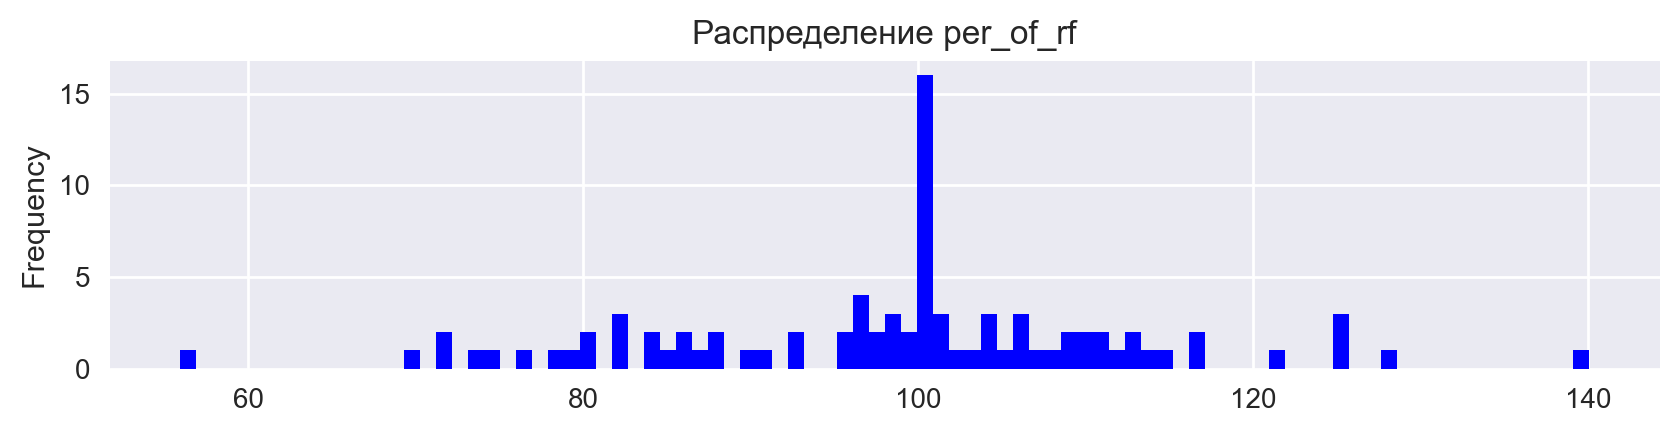

In [100]:
# выведем распределние признака per_of_rf в данных poverty_socdem_children
feature_histogram(df=poverty_socdem_children, feature='per_of_rf')

poverty_socdem_retired - Малоимущее население (пенсионеры) в процентах


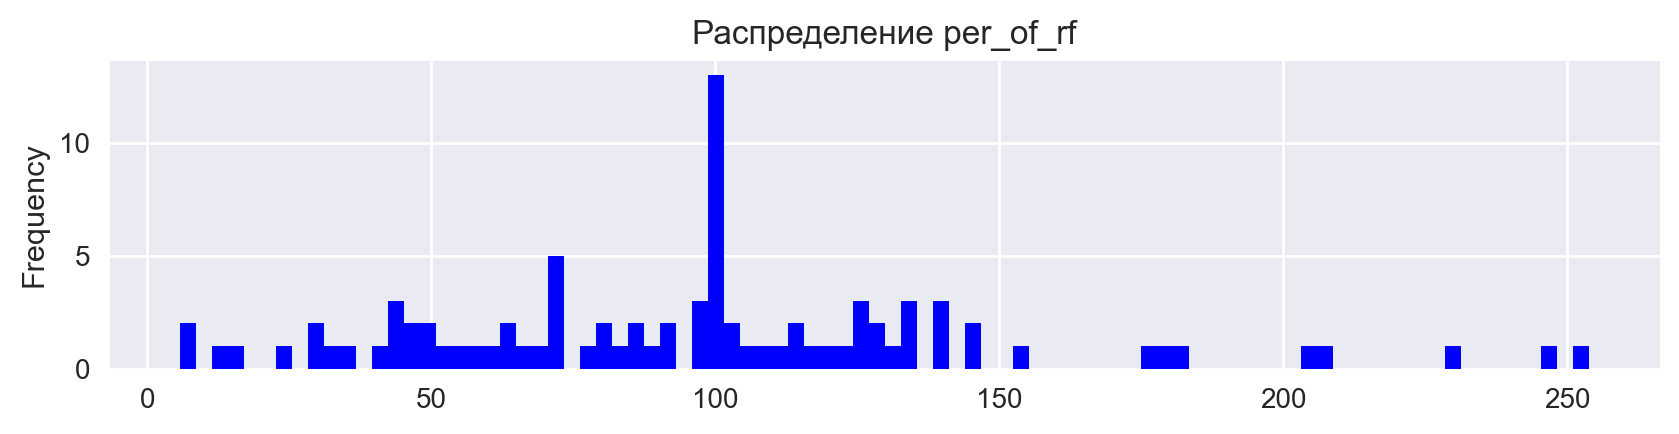

In [101]:
# выведем распределние признака per_of_rf в данных poverty_socdem_retired
feature_histogram(df=poverty_socdem_retired, feature='per_of_rf')

poverty_socdem_employable - Малоимущее население (трудоспособное) в процентах


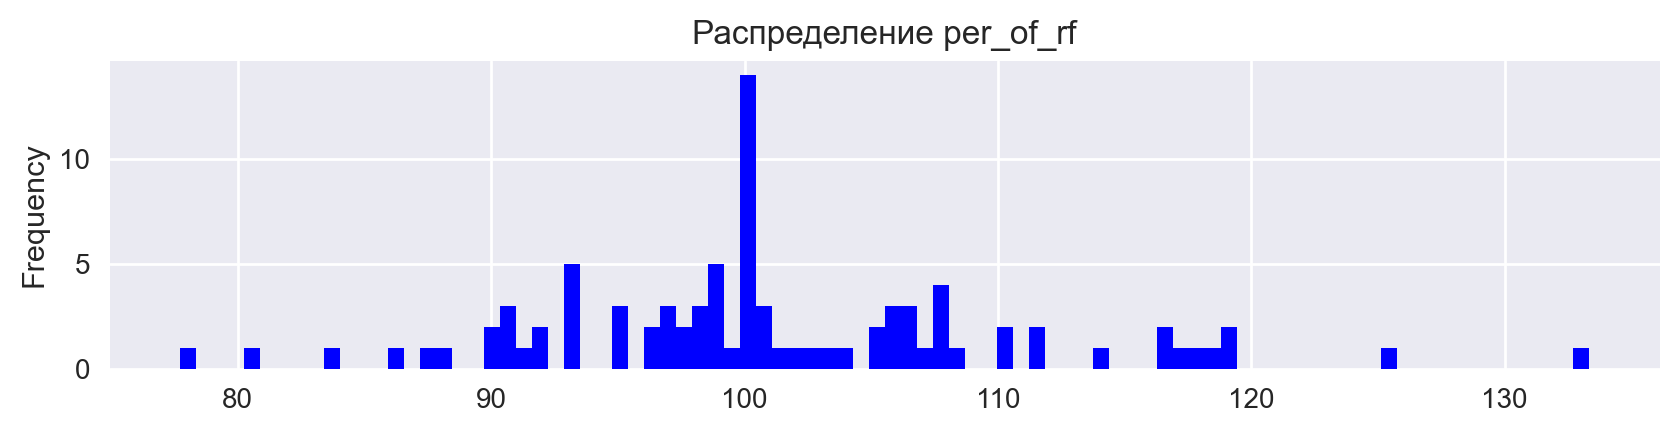

In [102]:
# выведем распределние признака per_of_rf в данных poverty_socdem_employable
feature_histogram(df=poverty_socdem_employable, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд в показателях (число малоимущих растет) и уровень показателей выше уровня РФ в целом
- а также показатель числа малоимущих
    - для **poverty_socdem_children** больше 120% уровня РФ в целом
    - для **poverty_socdem_retired** больше 150% уровня РФ в целом
    - для **poverty_socdem_employable** больше 120% уровня РФ в целом

In [103]:
# отмечаем проблемные регионы
poverty_socdem_children = data_preparation_step_3(poverty_socdem_children, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=120)
poverty_socdem_retired = data_preparation_step_3(poverty_socdem_retired, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=150)
poverty_socdem_employable = data_preparation_step_3(poverty_socdem_employable, bad_trend=1, bad_per_of_rf='more', and_threshold=100, add_threshold=120)

poverty_socdem_children - Малоимущее население (дети) в процентах
* 'ПЛОХИЕ' регионы *


,region,children2020,trend,per_of_rf,bad_region
2,Брянская область,44.8,1,112.85,1
10,Московская область,49.9,1,125.69,1
11,Орловская область,41.5,1,104.53,1
20,Республика Коми,40.1,1,101.01,1
24,Вологодская область,43.1,1,108.56,1
27,Мурманская область,43.7,1,110.08,1
28,Новгородская область,40.1,1,101.01,1
31,Республика Адыгея,44.6,1,112.34,1
33,Республика Крым,48.2,1,121.41,1
35,Астраханская область,42.1,1,106.05,1


* Всего 'ПЛОХИХ' регионов: 25 *
----------------------------------------------------------------------------------------------------
poverty_socdem_retired - Малоимущее население (пенсионеры) в процентах
* 'ПЛОХИЕ' регионы *


,region,retired2020,trend,per_of_rf,bad_region
7,Костромская область,6.6,1,126.92,1
11,Орловская область,8.0,1,153.85,1
13,Смоленская область,12.0,1,230.77,1
14,Тамбовская область,7.6,1,146.15,1
16,Тульская область,5.3,1,101.92,1
18,Москва,13.2,1,253.85,1
21,Архангельская область,6.7,1,128.85,1
23,Архангельская область без Ненецкого АО,7.2,1,138.46,1
29,Псковская область,9.3,1,178.85,1
35,Астраханская область,5.5,1,105.77,1


* Всего 'ПЛОХИХ' регионов: 21 *
----------------------------------------------------------------------------------------------------
poverty_socdem_employable - Малоимущее население (трудоспособное) в процентах
* 'ПЛОХИЕ' регионы *


,region,employable2020,trend,per_of_rf,bad_region
4,Воронежская область,69.2,1,125.36,1
8,Курская область,59.2,1,107.25,1
9,Липецкая область,59.3,1,107.43,1
15,Тверская область,65.1,1,117.93,1
17,Ярославская область,65.8,1,119.20,1
19,Республика Карелия,58.1,1,105.25,1
21,Архангельская область,63.1,1,114.31,1
23,Архангельская область без Ненецкого АО,64.3,1,116.49,1
25,Калининградская область,64.8,1,117.39,1
27,Мурманская область,55.8,1,101.09,1


* Всего 'ПЛОХИХ' регионов: 29 *
----------------------------------------------------------------------------------------------------


Главный вывод из представленных выше ПЛОХИХ регионов: где показатели выше общероссийских (что уже плохо) также имеется положительный тренд по данным показателям, что еще хуже! 

Теперь подправим названия признаков, используя префикс.

In [104]:
# правим названия признаков
data_features_rename(df=poverty_socdem_children, prefix='poverty_socdem_children')
data_features_rename(df=poverty_socdem_retired, prefix='poverty_socdem_retired')
data_features_rename(df=poverty_socdem_employable, prefix='poverty_socdem_employable')

poverty_socdem_children - Малоимущее население (дети) в процентах
Размерность данных: (88, 5)


,region,poverty_socdem_children,poverty_socdem_children_trend,poverty_socdem_children_per_of_rf,poverty_socdem_children_bad_region
0,РФ,39.7,-1,100.00,0
1,Белгородская область,39.7,-1,100.00,0
2,Брянская область,44.8,1,112.85,1
3,Владимирская область,39.7,-1,100.00,0
4,Воронежская область,28.5,-1,71.79,0


poverty_socdem_retired - Малоимущее население (пенсионеры) в процентах
Размерность данных: (88, 5)


,region,poverty_socdem_retired,poverty_socdem_retired_trend,poverty_socdem_retired_per_of_rf,poverty_socdem_retired_bad_region
0,РФ,5.2,-1,100.00,0
1,Белгородская область,5.2,-1,100.00,0
2,Брянская область,3.7,1,71.15,0
3,Владимирская область,5.2,-1,100.00,0
4,Воронежская область,2.3,-1,44.23,0


poverty_socdem_employable - Малоимущее население (трудоспособное) в процентах
Размерность данных: (88, 5)


,region,poverty_socdem_employable,poverty_socdem_employable_trend,poverty_socdem_employable_per_of_rf,poverty_socdem_employable_bad_region
0,РФ,55.2,1,100.00,0
1,Белгородская область,55.2,1,100.00,0
2,Брянская область,51.6,-1,93.48,0
3,Владимирская область,55.2,1,100.00,0
4,Воронежская область,69.2,1,125.36,1


### 1.11. Региональное производство

Данные представляют собой файлы формата *.csv*, которые содержат таблицы:
- **regional_production_2005_2016** - объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг.(в тысячах рублей, значение показателя за год, полный круг).
- **regional_production_2017_2020** - объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).

Данные за 2005-2016 сгруппированы по разделам и подразделам, наиболее подробно эти разделы представлены в РФ в целом и по федеральным округам. В отдельных регионах эти данные представлены в виде разделов:
- РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ
- РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА
- РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ

Данные за 2017-2020 сгруппированы по разделам и подразделам, наиболее подробно эти разделы представлены в РФ в целом. В отдельных регионах эти данные представлены в виде разделов:
- ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ
- ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА
- ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА
- ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ
- Промышленное производство (промышленность)

В первой таблице данные представлены за более длительный срок, во второй - более широкий охват разделов производства.     
В обеих таблицах имеются 2 одинаковых раздела: 'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'/'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ' и 'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'/'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'.     
Есть еще похожий раздел в обеих таблицах: 'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ'/'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА', но названия все-же отличаются, поэтому будем считать, что эти разделы не одно и то же.

**План работы с данными по региональному производству:**
- соединим данные из обеих таблиц по одинаковым разделам 'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'/'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ' и 'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'/'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА' и получим 2 таблицы с данными за период 2005-2020
- не будем выделять данные 'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ' из первой таблицы, т.к. даные будут устаревшими
- из второй таблицы выделим отдельно за период 2017-2020 следующие данные:
    - ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА
    - ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ
    - Промышленное производство (промышленность)

**Примечание:**
- данные представлены в абсолютных числах (тысячи рублей), и правильно ли сравнивать регионы по этим цифрам? мне кажется, что здесь нужна консультация профильного специалиста (экономиста) по этому поводу, нужно ли как-то пересчитывать эти показатели производства на какие-то другие цифры (например, та же численность населения или площадь региона и т.д.) Можно, конечно, пересчитаь эти цифры на душу населения, но будет ли это объективным критерием в случае, если федеральный центр забирает себе эти доходы и перераспределяет их уже потом между регионами?
- возможно, я допускаю ошибку разделяя производство по его разделам, возможно првильней было бы суммировать данные

In [105]:
# прочитаем данные
reg_prod_2005_2016 = pd.read_csv('data_provided/regional_production_2005_2016.csv')
reg_prod_2017_2020 = pd.read_csv('data_provided/regional_production_2017_2020.csv')

#### 1.11.1. Добыча полезных ископаемых

In [106]:
# выделим данные по добыче ископаемых в отдельные таблицы за 2 периода
mining_2005_2016 = reg_prod_2005_2016[reg_prod_2005_2016['production_field'] == 'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ']
mining_2017_2020 = reg_prod_2017_2020[reg_prod_2017_2020['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ']

# присвоим имена таблицам
mining_2005_2016.name = 'mining_2005_2016'
mining_2017_2020.name = 'mining_2017_2020'

# производим предварительную обработку данных и выводим их
mining_2005_2016 = data_preparation_step_1(df=mining_2005_2016, region='region', replacement='без')
mining_2017_2020 = data_preparation_step_1(df=mining_2017_2020, region='region', replacement='без')

*** Данные после первичной обработки ***
mining_2005_2016


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,NaN,3.062460e+09,3.720887e+09,4.488915e+09,5.271733e+09,5.090973e+09,6.217952e+09,8.020217e+09,8.950066e+09,9.213745e+09,9.690978e+09,1.125954e+10,1.173050e+10
1,Белгородская область,NaN,4.038990e+07,4.110161e+07,5.692278e+07,6.222149e+07,3.537525e+07,7.370403e+07,1.101581e+08,9.439002e+07,9.601706e+07,8.422265e+07,8.121115e+07,8.892991e+07
2,Брянская область,NaN,1.364149e+05,1.415951e+05,1.604174e+05,1.584166e+05,1.716277e+05,2.482497e+05,3.703105e+05,4.088714e+05,3.877768e+05,4.333783e+05,4.253366e+05,2.806723e+05
3,Владимирская область,NaN,5.522328e+05,7.495921e+05,1.148718e+06,1.671731e+06,1.302697e+06,1.516791e+06,1.632291e+06,2.142805e+06,3.643259e+06,4.648023e+06,3.406255e+06,3.180329e+06
4,Воронежская область,NaN,9.882391e+05,1.476910e+06,2.024267e+06,2.816051e+06,2.865124e+06,2.737213e+06,3.100084e+06,5.618142e+06,7.982461e+06,5.246207e+06,5.250337e+06,5.601162e+06


Размерность: (92, 14)
Количество строк, содержащих пропуски 92
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,NaN,3.062460e+09,3.720887e+09,4.488915e+09,5.271733e+09,5.090973e+09,6.217952e+09,8.020217e+09,8.950066e+09,9.213745e+09,9.690978e+09,1.125954e+10,1.173050e+10
1,Белгородская область,NaN,4.038990e+07,4.110161e+07,5.692278e+07,6.222149e+07,3.537525e+07,7.370403e+07,1.101581e+08,9.439002e+07,9.601706e+07,8.422265e+07,8.121115e+07,8.892991e+07
2,Брянская область,NaN,1.364149e+05,1.415951e+05,1.604174e+05,1.584166e+05,1.716277e+05,2.482497e+05,3.703105e+05,4.088714e+05,3.877768e+05,4.333783e+05,4.253366e+05,2.806723e+05
3,Владимирская область,NaN,5.522328e+05,7.495921e+05,1.148718e+06,1.671731e+06,1.302697e+06,1.516791e+06,1.632291e+06,2.142805e+06,3.643259e+06,4.648023e+06,3.406255e+06,3.180329e+06
4,Воронежская область,NaN,9.882391e+05,1.476910e+06,2.024267e+06,2.816051e+06,2.865124e+06,2.737213e+06,3.100084e+06,5.618142e+06,7.982461e+06,5.246207e+06,5.250337e+06,5.601162e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Амурская область,NaN,7.941909e+06,9.576979e+06,1.064934e+07,1.513225e+07,2.399537e+07,2.659908e+07,4.997345e+07,5.347346e+07,4.974698e+07,5.569035e+07,7.217962e+07,6.437910e+07
88,Магаданская область,NaN,1.488314e+07,1.475457e+07,1.371778e+07,1.575691e+07,2.087090e+07,2.954570e+07,4.181514e+07,5.925643e+07,5.317848e+07,6.178958e+07,8.319563e+07,1.065639e+08
89,Сахалинская область,NaN,3.581668e+07,5.786327e+07,1.986868e+08,2.171051e+08,2.677458e+08,3.538358e+08,5.025274e+08,5.397762e+08,5.588669e+08,7.360344e+08,7.086826e+08,5.977552e+08
90,Еврейская автономная область,NaN,2.200735e+05,1.873226e+05,4.534058e+05,3.079423e+05,2.155229e+05,2.861772e+05,4.016454e+05,3.980558e+05,4.139643e+05,7.203465e+05,9.744381e+05,1.226747e+06


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
mining_2017_2020


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,1.391616e+10,1.819387e+10,1.832413e+10,1.449890e+10
1,Белгородская область,NaN,1.165883e+08,1.488634e+08,1.783899e+08,1.898038e+08
2,Брянская область,NaN,2.774277e+05,2.615495e+05,3.380273e+05,3.106659e+05
3,Владимирская область,NaN,4.003911e+06,5.005219e+06,5.425672e+06,4.965110e+06
4,Воронежская область,NaN,6.282742e+06,7.726219e+06,9.026583e+06,9.230600e+06


Размерность: (86, 6)
Количество строк, содержащих пропуски 86
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,1.391616e+10,1.819387e+10,1.832413e+10,1.449890e+10
1,Белгородская область,NaN,1.165883e+08,1.488634e+08,1.783899e+08,1.898038e+08
2,Брянская область,NaN,2.774277e+05,2.615495e+05,3.380273e+05,3.106659e+05
3,Владимирская область,NaN,4.003911e+06,5.005219e+06,5.425672e+06,4.965110e+06
4,Воронежская область,NaN,6.282742e+06,7.726219e+06,9.026583e+06,9.230600e+06
...,...,...,...,...,...,...
81,Амурская область,NaN,6.435902e+07,6.016934e+07,8.250602e+07,1.167227e+08
82,Магаданская область,NaN,1.127492e+08,1.249369e+08,2.914563e+07,3.863604e+07
83,Сахалинская область,NaN,6.938521e+08,1.016799e+09,9.426709e+08,7.319201e+08
84,Еврейская автономная область,NaN,7.593201e+06,1.033014e+07,1.397169e+07,1.709371e+07


----------------------------------------------------------------------------------------------------


Работаем с данными за 2005-2016

In [107]:
# уточним проблемные регионы
output_problem_regions(mining_2005_2016)

mining_2005_2016


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
21,Архангельская область,NaN,4.346493e+07,5.168334e+07,7.851355e+07,9.081454e+07,1.416942e+08,1.557340e+08,1.740918e+08,1.789707e+08,1.844824e+08,1.948823e+08,2.355916e+08,2.576762e+08
22,Ненецкий автономный округ,NaN,4.189804e+07,5.063572e+07,7.758097e+07,8.896625e+07,1.396833e+08,1.535674e+08,1.712253e+08,1.768139e+08,1.816726e+08,1.875174e+08,2.171234e+08,2.330118e+08
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,2.166659e+06,2.866410e+06,2.156738e+06,2.809707e+06,7.364928e+06,NaN,2.466437e+07
24,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.846824e+07,2.466437e+07
63,Тюменская область,NaN,1.656325e+09,1.978788e+09,2.035408e+09,2.323781e+09,2.192210e+09,2.444036e+09,3.060890e+09,3.605421e+09,3.506043e+09,3.680429e+09,4.235443e+09,4.328054e+09
64,Ханты-Мансийский автономный округ - Югра,NaN,1.285302e+09,1.511714e+09,1.562900e+09,1.755504e+09,1.674428e+09,1.852415e+09,2.332816e+09,2.631669e+09,2.341619e+09,2.403087e+09,2.717011e+09,2.662062e+09
65,Ямало-Ненецкий автономный округ,NaN,3.647867e+08,4.595801e+08,4.645638e+08,5.592517e+08,4.981364e+08,5.581344e+08,6.714588e+08,8.909177e+08,1.054857e+09,1.146823e+09,1.354152e+09,1.495221e+09
66,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,3.348596e+07,5.661537e+07,8.283439e+07,1.095672e+08,1.305179e+08,NaN,1.707716e+08
67,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642801e+08,1.707716e+08


Дублируются строки 'Архангельская область без Ненецкого АО' и 'Тюменская область без округов', причем мы можем дополнить пропущенные значения.

In [108]:
# заполним недостающие значения из дубликатов
mining_2005_2016.iloc[23,-2] = 1.846824e+07
mining_2005_2016.iloc[66,-2] = 1.642801e+08
# удалим дублирующие строки и признак production_field
mining_2005_2016.drop(labels=[24,67], axis=0, inplace=True)
mining_2005_2016.drop('production_field', axis=1, inplace=True)

In [109]:
# еще дубликаты в таблице
mining_2005_2016.region.value_counts()[:3]

region
Москва                2
Московская область    2
РФ                    1
Name: count, dtype: int64

In [110]:
# выведем дубликаты
mask_1 = mining_2005_2016['region'] == 'Москва'
mask_2 = mining_2005_2016['region'] == 'Московская область'
mining_2005_2016[mask_1 | mask_2]

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
10,Московская область,3783851.50,5214695.4,7496608.6,1.193125e+07,9.611707e+06,7183868.6,7455736.3,8.514240e+06,9101201.2,1.007814e+07,15495486.9,1.227311e+07
18,Москва,4140710.47,107079100.3,437158097.1,4.640344e+08,4.720470e+08,488054965.0,643044319.7,7.133357e+08,795805384.5,7.328529e+08,878268535.6,9.665128e+08
69,Московская область,NaN,NaN,NaN,NaN,NaN,NaN,7455736.3,NaN,NaN,NaN,NaN,NaN
70,Москва,NaN,NaN,NaN,NaN,NaN,NaN,643044319.7,NaN,NaN,NaN,NaN,NaN


Очевидно, что 2 нижние строчки в выборке надо удалять

In [111]:
# удаляем лишние 2 строки
mining_2005_2016.drop(labels=[69,70], axis=0, inplace=True)

Работаем с данными за 2017-2020

In [112]:
# уточним проблемные регионы
mining_2017_2020.drop('production_field', axis=1, inplace=True)
output_problem_regions(mining_2017_2020)

mining_2017_2020


,region,2017,2018,2019,2020
21,Архангельская область,2.949980e+08,3.854018e+08,3.930501e+08,2.862079e+08
22,Ненецкий автономный округ,2.678579e+08,3.521338e+08,3.594963e+08,2.555097e+08
23,Архангельская область без Ненецкого АО,2.714012e+07,3.326793e+07,3.355381e+07,3.069817e+07
60,Тюменская область,5.068914e+09,6.522593e+09,6.768641e+09,5.200223e+09
61,Ханты-Мансийский автономный округ - Югра,2.983368e+09,3.778782e+09,3.859612e+09,2.659123e+09
62,Ямало-Ненецкий автономный округ,1.911722e+09,2.470590e+09,2.664635e+09,2.357945e+09
63,Тюменская область без округов,1.738247e+08,2.732215e+08,2.443940e+08,1.831552e+08


In [113]:
mining_2017_2020.shape

(86, 5)

Есть небольшая проблема: в данных за 2017-2020 годы отсутствуют данные по добыче полезных ископаемых в регионах 'Республика Калмыкия', 'Севастополь'. Придется пропуски за 2020 год заполнить данными за 2016.

Создадим итоговую таблицу **mining**, соединив таблицы *mining_2005_2016* и *mining_2017_2020*.

In [114]:
# итоговая таблица mining
mining = mining_2005_2016.merge(mining_2017_2020, how='left')

# зададим имя таблице
mining.name = 'mining - Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

In [115]:
# выведем данные по отсутствующим во 2-й таблице регионам
mask = (mining['region'] == 'Республика Калмыкия') | (mining['region'] == 'Севастополь')
mining[mask]

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
32,Республика Калмыкия,1061540.0,818522.4,752778.0,675633.0,922834.1,1527497.7,1704623.1,1715446.5,2727641.0,1898313.5,1289116.4,1569731.7,NaN,NaN,NaN,NaN
38,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15967.8,483196.0,874018.0,NaN,NaN,NaN,NaN


In [116]:
# заполним пропуски в 2020 году
mining.iloc[32,-1] = 1569731.7
mining.iloc[38,-1] = 874018.0

#### 1.11.2. Обрабатывающие производства

In [117]:
# выделим данные по добыче ископаемых в отдельные таблицы за 2 периода
manufacturing_2005_2016 = reg_prod_2005_2016[reg_prod_2005_2016['production_field'] == 'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА']
manufacturing_2017_2020 = reg_prod_2017_2020[reg_prod_2017_2020['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА']

# присвоим имена таблицам
manufacturing_2005_2016.name = 'manufacturing_2005_2016'
manufacturing_2017_2020.name = 'manufacturing_2017_2020'

# производим предварительную обработку данных и выводим их
manufacturing_2005_2016 = data_preparation_step_1(df=manufacturing_2005_2016, region='region', replacement='без')
manufacturing_2017_2020 = data_preparation_step_1(df=manufacturing_2017_2020, region='region', replacement='без')

*** Данные после первичной обработки ***
manufacturing_2005_2016


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,NaN,8.871976e+09,1.118537e+10,1.397778e+10,1.686362e+10,1.435198e+10,1.888074e+10,2.281328e+10,2.511061e+10,2.683976e+10,2.966125e+10,3.509043e+10,3.616612e+10
1,Белгородская область,NaN,1.017337e+08,1.366486e+08,1.917978e+08,2.707807e+08,2.416383e+08,3.195360e+08,3.691605e+08,4.093298e+08,4.044666e+08,4.702453e+08,5.628973e+08,6.038814e+08
2,Брянская область,NaN,3.695418e+07,4.679642e+07,5.992006e+07,7.268705e+07,5.784829e+07,7.386269e+07,9.198185e+07,1.100546e+08,1.176475e+08,1.264647e+08,1.715511e+08,1.755580e+08
3,Владимирская область,NaN,8.195199e+07,9.936081e+07,1.447210e+08,1.608528e+08,1.422518e+08,1.893704e+08,2.223254e+08,2.448005e+08,2.709784e+08,3.136822e+08,3.761681e+08,4.115942e+08
4,Воронежская область,NaN,7.677853e+07,8.988271e+07,1.099691e+08,1.398690e+08,1.325029e+08,1.758922e+08,2.283020e+08,2.500189e+08,2.589142e+08,3.106824e+08,3.965501e+08,4.141435e+08


Размерность: (92, 14)
Количество строк, содержащих пропуски 92
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,РФ,NaN,8.871976e+09,1.118537e+10,1.397778e+10,1.686362e+10,1.435198e+10,1.888074e+10,2.281328e+10,2.511061e+10,2.683976e+10,2.966125e+10,3.509043e+10,3.616612e+10
1,Белгородская область,NaN,1.017337e+08,1.366486e+08,1.917978e+08,2.707807e+08,2.416383e+08,3.195360e+08,3.691605e+08,4.093298e+08,4.044666e+08,4.702453e+08,5.628973e+08,6.038814e+08
2,Брянская область,NaN,3.695418e+07,4.679642e+07,5.992006e+07,7.268705e+07,5.784829e+07,7.386269e+07,9.198185e+07,1.100546e+08,1.176475e+08,1.264647e+08,1.715511e+08,1.755580e+08
3,Владимирская область,NaN,8.195199e+07,9.936081e+07,1.447210e+08,1.608528e+08,1.422518e+08,1.893704e+08,2.223254e+08,2.448005e+08,2.709784e+08,3.136822e+08,3.761681e+08,4.115942e+08
4,Воронежская область,NaN,7.677853e+07,8.988271e+07,1.099691e+08,1.398690e+08,1.325029e+08,1.758922e+08,2.283020e+08,2.500189e+08,2.589142e+08,3.106824e+08,3.965501e+08,4.141435e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Амурская область,NaN,8.639523e+06,9.620160e+06,1.134358e+07,1.403151e+07,1.509750e+07,1.856792e+07,2.082908e+07,2.202458e+07,2.195232e+07,2.405030e+07,3.390215e+07,2.789874e+07
88,Магаданская область,NaN,2.747545e+06,2.517751e+06,2.656177e+06,2.884345e+06,2.796219e+06,2.920714e+06,3.898943e+06,3.894964e+06,3.796556e+06,3.448371e+06,3.074309e+06,3.175608e+06
89,Сахалинская область,NaN,1.180246e+07,1.286533e+07,1.616764e+07,1.888849e+07,2.223546e+07,2.369439e+07,2.419342e+07,2.552123e+07,2.801992e+07,3.911053e+07,4.693528e+07,4.237477e+07
90,Еврейская автономная область,NaN,2.325707e+06,2.507757e+06,3.176365e+06,3.816631e+06,2.839598e+06,2.997626e+06,3.073327e+06,3.648146e+06,3.834596e+06,4.597060e+06,5.073697e+06,5.214477e+06


----------------------------------------------------------------------------------------------------
*** Данные после первичной обработки ***
manufacturing_2017_2020


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,3.871246e+10,4.459951e+10,4.743602e+10,4.778255e+10
1,Белгородская область,NaN,6.290926e+08,7.108288e+08,7.226997e+08,7.463807e+08
2,Брянская область,NaN,1.910189e+08,2.185441e+08,2.536616e+08,2.556862e+08
3,Владимирская область,NaN,4.064836e+08,4.484277e+08,4.918302e+08,5.261537e+08
4,Воронежская область,NaN,4.229436e+08,4.482234e+08,5.059125e+08,5.526451e+08


Размерность: (88, 6)
Количество строк, содержащих пропуски 88
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,3.871246e+10,4.459951e+10,4.743602e+10,4.778255e+10
1,Белгородская область,NaN,6.290926e+08,7.108288e+08,7.226997e+08,7.463807e+08
2,Брянская область,NaN,1.910189e+08,2.185441e+08,2.536616e+08,2.556862e+08
3,Владимирская область,NaN,4.064836e+08,4.484277e+08,4.918302e+08,5.261537e+08
4,Воронежская область,NaN,4.229436e+08,4.482234e+08,5.059125e+08,5.526451e+08
...,...,...,...,...,...,...
83,Амурская область,NaN,3.109536e+07,3.409104e+07,3.903233e+07,3.909386e+07
84,Магаданская область,NaN,4.466986e+06,4.512168e+06,1.474171e+08,2.098542e+08
85,Сахалинская область,NaN,5.184228e+07,6.030045e+07,6.795326e+07,6.589603e+07
86,Еврейская автономная область,NaN,6.743434e+06,6.631528e+06,6.622621e+06,5.460453e+06


----------------------------------------------------------------------------------------------------


В таблице **manufacturing_2017_2020** все впорядке - мы получили 88 регионов. Исследуем таблицу **manufacturing_2005_2016**:

In [118]:
# уточним проблемные регионы
output_problem_regions(manufacturing_2005_2016)

manufacturing_2005_2016


,region,production_field,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
21,Архангельская область,NaN,6.448825e+07,5.891192e+07,6.804651e+07,8.674832e+07,6.253923e+07,98361769.3,1.019469e+08,1.190154e+08,2.648836e+08,1.555001e+08,1.734048e+08,1.680264e+08
22,Ненецкий автономный округ,NaN,3.451816e+05,4.266502e+05,4.977766e+05,5.734065e+05,8.023357e+05,1150019.5,8.477656e+05,1.154483e+06,1.092264e+06,5.783208e+06,1.253210e+07,2.236972e+07
23,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,97211749.8,1.010991e+08,1.178609e+08,2.637913e+08,1.497168e+08,NaN,1.456567e+08
24,Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608727e+08,1.456567e+08
63,Тюменская область,NaN,3.007695e+08,4.168893e+08,4.815497e+08,6.562100e+08,5.689018e+08,751270534.3,9.065941e+08,9.953370e+08,1.103937e+09,1.084590e+09,1.323802e+09,1.382838e+09
64,Ханты-Мансийский автономный округ - Югра,NaN,4.596116e+07,6.470896e+07,9.354664e+07,1.426548e+08,1.237205e+08,158285884.1,1.089026e+08,1.066572e+08,3.843250e+08,3.986962e+08,4.220902e+08,4.256781e+08
65,Ямало-Ненецкий автономный округ,NaN,2.707332e+07,3.458159e+07,3.912327e+07,4.603933e+07,6.110024e+07,71151263.2,9.767502e+07,1.154089e+08,1.263933e+08,1.567985e+08,2.959423e+08,3.222871e+08
66,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,521833387.0,7.000164e+08,7.732709e+08,5.932190e+08,5.290951e+08,NaN,6.348728e+08
67,Тюменская область без округов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.057695e+08,6.348728e+08


Как и в предыдущем подразделе, дублируются строки 'Архангельская область без Ненецкого АО' и 'Тюменская область без округов', причем мы снова можем дополнить пропущенные значения.

In [119]:
# заполним недостающие значения из дубликатов
manufacturing_2005_2016.iloc[23,-2] = 1.608727e+08
manufacturing_2005_2016.iloc[66,-2] = 6.057695e+08
# удалим дублирующие строки и признак production_field
manufacturing_2005_2016.drop(labels=[24,67], axis=0, inplace=True)
manufacturing_2005_2016.drop('production_field', axis=1, inplace=True)

В таблице **manufacturing_2005_2016** есть еще дублирующие регионы. Алгоритм действий такой же, как и в предыдущем подразделе.

In [120]:
# еще дубликаты в таблице
manufacturing_2005_2016.region.value_counts()[:3]

region
Москва                2
Московская область    2
РФ                    1
Name: count, dtype: int64

In [121]:
# выведем дубликаты
mask_1 = manufacturing_2005_2016['region'] == 'Москва'
mask_2 = manufacturing_2005_2016['region'] == 'Московская область'
manufacturing_2005_2016[mask_1 | mask_2]

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
10,Московская область,5.232148e+08,6.259490e+08,9.087823e+08,1.069303e+09,1.032253e+09,1.241243e+09,1.425058e+09,1.528670e+09,1.611823e+09,1.767159e+09,2.086349e+09,2.161205e+09
18,Москва,1.002261e+09,1.519597e+09,1.851644e+09,2.129463e+09,1.638278e+09,2.049658e+09,2.405167e+09,2.655111e+09,3.468492e+09,4.163850e+09,5.156077e+09,5.761914e+09
69,Московская область,NaN,NaN,NaN,NaN,NaN,NaN,1.425058e+09,NaN,NaN,NaN,NaN,NaN
70,Москва,NaN,NaN,NaN,NaN,NaN,NaN,2.405167e+09,NaN,NaN,NaN,NaN,NaN


In [122]:
# удаляем лишние 2 строки
manufacturing_2005_2016.drop(labels=[69,70], axis=0, inplace=True)

Создадим итоговую таблицу **manufacturing**, соединив таблицы *manufacturing_2005_2016* и *manufacturing_2017_2020*.

In [123]:
# итоговая таблица manufacturing
manufacturing = manufacturing_2005_2016.merge(manufacturing_2017_2020.drop('production_field', axis=1), how='left')

# зададим имя таблице
manufacturing.name = 'manufacturing - Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

#### 1.11.3. Обеспечение электроэнергией, газом, паром; кондиционирование воздуха.

In [124]:
# выделим данные по обеспечению электроэнергией, газом, паром; кондиционированием воздуха.
electricity = reg_prod_2017_2020[reg_prod_2017_2020['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА']

# присвоим имя таблице
electricity.name = 'electricity\nОбеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

# производим предварительную обработку данных и выводим их
electricity = data_preparation_step_1(df=electricity, region='region', replacement='без')

*** Данные после первичной обработки ***
electricity
Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,5.379682e+09,5.641920e+09,5.805454e+09,5.959974e+09
1,Белгородская область,NaN,2.703072e+07,2.680549e+07,2.654258e+07,2.678738e+07
2,Брянская область,NaN,1.606411e+07,1.773026e+07,1.770875e+07,1.787640e+07
3,Владимирская область,NaN,3.330818e+07,3.629512e+07,3.781567e+07,3.726466e+07
4,Воронежская область,NaN,8.820727e+07,9.961811e+07,1.103848e+08,1.377990e+08


Размерность: (88, 6)
Количество строк, содержащих пропуски 88
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,5.379682e+09,5.641920e+09,5.805454e+09,5.959974e+09
1,Белгородская область,NaN,2.703072e+07,2.680549e+07,2.654258e+07,2.678738e+07
2,Брянская область,NaN,1.606411e+07,1.773026e+07,1.770875e+07,1.787640e+07
3,Владимирская область,NaN,3.330818e+07,3.629512e+07,3.781567e+07,3.726466e+07
4,Воронежская область,NaN,8.820727e+07,9.961811e+07,1.103848e+08,1.377990e+08
...,...,...,...,...,...,...
83,Амурская область,NaN,3.608714e+07,3.704637e+07,4.516639e+07,4.300032e+07
84,Магаданская область,NaN,1.454135e+07,1.601249e+07,1.802709e+07,1.815089e+07
85,Сахалинская область,NaN,1.646548e+07,1.806316e+07,1.887855e+07,1.991306e+07
86,Еврейская автономная область,NaN,4.209454e+06,4.454820e+06,4.757778e+06,4.967490e+06


----------------------------------------------------------------------------------------------------


#### 1.11.4. Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений

In [125]:
# выделим данные по обеспечению электроэнергией, газом, паром; кондиционированием воздуха.
water_supply = reg_prod_2017_2020[reg_prod_2017_2020['production_field'] == 'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ']

# присвоим имя таблице
water_supply.name = 'water_supply\nВодоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

# производим предварительную обработку данных и выводим их
water_supply = data_preparation_step_1(df=water_supply, region='region', replacement='без')

*** Данные после первичной обработки ***
water_supply
Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,1.022498e+09,1.185587e+09,1.324313e+09,1.428755e+09
1,Белгородская область,NaN,1.061410e+07,8.936415e+06,1.140417e+07,1.117503e+07
2,Брянская область,NaN,7.347143e+06,8.901073e+06,9.258735e+06,9.588966e+06
3,Владимирская область,NaN,9.986625e+06,1.125718e+07,1.158193e+07,1.294257e+07
4,Воронежская область,NaN,1.211614e+07,1.351242e+07,1.565724e+07,1.859205e+07


Размерность: (86, 6)
Количество строк, содержащих пропуски 86
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,1.022498e+09,1.185587e+09,1.324313e+09,1.428755e+09
1,Белгородская область,NaN,1.061410e+07,8.936415e+06,1.140417e+07,1.117503e+07
2,Брянская область,NaN,7.347143e+06,8.901073e+06,9.258735e+06,9.588966e+06
3,Владимирская область,NaN,9.986625e+06,1.125718e+07,1.158193e+07,1.294257e+07
4,Воронежская область,NaN,1.211614e+07,1.351242e+07,1.565724e+07,1.859205e+07
...,...,...,...,...,...,...
81,Амурская область,NaN,2.880550e+06,3.073681e+06,3.308610e+06,3.471370e+06
82,Магаданская область,NaN,8.544882e+05,9.325172e+05,1.078467e+06,1.134120e+06
83,Сахалинская область,NaN,2.661522e+06,2.620611e+06,4.327956e+06,4.135166e+06
84,Еврейская автономная область,NaN,4.455363e+05,5.188002e+05,4.425363e+05,4.477501e+05


----------------------------------------------------------------------------------------------------


И снова одна из старых проблем: в данных за 2017-2020 годы отсутствуют данные по водоснабжению и пр. в регионах 'Республика Калмыкия', 'Севастополь'. Заполним пропуски данными по РФ в целом.

In [126]:
# удалим признак production_field
water_supply.drop('production_field', axis=1, inplace=True)
# данные по утеряным регионам
new_record = pd.DataFrame([
    {'region':'Республика Калмыкия', '2017':1.022498e+09, '2018':1.185587e+09, '2019':1.324313e+09, '2020':1.428755e+09},
    {'region':'Севастополь', '2017':1.022498e+09, '2018':1.185587e+09, '2019':1.324313e+09, '2020':1.428755e+09}
    ])
# добавим данные по утерянным регионам
water_supply = pd.concat([water_supply, new_record], axis=0, ignore_index=True)
# присвоим имя таблице
water_supply.name = 'water_supply\nВодоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

#### 1.11.5. Промышленное производство

In [127]:
# выделим данные по обеспечению электроэнергией, газом, паром; кондиционированием воздуха.
industrial_production = reg_prod_2017_2020[reg_prod_2017_2020['production_field'] == 'Промышленное производство (промышленность)']

# присвоим имя таблице
industrial_production.name = 'industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)'

# производим предварительную обработку данных и выводим их
industrial_production = data_preparation_step_1(df=industrial_production, region='region', replacement='без')

*** Данные после первичной обработки ***
industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,5.903081e+10,6.962089e+10,7.288992e+10,6.967018e+10
1,Белгородская область,NaN,7.833257e+08,8.954341e+08,9.390364e+08,9.741469e+08
2,Брянская область,NaN,2.147076e+08,2.454370e+08,2.809671e+08,2.834622e+08
3,Владимирская область,NaN,4.537824e+08,5.009853e+08,5.466535e+08,5.813260e+08
4,Воронежская область,NaN,5.295498e+08,5.690802e+08,6.409811e+08,7.182667e+08


Размерность: (88, 6)
Количество строк, содержащих пропуски 88
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,production_field,2017,2018,2019,2020
0,РФ,NaN,5.903081e+10,6.962089e+10,7.288992e+10,6.967018e+10
1,Белгородская область,NaN,7.833257e+08,8.954341e+08,9.390364e+08,9.741469e+08
2,Брянская область,NaN,2.147076e+08,2.454370e+08,2.809671e+08,2.834622e+08
3,Владимирская область,NaN,4.537824e+08,5.009853e+08,5.466535e+08,5.813260e+08
4,Воронежская область,NaN,5.295498e+08,5.690802e+08,6.409811e+08,7.182667e+08
...,...,...,...,...,...,...
83,Амурская область,NaN,1.344221e+08,1.343804e+08,1.700133e+08,2.022882e+08
84,Магаданская область,NaN,1.326120e+08,1.463941e+08,1.956683e+08,2.677753e+08
85,Сахалинская область,NaN,7.648214e+08,1.097783e+09,1.033831e+09,8.218643e+08
86,Еврейская автономная область,NaN,1.899162e+07,2.193529e+07,2.579462e+07,2.796941e+07


----------------------------------------------------------------------------------------------------


А вот здесь все в порядке.

#### 1.11.6. Окончательная обработка полученных таблиц

In [128]:
# производим второй этап обработки данных
mining = data_preparation_step_2(df=mining, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)
manufacturing = data_preparation_step_2(df=manufacturing, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)
electricity = data_preparation_step_2(df=electricity, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)
water_supply = data_preparation_step_2(df=water_supply, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)
industrial_production = data_preparation_step_2(df=industrial_production, bad_trend=-1, bad_per_of_rf='less', threshold_100=False)

*** Данные после второго этапа обработки ***
mining - Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,2020,trend,per_of_rf
0,РФ,1.449890e+10,1,100.00
1,Белгородская область,1.898038e+08,1,1.31
2,Брянская область,3.106659e+05,1,0.00
3,Владимирская область,4.965110e+06,1,0.03
4,Воронежская область,9.230600e+06,1,0.06


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
44,Чеченская Республика,4552198.6,-1,0.03
75,Омская область,2061436.0,-1,0.01


----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
manufacturing - Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,2020,trend,per_of_rf
0,РФ,4.778255e+10,1,100.00
1,Белгородская область,7.463807e+08,1,1.56
2,Брянская область,2.556862e+08,1,0.54
3,Владимирская область,5.261537e+08,1,1.10
4,Воронежская область,5.526451e+08,1,1.16


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
68,Республика Тыва,562091.74,-1,0.0


----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
electricity
Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,2020,trend,per_of_rf
0,РФ,5.959974e+09,1,100.00
1,Белгородская область,2.678738e+07,-1,0.45
2,Брянская область,1.787640e+07,1,0.30
3,Владимирская область,3.726466e+07,1,0.63
4,Воронежская область,1.377990e+08,1,2.31


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
1,Белгородская область,2.678738e+07,-1,0.45
5,Ивановская область,2.817499e+07,-1,0.47
7,Костромская область,3.214272e+07,-1,0.54
8,Курская область,5.732474e+07,-1,0.96
9,Липецкая область,2.327216e+07,-1,0.39
10,Московская область,2.786495e+08,-1,4.68
14,Тамбовская область,1.487846e+07,-1,0.25
15,Тверская область,9.221904e+07,-1,1.55
20,Республика Коми,4.245596e+07,-1,0.71
24,Вологодская область,4.011237e+07,-1,0.67


----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
water_supply
Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,2020,trend,per_of_rf
0,РФ,1.428755e+09,1,100.00
1,Белгородская область,1.117503e+07,1,0.78
2,Брянская область,9.588966e+06,1,0.67
3,Владимирская область,1.294257e+07,1,0.91
4,Воронежская область,1.859205e+07,1,1.30


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
8,Курская область,6601104.20,-1,0.46
9,Липецкая область,11323568.20,-1,0.79
29,Псковская область,5413324.70,-1,0.38
33,Краснодарский край,30522965.28,-1,2.14
36,Ростовская область,35589982.20,-1,2.49
37,Республика Дагестан,1838720.30,-1,0.13
46,Республика Мордовия,3290484.10,-1,0.23
50,Пермский край,27709999.85,-1,1.94
56,Саратовская область,12703500.70,-1,0.89
57,Ульяновская область,9717375.40,-1,0.68


----------------------------------------------------------------------------------------------------
*** Данные после второго этапа обработки ***
industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


,region,2020,trend,per_of_rf
0,РФ,6.967018e+10,1,100.00
1,Белгородская область,9.741469e+08,1,1.40
2,Брянская область,2.834622e+08,1,0.41
3,Владимирская область,5.813260e+08,1,0.83
4,Воронежская область,7.182667e+08,1,1.03


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
21,Архангельская область,5.950092e+08,-1,0.85
22,Ненецкий автономный округ,2.629557e+08,-1,0.38
23,Архангельская область без Ненецкого АО,3.320535e+08,-1,0.48
34,Краснодарский край,1.087352e+09,-1,1.56
40,Республика Ингушетия,4.277505e+06,-1,0.01
42,Карачаево-Черкесская Республика,4.056937e+07,-1,0.06
43,Республика Северная Осетия-Алания,3.573114e+07,-1,0.05
47,Республика Марий Эл,1.624585e+08,-1,0.23
63,Ханты-Мансийский автономный округ - Югра,3.466475e+09,-1,4.98
65,Тюменская область без округов,9.122849e+08,-1,1.31


----------------------------------------------------------------------------------------------------


Понятно, что отрицательный тренд по представленным показателям - это признак плохого региона. Но ниже какого уровня в признаке *per_of_rf* считать регион плохим?

mining - Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


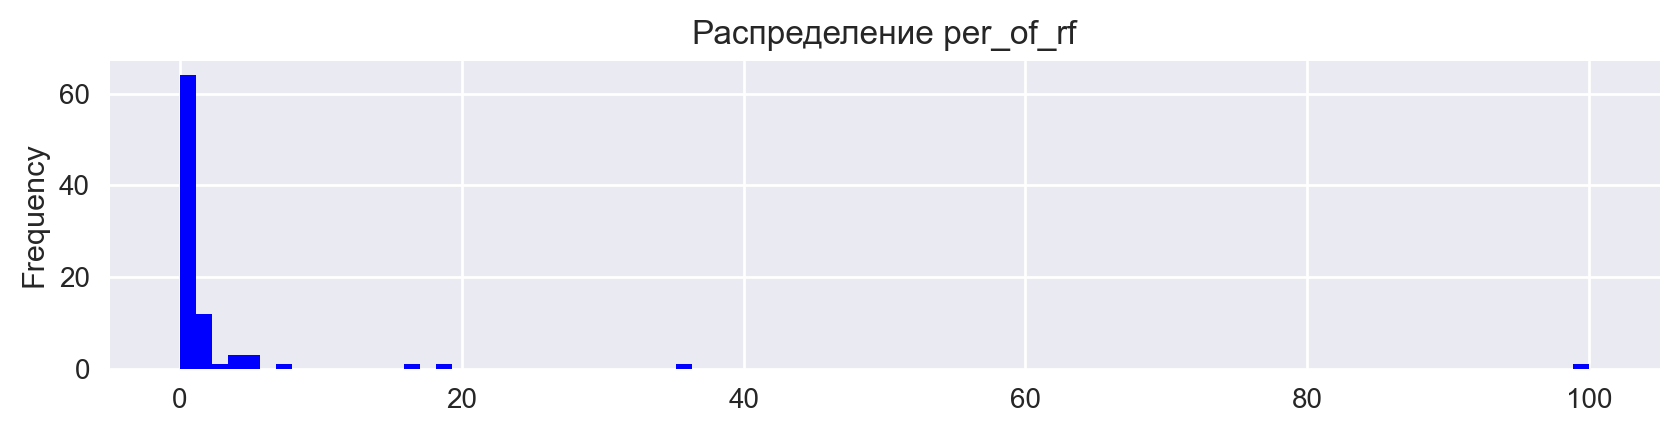

In [129]:
# выведем распределние признака per_of_rf в данных mining
feature_histogram(df=mining, feature='per_of_rf')

manufacturing - Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


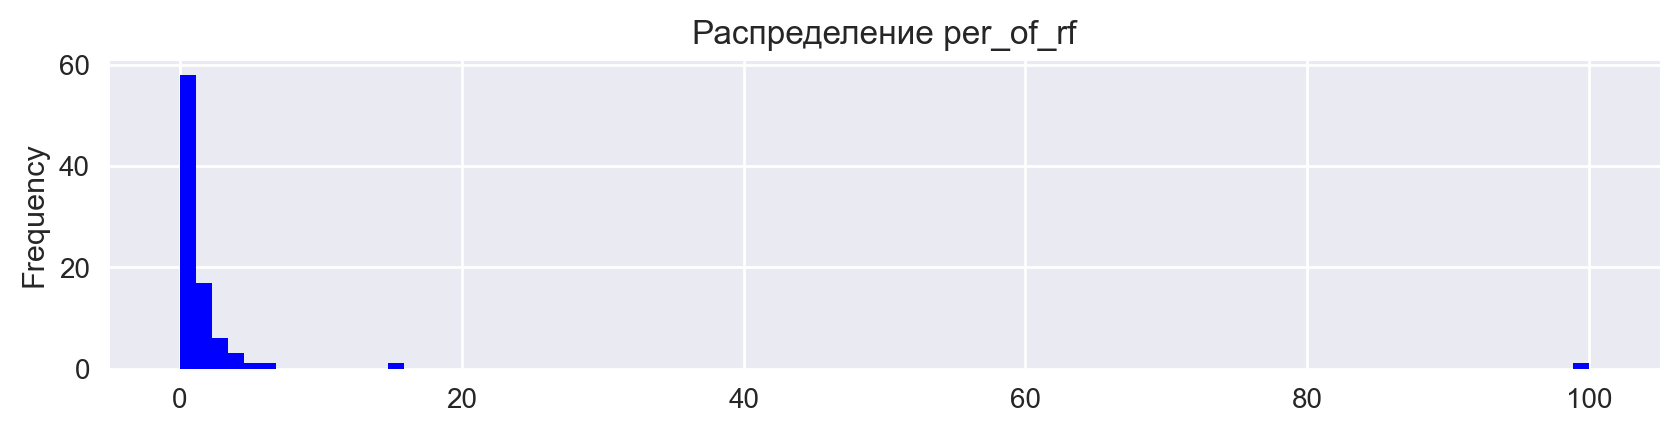

In [130]:
# выведем распределние признака per_of_rf в данных manufacturing
feature_histogram(df=manufacturing, feature='per_of_rf')

electricity
Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


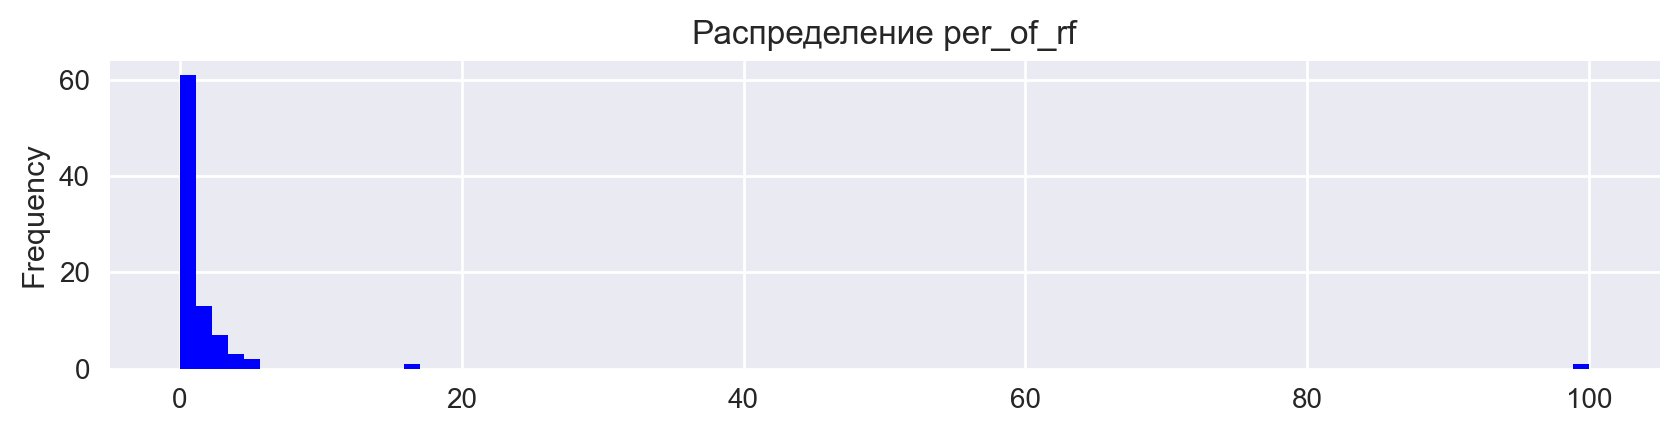

In [131]:
# выведем распределние признака per_of_rf в данных electricity
feature_histogram(df=electricity, feature='per_of_rf')

water_supply
Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


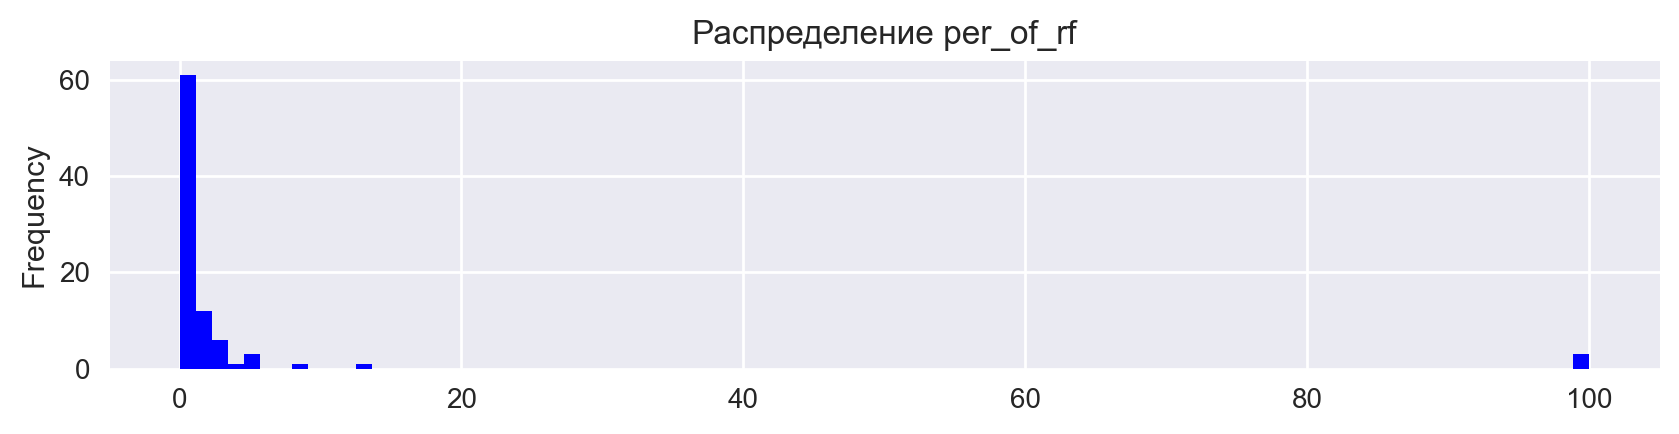

In [132]:
# выведем распределние признака per_of_rf в данных water_supply
feature_histogram(df=water_supply, feature='per_of_rf')

industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)


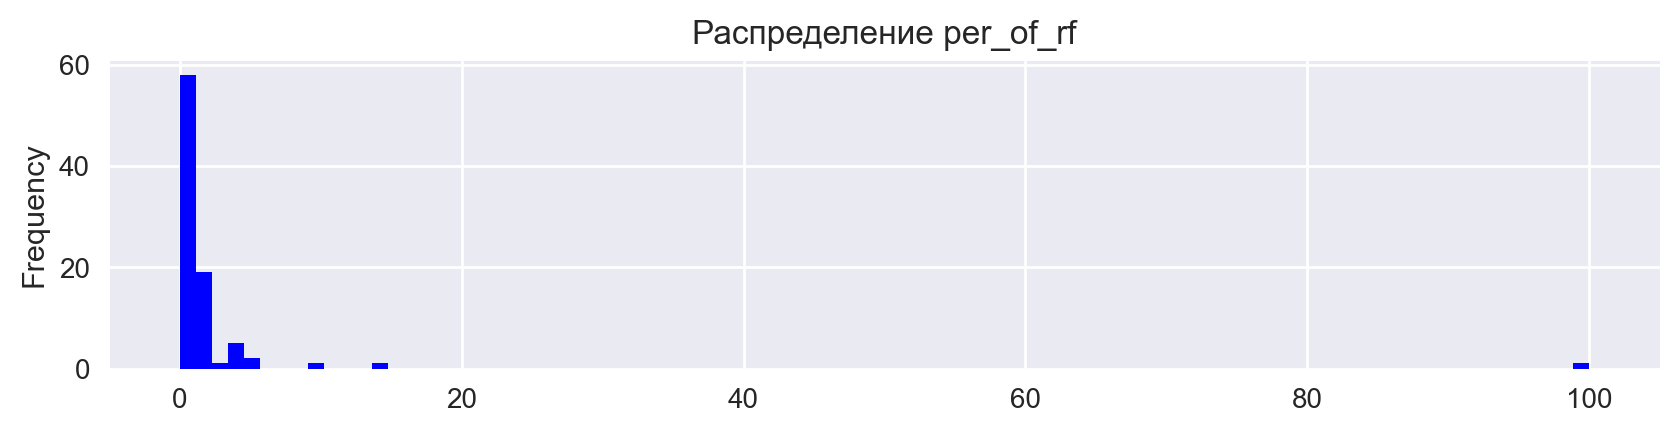

In [133]:
# выведем распределние признака per_of_rf в данных industrial_production
feature_histogram(df=industrial_production, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- отрицательный тренд в показателях (региональное производство падает) и уровень показателей ниже 1% от уровня РФ в целом

In [134]:
# отмечаем проблемные регионы
mining = data_preparation_step_3(mining, bad_trend=-1, bad_per_of_rf='less', and_threshold=1, add_threshold=False)
manufacturing = data_preparation_step_3(manufacturing, bad_trend=-1, bad_per_of_rf='less', and_threshold=1, add_threshold=False)
electricity = data_preparation_step_3(electricity, bad_trend=-1, bad_per_of_rf='less', and_threshold=1, add_threshold=False)
water_supply = data_preparation_step_3(water_supply, bad_trend=-1, bad_per_of_rf='less', and_threshold=1, add_threshold=False)
industrial_production = data_preparation_step_3(industrial_production, bad_trend=-1, bad_per_of_rf='less', and_threshold=1, add_threshold=False)

mining - Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
44,Чеченская Республика,4552198.6,-1,0.03,1
75,Омская область,2061436.0,-1,0.01,1


* Всего 'ПЛОХИХ' регионов: 2 *
----------------------------------------------------------------------------------------------------
manufacturing - Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
68,Республика Тыва,562091.74,-1,0.0,1


* Всего 'ПЛОХИХ' регионов: 1 *
----------------------------------------------------------------------------------------------------
electricity
Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
1,Белгородская область,26787381.90,-1,0.45,1
5,Ивановская область,28174991.40,-1,0.47,1
7,Костромская область,32142719.00,-1,0.54,1
8,Курская область,57324742.90,-1,0.96,1
9,Липецкая область,23272161.30,-1,0.39,1
14,Тамбовская область,14878456.32,-1,0.25,1
20,Республика Коми,42455955.55,-1,0.71,1
24,Вологодская область,40112366.04,-1,0.67,1
27,Мурманская область,54903783.96,-1,0.92,1
39,Республика Дагестан,17750862.40,-1,0.30,1


* Всего 'ПЛОХИХ' регионов: 20 *
----------------------------------------------------------------------------------------------------
water_supply
Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
8,Курская область,6601104.2,-1,0.46,1
9,Липецкая область,11323568.2,-1,0.79,1
29,Псковская область,5413324.7,-1,0.38,1
37,Республика Дагестан,1838720.3,-1,0.13,1
46,Республика Мордовия,3290484.1,-1,0.23,1
56,Саратовская область,12703500.7,-1,0.89,1
57,Ульяновская область,9717375.4,-1,0.68,1
58,Курганская область,3400843.9,-1,0.24,1
74,Томская область,8768566.9,-1,0.61,1
84,Еврейская автономная область,447750.1,-1,0.03,1


* Всего 'ПЛОХИХ' регионов: 10 *
----------------------------------------------------------------------------------------------------
industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
21,Архангельская область,5.950092e+08,-1,0.85,1
22,Ненецкий автономный округ,2.629557e+08,-1,0.38,1
23,Архангельская область без Ненецкого АО,3.320535e+08,-1,0.48,1
40,Республика Ингушетия,4.277505e+06,-1,0.01,1
42,Карачаево-Черкесская Республика,4.056937e+07,-1,0.06,1
43,Республика Северная Осетия-Алания,3.573114e+07,-1,0.05,1
47,Республика Марий Эл,1.624585e+08,-1,0.23,1
67,Республика Алтай,8.711664e+06,-1,0.01,1
68,Республика Тыва,2.329183e+07,-1,0.03,1
76,Томская область,3.549213e+08,-1,0.51,1


* Всего 'ПЛОХИХ' регионов: 10 *
----------------------------------------------------------------------------------------------------


Теперь подправим названия признаков, используя префикс.

In [135]:
# правим названия признаков
data_features_rename(df=mining, prefix='mining')
data_features_rename(df=manufacturing, prefix='manufacturing')
data_features_rename(df=electricity, prefix='electricity')
data_features_rename(df=water_supply, prefix='water_supply')
data_features_rename(df=industrial_production, prefix='industrial_production')

mining - Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
Размерность данных: (88, 5)


,region,mining,mining_trend,mining_per_of_rf,mining_bad_region
0,РФ,1.449890e+10,1,100.00,0
1,Белгородская область,1.898038e+08,1,1.31,0
2,Брянская область,3.106659e+05,1,0.00,0
3,Владимирская область,4.965110e+06,1,0.03,0
4,Воронежская область,9.230600e+06,1,0.06,0


manufacturing - Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
Размерность данных: (88, 5)


,region,manufacturing,manufacturing_trend,manufacturing_per_of_rf,manufacturing_bad_region
0,РФ,4.778255e+10,1,100.00,0
1,Белгородская область,7.463807e+08,1,1.56,0
2,Брянская область,2.556862e+08,1,0.54,0
3,Владимирская область,5.261537e+08,1,1.10,0
4,Воронежская область,5.526451e+08,1,1.16,0


electricity
Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
Размерность данных: (88, 5)


,region,electricity,electricity_trend,electricity_per_of_rf,electricity_bad_region
0,РФ,5.959974e+09,1,100.00,0
1,Белгородская область,2.678738e+07,-1,0.45,1
2,Брянская область,1.787640e+07,1,0.30,0
3,Владимирская область,3.726466e+07,1,0.63,0
4,Воронежская область,1.377990e+08,1,2.31,0


water_supply
Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
Размерность данных: (88, 5)


,region,water_supply,water_supply_trend,water_supply_per_of_rf,water_supply_bad_region
0,РФ,1.428755e+09,1,100.00,0
1,Белгородская область,1.117503e+07,1,0.78,0
2,Брянская область,9.588966e+06,1,0.67,0
3,Владимирская область,1.294257e+07,1,0.91,0
4,Воронежская область,1.859205e+07,1,1.30,0


industrial_production - Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
Размерность данных: (88, 5)


,region,industrial_production,industrial_production_trend,industrial_production_per_of_rf,industrial_production_bad_region
0,РФ,6.967018e+10,1,100.00,0
1,Белгородская область,9.741469e+08,1,1.40,0
2,Брянская область,2.834622e+08,1,0.41,0
3,Владимирская область,5.813260e+08,1,0.83,0
4,Воронежская область,7.182667e+08,1,1.03,0


***

### 1.12. Оборот розничной торговли

Данные представляют собой файл формата *.xls*, который содержит таблицу:
- **retail_turnover_per_capita_2000_2021** - оборот розничной торговли на душу населения, в рублях.

In [136]:
# загрузим и предварительно обработаем данные
retail = pd.read_excel('data_provided/retail_turnover_per_capita_2000_2021.xls', header=2)
retail.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
retail.drop('Unnamed: 1', axis=1, inplace=True)
retail = retail.dropna(subset=['region']).reset_index().drop('index', axis=1)

# зададим имя таблице 
retail.name = 'retail - Оборот розничной торговли на душу населения, в рублях.'

# производим предварительную обработку данных и выводим их
retail = data_preparation_step_1(df=retail, region='region', replacement='без')

*** Данные после первичной обработки ***
retail - Оборот розничной торговли на душу населения, в рублях.


,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,РФ,16046.0,21031.0,25913.0,31557.0,39166.0,49063.0,60901.0,76111.0,97688.0,...,149401.0,165051.0,180410.0,188017.0,192541.0,202568.0,215074.0,229104.0,231283.0,270606.0
1,Белгородская область,11820.0,13837.0,16366.0,19222.0,24168.0,30174.0,41387.0,55460.0,74599.0,...,129904.0,144992.0,164079.0,178097.0,192504.0,203298.0,217059.0,230704.0,237076.0,259151.0
2,Брянская область,8267.0,10951.0,14312.0,17988.0,22849.0,28892.0,36931.0,48448.0,64977.0,...,121136.0,138669.0,158501.0,177048.0,179767.0,192775.0,209987.0,225818.0,225643.0,257679.0
3,Владимирская область,7442.0,9403.0,10984.0,13357.0,16584.0,21140.0,29719.0,42497.0,56943.0,...,103848.0,116202.0,129564.0,139408.0,143643.0,153088.0,164519.0,175251.0,177680.0,207670.0
4,Воронежская область,11713.0,15777.0,18238.0,22189.0,28294.0,35245.0,39692.0,49708.0,71127.0,...,139133.0,158218.0,181499.0,198814.0,208638.0,221302.0,236953.0,251882.0,252416.0,296665.0


Размерность: (90, 23)
Количество строк, содержащих пропуски 4
Число найденных дубликатов: 0

Строки содержащие пропуски:


,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
23,Архангельская область без Ненецкого АО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,154177.0,176420.0,194345.0,NaN,NaN,NaN,NaN,NaN,NaN
34,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,79010.0,112916.0,115133.0,120177.0,133940.0,143660.0,148071.0,176044.0
39,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,90459.0,94360.0,145575.0,146264.0,149255.0,154734.0,141383.0,187776.0
66,Тюменская область без округов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,204811.0,217731.0,226531.0,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------


In [137]:
# уточним проблемные регионы
output_problem_regions(retail)

retail - Оборот розничной торговли на душу населения, в рублях.


,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
21,Архангельская область,11845.0,17821.0,21924.0,26959.0,33554.0,41707.0,50781.0,61423.0,79990.0,...,135625.0,154320.0,176491.0,194266.0,203019.0,217241.0,229576.0,239516.0,249101.0,278284.0
22,Ненецкий автономный округ,13040.0,21404.0,26254.0,32808.0,38974.0,51057.0,63280.0,79578.0,94223.0,...,145446.0,158161.0,178374.0,192201.0,204097.0,214927.0,220864.0,223587.0,226206.0,235547.0
23,Архангельская область без Ненецкого АО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,154177.0,176420.0,194345.0,NaN,NaN,NaN,NaN,NaN,NaN
24,Архангельская область без Ненецкого АО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,154177.0,176420.0,194345.0,202977.0,217332.0,229922.0,240155.0,250033.0,280050.0
63,Тюменская область,19638.0,26698.0,33632.0,44680.0,56710.0,74022.0,98384.0,126927.0,165587.0,...,187416.0,211812.0,223265.0,230504.0,226307.0,238401.0,254256.0,262514.0,262970.0,293631.0
64,Ханты-Мансийский автономный округ - Югра,21482.0,29731.0,37327.0,52381.0,67805.0,88011.0,117179.0,151013.0,192562.0,...,192753.0,214602.0,224038.0,229048.0,224137.0,239076.0,253455.0,262109.0,258117.0,288977.0
65,Ямало-Ненецкий автономный округ,26138.0,34725.0,43664.0,53012.0,68062.0,92616.0,119293.0,149563.0,191602.0,...,201376.0,221694.0,235512.0,245559.0,229235.0,237608.0,256402.0,261956.0,263114.0,293712.0
66,Тюменская область без округов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,204811.0,217731.0,226531.0,NaN,NaN,NaN,NaN,NaN,NaN
67,Тюменская область без округов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,204811.0,217731.0,226531.0,227659.0,237939.0,254370.0,263154.0,268215.0,298699.0


Видим дубликаты. Также очевидно, что строки с индексами 23 и 66 надо удалять.

In [138]:
# удаляем лишние 2 строки
retail.drop(labels=[23,66], axis=0, inplace=True)

In [139]:
# производим второй этап обработки данных
retail = data_preparation_step_2(df=retail, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)

*** Данные после второго этапа обработки ***
retail - Оборот розничной торговли на душу населения, в рублях.


,region,2021,trend,per_of_rf
0,РФ,270606.0,1,100.00
1,Белгородская область,259151.0,1,95.77
2,Брянская область,257679.0,1,95.22
3,Владимирская область,207670.0,1,76.74
4,Воронежская область,296665.0,1,109.63


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 63 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf


Всего таких регионов: 0 *
----------------------------------------------------------------------------------------------------


Получается, что оборот розничной торговли везде растет. Признак тренда можно не учитывать и удалить.

retail - Оборот розничной торговли на душу населения, в рублях.


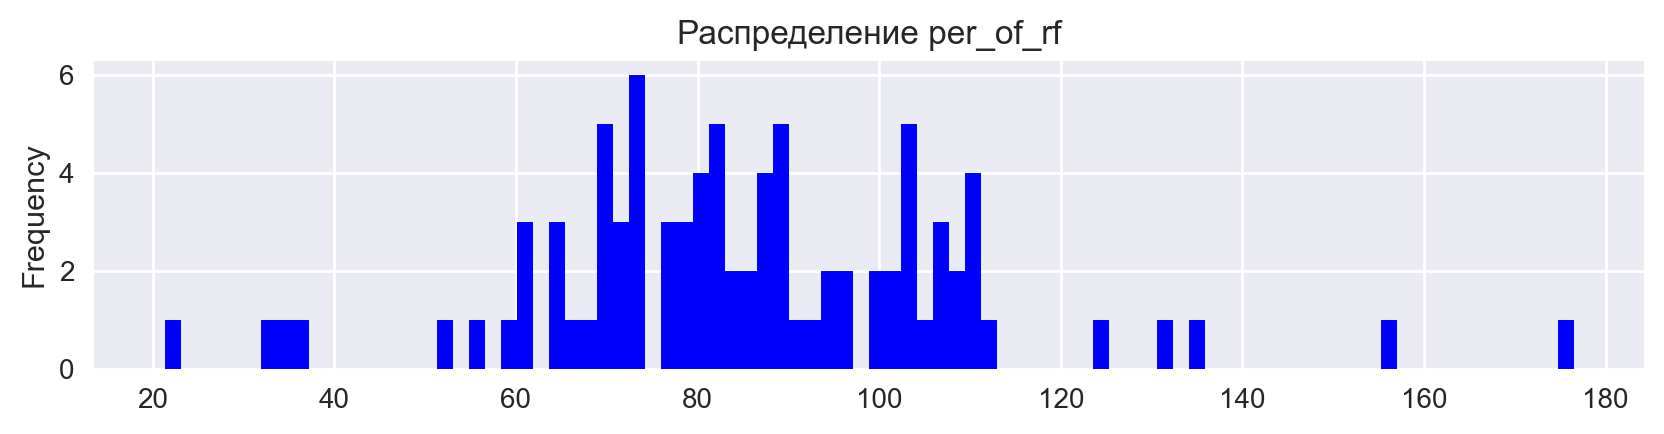

In [140]:
# выведем распределние признака per_of_rf в данных retail
feature_histogram(df=retail, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- уровень показателей ниже 50% от уровня РФ в целом

In [141]:
# отмечаем проблемные регионы
retail['bad_region'] = 0
retail.loc[:,'bad_region'] = retail.loc[:,'per_of_rf'].apply(lambda x: 1 if x < 50 else 0)
# выводим полученные даные
print(retail.name)
print("* 'ПЛОХИЕ' регионы *")
display(retail[retail['bad_region'] == 1])

retail - Оборот розничной торговли на душу населения, в рублях.
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
33,Республика Калмыкия,97566.0,1,36.05,1
41,Республика Ингушетия,57605.0,1,21.29,1
43,Карачаево-Черкесская Республика,95066.0,1,35.13,1
70,Республика Тыва,89480.0,1,33.07,1


Теперь подправим названия признаков, используя префикс.

In [142]:
# удалим признак тренда
retail.drop('trend', axis=1, inplace=True)
# правим названия признаков
data_features_rename(df=retail, prefix='retail')

retail - Оборот розничной торговли на душу населения, в рублях.
Размерность данных: (88, 4)


,region,retail,retail_per_of_rf,retail_bad_region
0,РФ,270606.0,100.00,0
1,Белгородская область,259151.0,95.77,0
2,Брянская область,257679.0,95.22,0
3,Владимирская область,207670.0,76.74,0
4,Воронежская область,296665.0,109.63,0


***

### 1.13. Расходы на социальную политику

Данные представляют собой файл формата *.xlsx*, который содержит таблицу:
- **welfare_expense_share_2015_2020** - расходы на социальную политику от общих расходов бюджета региона, % в год

In [143]:
# загружаем данные 
welfare_expense = pd.read_excel('data_provided/welfare_expense_share_2015_2020.xlsx')

# зададим имя таблице 
welfare_expense.name = 'welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год'

# производим предварительную обработку данных и выводим их
welfare_expense = data_preparation_step_1(df=welfare_expense, region='region', replacement='')

*** Данные после первичной обработки ***
welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год


,region,2015,2016,2017,2018,2019,2020
0,РФ,15.8,16.6,20.4,20.3,19.8,21.3
1,Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1
2,Брянская область,22.0,26.6,24.7,23.7,20.7,23.1
3,Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0
4,Воронежская область,15.2,15.4,22.8,20.9,19.0,21.6


Размерность: (86, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


In [144]:
# уточним проблемные регионы
output_problem_regions(welfare_expense)

welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год


,region,2015,2016,2017,2018,2019,2020
21,Архангельская область,15.4,16.3,24.8,24.2,22.4,21.4
29,Ненецкий автономный округ,13.6,15.2,16.9,15.5,14.3,14.4
61,Тюменская область,12.8,18.5,19.8,18.7,20.6,21.9
63,Ханты-Мансийский автономный округ - Югра,11.5,12.7,16.5,17.0,15.6,15.8
64,Ямало-Ненецкий автономный округ,13.1,12.0,14.0,14.0,13.0,12.6


В таблице отсутствуют данные по Архангельской и Тюменской областям без учета округов. Внесем их отдельно, взяв показатели по РФ в целом. 

In [145]:
# данные по утеряным регионам
new_record = pd.DataFrame([
    {'region':'Архангельская область без Ненецкого АО', 2015:15.8, 2016:16.6, 2017:20.4, 2018:20.3, 2019:19.8, 2020:21.3},
    {'region':'Тюменская область без округов', 2015:15.8, 2016:16.6, 2017:20.4, 2018:20.3, 2019:19.8, 2020:21.3}
    ])
# добавим данные по утерянным регионам
welfare_expense = pd.concat([welfare_expense, new_record], axis=0, ignore_index=True)
# присвоим имя таблице
welfare_expense.name = 'welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год'

In [146]:
# производим второй этап обработки данных
welfare_expense = data_preparation_step_2(df=welfare_expense, bad_trend=-1, bad_per_of_rf='less', threshold_100=True)

*** Данные после второго этапа обработки ***
welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год


,region,2020,trend,per_of_rf
0,РФ,21.3,1,100.00
1,Белгородская область,16.1,1,75.59
2,Брянская область,23.1,-1,108.45
3,Владимирская область,26.0,1,122.07
4,Воронежская область,21.6,1,101.41


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2020,trend,per_of_rf
2,Брянская область,23.1,-1,108.45
5,Ивановская область,25.1,-1,117.84
6,Калужская область,16.9,-1,79.34
10,Московская область,19.4,-1,91.08
24,Ленинградская область,16.7,-1,78.40
29,Ненецкий автономный округ,14.4,-1,67.61
35,Волгоградская область,25.1,-1,117.84
38,Республика Дагестан,28.3,-1,132.86
50,Чувашская Республика,24.9,-1,116.90
54,Оренбургская область,26.6,-1,124.88


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 20 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2020,trend,per_of_rf
6,Калужская область,16.9,-1,79.34
10,Московская область,19.4,-1,91.08
24,Ленинградская область,16.7,-1,78.40
29,Ненецкий автономный округ,14.4,-1,67.61
85,Чукотский автономный округ,6.4,-1,30.05


Всего таких регионов: 5 *
----------------------------------------------------------------------------------------------------


welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год


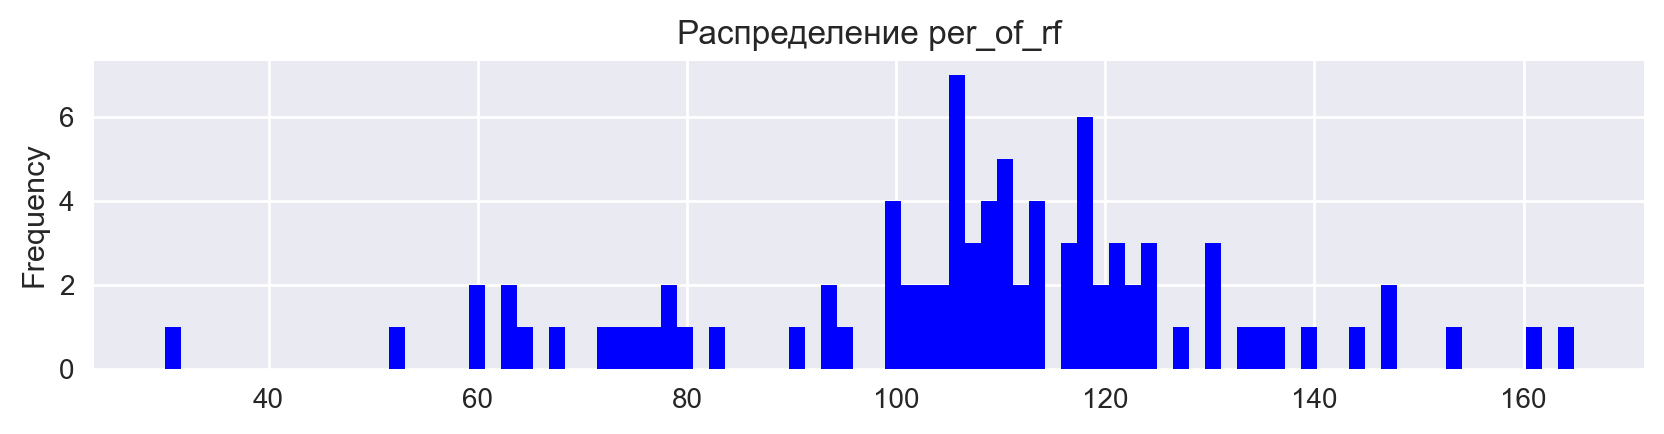

In [147]:
# выведем распределние признака per_of_rf в данных welfare_expense
feature_histogram(df=welfare_expense, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- отрицательный тренд + уровень показателя ниже уровня РФ в целом
- а также показатель региона ниже 90% от показателя РФ в целом

In [148]:
# отмечаем проблемные регионы
welfare_expense = data_preparation_step_3(welfare_expense, bad_trend=-1, bad_per_of_rf='less', and_threshold=100, add_threshold=90)

welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год
* 'ПЛОХИЕ' регионы *


,region,2020,trend,per_of_rf,bad_region
1,Белгородская область,16.1,1,75.59,1
6,Калужская область,16.9,-1,79.34,1
10,Московская область,19.4,-1,91.08,1
18,Москва,17.5,1,82.16,1
23,Калининградская область,12.6,1,59.15,1
24,Ленинградская область,16.7,-1,78.40,1
29,Ненецкий автономный округ,14.4,-1,67.61,1
32,Республика Крым,15.5,1,72.77,1
37,Севастополь,13.3,1,62.44,1
48,Республика Татарстан,13.7,1,64.32,1


* Всего 'ПЛОХИХ' регионов: 17 *
----------------------------------------------------------------------------------------------------


Наихудшие показатели в Чукотском автономном округе.

Теперь подправим названия признаков, используя префикс.

In [149]:
# правим названия признаков
data_features_rename(df=welfare_expense, prefix='welfare_expense')

welfare_expense - Расходы на социальную политику от общих расходов бюджета региона, % в год
Размерность данных: (88, 5)


,region,welfare_expense,welfare_expense_trend,welfare_expense_per_of_rf,welfare_expense_bad_region
0,РФ,21.3,1,100.00,0
1,Белгородская область,16.1,1,75.59,1
2,Брянская область,23.1,-1,108.45,0
3,Владимирская область,26.0,1,122.07,0
4,Воронежская область,21.6,1,101.41,0


***

### 1.14. Численность населения по возрастным группам

Это дополнительные данные Росстата ([источник](https://rosstat.gov.ru/compendium/document/13284)), представляющие собой файл *bulletin_2022.xlsx*,  бюллетень за 2022 год, содержащий различные данные о населении РФ. Нас интересует раздел 1.8.1.: ЧИСЛЕННОСТЬ НАСЕЛЕНИЯ ПО СУБЪЕКТАМ РОССИЙСКОЙ ФЕДЕРАЦИИ ПО ОСНОВНЫМ ВОЗРАСТНЫМ ГРУППАМ на 1 января 2022 г., а точнее "Удельный вес возрастных групп 
в общей численности населения, в процентах".

In [150]:
# загружаем данные 
population_group = pd.read_excel('data_provided/bulletin_2022.xlsx', sheet_name='1.8.1.', header=3, usecols='A,F:H')
population_group.rename(
    columns={
        'Unnamed: 0':'region', 
        'моложе\nтрудосп..1':'population_children', 
        'трудосп..1':'population_employable', 
        'старше\nтрудосп..1':'population_retired'}, 
    inplace=True)

# зададим имя таблице 
population_group.name = 'population_group - Удельный вес возрастных групп в общей численности населения, в %'

# производим предварительную обработку данных и выводим их
population_group = data_preparation_step_1(df=population_group, region='region', replacement='')

*** Данные после первичной обработки ***
population_group - Удельный вес возрастных групп в общей численности населения, в %


,region,population_children,population_employable,population_retired
0,РФ,18.8,57.2,24.0
1,Белгородская область,16.9,56.9,26.2
2,Брянская область,16.9,56.5,26.6
3,Владимирская область,16.5,55.8,27.7
4,Воронежская область,16.1,56.7,27.2


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


Ничего больше с данными делать не будем, просто добавим их в итоговую сводную таблицу.

***

### 1.15. Преступность

Представленые данные перегружены подробной информацией. На мой взгляд, нужно выделить основную информацию, которая будет помогать в оценке неблагополучного региона:
- выделить данные о преступлениях:
    - совершенных несовершенолетними либо при их соучастии
    - ранее совершавшими преступления
    - в состоянии опьянения (алкогольного + наркотического + токсического)
- выделить из этой выборки преступления особо тяжкие и тяжкие, суммировать их и высчитать в виде долей в % 

Для этого воспользуемся данными за декабрь 2016-2021 годов (необходимые нам данные там суммированы за год). 2022 год учитывать не будем, т.к. данные неполные (только за 6 месяцев).

Проведем небольшую разведку, касательно проблемных регионов.

In [151]:
data_0 = pd.read_excel('data_provided/crimes/4-EGS_Razdel_4_122016.xls', sheet_name=0, header=11, usecols='B:D,J:L')
mask_1 = (data_0['Unnamed: 1'] == 'Архангельская область') | (data_0['Unnamed: 1'] == 'Ненецкий автономный округ')
mask_2 = (data_0['Unnamed: 1'] == 'Тюменская область') | (data_0['Unnamed: 1'] == 'Ханты-Мансийский автономный округ - Югра') | (data_0['Unnamed: 1'] == 'Ямало-Ненецкий автономный округ')
data_0[mask_1 | mask_2]

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Unnamed: 1,1,2,8,9,10
21,Архангельская область,756,6847,5513,39,11
22,Ненецкий автономный округ,51,229,272,1,0
67,Тюменская область,677,8733,7186,667,1
68,Ханты-Мансийский автономный округ - Югра,556,7628,6187,457,6
69,Ямало-Ненецкий автономный округ,228,2480,2426,105,0


По данным Тюменской области становится понятно, что данные по Архангельской и Тюменской областям - это данные без округов.

Напишем функцию, для добавления пропущенных данных по проблемным округам.

In [152]:
def add_problem_regions(df):
    '''
    Функция принимает на вход датафрейм, переименовывает правильно округа, рассчитыввет
    недостающие данные по проблемным округам и добавляет рассчитанные данные в таблицу.
    '''
    
    # переименовываем правильно округа
    df.replace({'Архангельская область': 'Архангельская область без Ненецкого АО'}, inplace=True)
    df.replace({'Тюменская область': 'Тюменская область без округов'}, inplace=True)

    # рассчитываем данные для Архангельская области
    sum_1 =(df.iloc[21,1:] + df.iloc[22,1:]).to_list()
    sum_1.insert(0, 'Архангельская область')

    # рассчитываем данные для Тюменской области
    sum_2 =(df.iloc[67,1:] + df.iloc[68,1:] + df.iloc[69,1:]).to_list()
    sum_2.insert(0, 'Тюменская область')
    
    # добавляем данные в таблицу
    df.loc[len(df.index)] = sum_1
    df.loc[len(df.index)] = sum_2

Теперь выделим необходимые данные в общую таблицу:

In [153]:

%%capture --no-stdout 
# создадим исходный массив размерностью 105х1 заполненный нулями (по сути, первый столбец будущей итоговой таблицы)
data_result = [[0] * 1] * 105

# по очереди откроем каждый файл с данными за декабрь 2016-2021 годов 
for year in range(2016,2022):
    
    if year == 2021:
        file_name = 'data_provided/crimes/4-EGS_Razdel_5_12' + str(year) + '.xls'
    else:
        file_name = 'data_provided/crimes/4-EGS_Razdel_4_12' + str(year) + '.xls'
    
    # откроем в каждом файле страницы 0,1,2 (всего, особо тяжкие, тяжкие)
    for n in range(3):
        # страница 0 с общими данными (всего)
        if n == 0:
            # считываем данные из файла с данными за декабрь 
            data_0 = pd.read_excel(file_name, sheet_name=n, header=11, usecols='B:D,J:L')
            # сразу суммируем данные "в состоянии опьянения" (алкогольного + наркотического + токсического)
            data_0.loc[:,'drunk'] = data_0.iloc[:,-3] + data_0.iloc[:,-2] + data_0.iloc[:,-1]
            # добавляем данные для Архангельской и Тюменской областей
            add_problem_regions(data_0)
            # сохраним регионы для будущей итоговой таблицы
            regions = data_0.iloc[:,0]
            # переводим числовые данные таблицы в массив
            data_0_values = data_0.iloc[:,[1,2,6]].values
        # страница 1 (особо тяжкие)
        elif n == 1:
            # считываем данные из файла с данными за декабрь
            data_1 = pd.read_excel(file_name, sheet_name=n, header=11, usecols='B:D,J:L')
            # сразу суммируем данные "в состоянии опьянения" (алкогольного + наркотического + токсического)
            data_1.loc[:,'drunk'] = data_1.iloc[:,-3] + data_1.iloc[:,-2] + data_1.iloc[:,-1]
            # добавляем данные для Архангельской и Тюменской областей
            add_problem_regions(data_1)
            # переводим числовые данные таблицы в массив
            data_1_values = data_1.iloc[:,[1,2,6]].values
        # страница 2 (тяжкие)
        elif n == 2:
            # считываем данные из файла с данными за декабрь
            data_2 = pd.read_excel(file_name, sheet_name=n, header=11, usecols='B:D,J:L')
            # сразу суммируем данные "в состоянии опьянения" (алкогольного + наркотического + токсического)
            data_2.loc[:,'drunk'] = data_2.iloc[:,-3] + data_2.iloc[:,-2] + data_2.iloc[:,-1]
            # добавляем данные для Архангельской и Тюменской областей
            add_problem_regions(data_2)
            # переводим числовые данные таблицы в массив
            data_2_values = data_2.iloc[:,[1,2,6]].values

            # расчитываем долю (особо тяжких + тяжких преступлений) от общего (всего)
            proportion = np.round((data_1_values + data_2_values) / data_0_values * 100, 0)
            # добавляем полученные данные в итоговый массив
            data_result = np.concatenate((data_result, proportion), axis=1)

# создадим из итогового массива итоговую таблицу
df_result = pd.DataFrame(data=data_result)
# заменим нули в первом столбце названиями регионов
df_result[0] = regions

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector s

In [154]:
# выведем полученную итговую таблицу по преступлениям
df_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Российская Федерация,21.0,20.0,17.0,23.0,19.0,17.0,22.0,19.0,17.0,24.0,19.0,17.0,26.0,19.0,17.0,28.0,20.0,18.0
1,Центральный федеральный округ,24.0,23.0,20.0,23.0,22.0,20.0,24.0,21.0,19.0,25.0,21.0,20.0,26.0,21.0,19.0,31.0,21.0,20.0
2,Белгородская область,22.0,17.0,12.0,16.0,14.0,12.0,18.0,14.0,13.0,19.0,15.0,14.0,28.0,16.0,12.0,27.0,17.0,17.0
3,Брянская область,25.0,18.0,14.0,24.0,18.0,14.0,23.0,17.0,14.0,26.0,15.0,13.0,28.0,14.0,12.0,34.0,16.0,12.0
4,Владимирская область,24.0,26.0,20.0,21.0,23.0,21.0,23.0,20.0,18.0,22.0,22.0,19.0,26.0,21.0,20.0,25.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,УТ МВД по Северо-Западному ФО,30.0,26.0,33.0,33.0,27.0,27.0,50.0,24.0,14.0,0.0,23.0,5.0,67.0,21.0,11.0,38.0,16.0,12.0
101,УТ МВД по Дальневосточному ФО,7.0,25.0,25.0,25.0,27.0,26.0,20.0,26.0,9.0,0.0,23.0,12.0,0.0,24.0,11.0,67.0,20.0,14.0
102,УТ МВД по Северо-Кавказскому ФО,11.0,16.0,30.0,NaN,19.0,29.0,0.0,20.0,36.0,0.0,20.0,36.0,NaN,19.0,23.0,NaN,20.0,43.0
103,Архангельская область,23.0,20.0,16.0,18.0,21.0,20.0,16.0,19.0,18.0,24.0,19.0,21.0,25.0,20.0,22.0,30.0,21.0,25.0


Теперь создадим необходимые нам таблицы из итоговой:

In [155]:
columns_names = ['region', '2016','2017','2018','2019','2020', '2021']

# Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений в этой же группе
children_serious_crimes = df_result.loc[:,[0,1,4,7,10,13,16]]
children_serious_crimes = children_serious_crimes.set_axis(columns_names, axis=1)
children_serious_crimes.name = 'children_serious_crimes\nДоля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений'

# Доля особо тяжких и тяжких преступлении совершенных "ранее совершавшими преступления" в % от всех преступлений в этой же группе
repeat_serious_crimes = df_result.loc[:,[0,2,5,8,11,14,17]]
repeat_serious_crimes = repeat_serious_crimes.set_axis(columns_names, axis=1)
repeat_serious_crimes.name = 'repeat_serious_crimes\nДоля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений'

# Доля особо тяжких и тяжких преступлении совершенных "в состоянии опьянения" в % от всех преступлений в этой же группе
drunk_serious_crimes = df_result.loc[:,[0,3,6,9,12,15,18]]
drunk_serious_crimes = drunk_serious_crimes.set_axis(columns_names, axis=1)
drunk_serious_crimes.name = 'drunk_serious_crimes\nДоля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений'

#### 1.15.1. Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений в этой группе

In [156]:
# первый этап обработки
children_serious_crimes = data_preparation_step_1(df=children_serious_crimes, region='region', replacement='без')

*** Данные после первичной обработки ***
children_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений


,region,2016,2017,2018,2019,2020,2021
0,РФ,21.0,23.0,22.0,24.0,26.0,28.0
1,Белгородская область,22.0,16.0,18.0,19.0,28.0,27.0
2,Брянская область,25.0,24.0,23.0,26.0,28.0,34.0
3,Владимирская область,24.0,21.0,23.0,22.0,26.0,25.0
4,Воронежская область,22.0,22.0,24.0,21.0,28.0,35.0


Размерность: (88, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


В целом по РФ мы видим рост подобных преступлений.

In [157]:
# производим второй этап обработки данных
children_serious_crimes = data_preparation_step_2(df=children_serious_crimes, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
children_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений


,region,2021,trend,per_of_rf
0,РФ,28.0,1,100.00
1,Белгородская область,27.0,1,96.43
2,Брянская область,34.0,1,121.43
3,Владимирская область,25.0,1,89.29
4,Воронежская область,35.0,1,125.00


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
0,РФ,28.0,1,100.00
1,Белгородская область,27.0,1,96.43
2,Брянская область,34.0,1,121.43
3,Владимирская область,25.0,1,89.29
4,Воронежская область,35.0,1,125.00
...,...,...,...,...
82,Республика Саха (Якутия),30.0,1,107.14
83,Сахалинская область,31.0,1,110.71
84,Хабаровский край,28.0,1,100.00
86,Архангельская область,30.0,1,107.14


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 46 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
2,Брянская область,34.0,1,121.43
4,Воронежская область,35.0,1,125.00
6,Калужская область,31.0,1,110.71
7,Костромская область,31.0,1,110.71
8,Курская область,33.0,1,117.86
9,Москва,43.0,1,153.57
10,Московская область,32.0,1,114.29
12,Орловская область,31.0,1,110.71
13,Рязанская область,44.0,1,157.14
16,Тверская область,35.0,1,125.00


Всего таких регионов: 39 *
----------------------------------------------------------------------------------------------------


Почти в половине регионов мы видим превышение показателя над показателем по РФ в целом и положительный тренд. Впечатляет...

children_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений


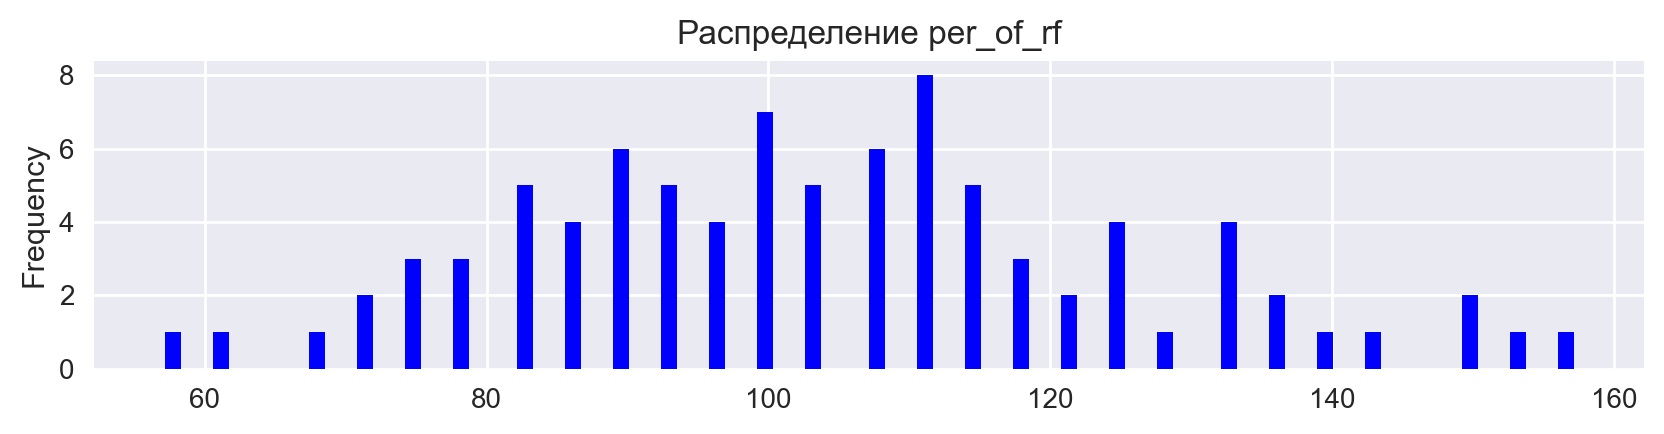

In [158]:
# выведем распределние признака per_of_rf в данных children_serious_crimes
feature_histogram(df=children_serious_crimes, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд + уровень показателя выше 120% от уровня РФ в целом
- а также показатель региона выше 130% от показателя РФ в целом

In [159]:
# отмечаем проблемные регионы
children_serious_crimes = data_preparation_step_3(children_serious_crimes, bad_trend=1, bad_per_of_rf='more', and_threshold=120, add_threshold=130)

children_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
2,Брянская область,34.0,1,121.43,1
4,Воронежская область,35.0,1,125.00,1
9,Москва,43.0,1,153.57,1
13,Рязанская область,44.0,1,157.14,1
16,Тверская область,35.0,1,125.00,1
32,Республика Дагестан,37.0,1,132.14,1
36,Чеченская Республика,40.0,1,142.86,1
37,Астраханская область,35.0,1,125.00,1
43,Республика Калмыкия,38.0,1,135.71,1
50,Республика Татарстан,37.0,1,132.14,1


* Всего 'ПЛОХИХ' регионов: 18 *
----------------------------------------------------------------------------------------------------


Самые худшие показатели - Рязанская область, Москва, Ямало-Ненецкий автономный округ, Республика Тыва. Получается, что при уровне превышающим 120% уровня РФ везде положительный тренд, т.е. ситуация ухудшается.

Теперь подправим названия признаков, используя префикс.

In [160]:
# правим названия признаков
data_features_rename(df=children_serious_crimes, prefix='children_serious_crimes')

children_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений
Размерность данных: (88, 5)


,region,children_serious_crimes,children_serious_crimes_trend,children_serious_crimes_per_of_rf,children_serious_crimes_bad_region
0,РФ,28.0,1,100.00,0
1,Белгородская область,27.0,1,96.43,0
2,Брянская область,34.0,1,121.43,1
3,Владимирская область,25.0,1,89.29,0
4,Воронежская область,35.0,1,125.00,1


#### 1.15.2. Доля особо тяжких и тяжких преступлений совершенных ранее совершавшими преступления в % от всех преступлений

In [161]:
# первый этап обработки
repeat_serious_crimes = data_preparation_step_1(df=repeat_serious_crimes, region='region', replacement='без')

*** Данные после первичной обработки ***
repeat_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений


,region,2016,2017,2018,2019,2020,2021
0,РФ,20.0,19.0,19.0,19.0,19.0,20.0
1,Белгородская область,17.0,14.0,14.0,15.0,16.0,17.0
2,Брянская область,18.0,18.0,17.0,15.0,14.0,16.0
3,Владимирская область,26.0,23.0,20.0,22.0,21.0,20.0
4,Воронежская область,20.0,19.0,18.0,19.0,18.0,20.0


Размерность: (88, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


В целом по РФ доля таких преступлений не меняется.

In [162]:
# производим второй этап обработки данных
repeat_serious_crimes = data_preparation_step_2(df=repeat_serious_crimes, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
repeat_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений


,region,2021,trend,per_of_rf
0,РФ,20.0,1,100.0
1,Белгородская область,17.0,1,85.0
2,Брянская область,16.0,-1,80.0
3,Владимирская область,20.0,-1,100.0
4,Воронежская область,20.0,1,100.0


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
0,РФ,20.0,1,100.0
1,Белгородская область,17.0,1,85.0
4,Воронежская область,20.0,1,100.0
6,Калужская область,22.0,1,110.0
8,Курская область,16.0,1,80.0
12,Орловская область,18.0,1,90.0
14,Смоленская область,20.0,1,100.0
20,Ненецкий автономный округ,23.0,1,115.0
21,Санкт-Петербург,32.0,1,160.0
22,Ленинградская область,28.0,1,140.0


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 37 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
6,Калужская область,22.0,1,110.0
20,Ненецкий автономный округ,23.0,1,115.0
21,Санкт-Петербург,32.0,1,160.0
22,Ленинградская область,28.0,1,140.0
26,Новгородская область,24.0,1,120.0
27,Псковская область,28.0,1,140.0
29,Республика Коми,21.0,1,105.0
36,Чеченская Республика,25.0,1,125.0
43,Республика Калмыкия,21.0,1,105.0
49,Пермский край,21.0,1,105.0


Всего таких регионов: 27 *
----------------------------------------------------------------------------------------------------


repeat_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений


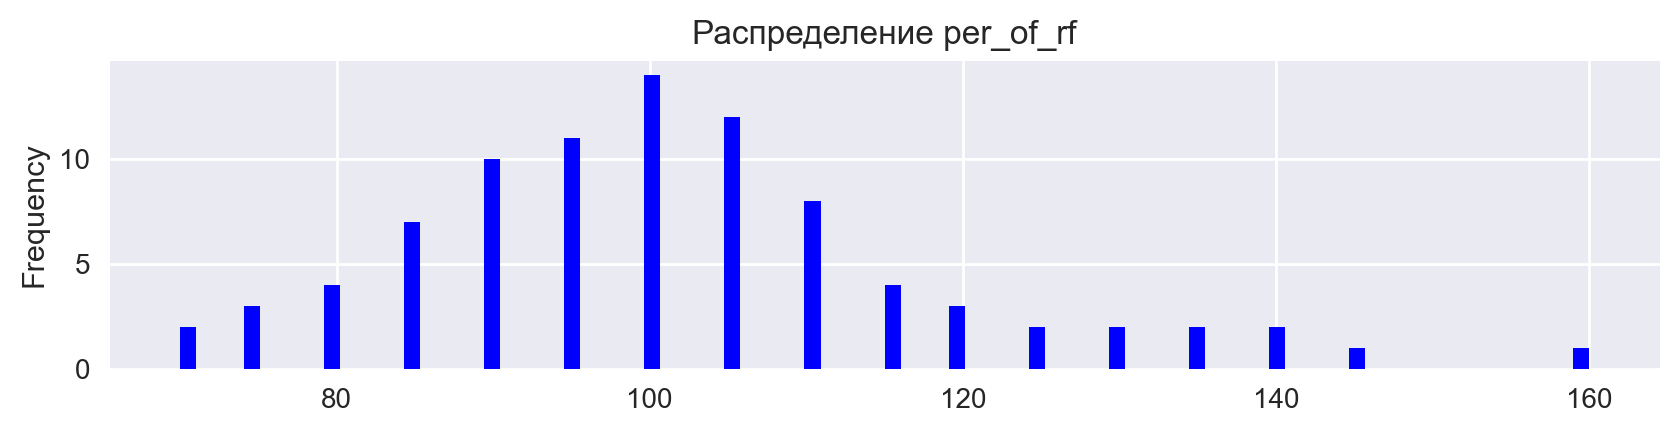

In [163]:
# выведем распределние признака per_of_rf в данных repeat_serious_crimes
feature_histogram(df=repeat_serious_crimes, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд + уровень показателя выше 120% от уровня РФ в целом
- а также показатель региона выше 120% от показателя РФ в целом

In [164]:
# отмечаем проблемные регионы
repeat_serious_crimes = data_preparation_step_3(repeat_serious_crimes, bad_trend=1, bad_per_of_rf='more', and_threshold=120, add_threshold=120)

repeat_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
9,Москва,29.0,-1,145.0,1
21,Санкт-Петербург,32.0,1,160.0,1
22,Ленинградская область,28.0,1,140.0,1
27,Псковская область,28.0,1,140.0,1
36,Чеченская Республика,25.0,1,125.0,1
56,Удмуртская Республика,25.0,1,125.0,1
72,Республика Тыва,27.0,1,135.0,1
76,Еврейская автономная область,26.0,1,130.0,1
79,Магаданская область,27.0,1,135.0,1
85,Чукотский автономный округ,26.0,1,130.0,1


* Всего 'ПЛОХИХ' регионов: 10 *
----------------------------------------------------------------------------------------------------


Наихудшая ситуация по данному показателю в Москве и Санкт-Петербурге, но если в Москве тренд на снижение, то в Санкт-Петербурге наоборот. При анализе данного показателя Санкт-Петербург оправдыввет свой титул "криминальной столицы".

Теперь подправим названия признаков, используя префикс.

In [165]:
# правим названия признаков
data_features_rename(df=repeat_serious_crimes, prefix='repeat_serious_crimes')

repeat_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений
Размерность данных: (88, 5)


,region,repeat_serious_crimes,repeat_serious_crimes_trend,repeat_serious_crimes_per_of_rf,repeat_serious_crimes_bad_region
0,РФ,20.0,1,100.0,0
1,Белгородская область,17.0,1,85.0,0
2,Брянская область,16.0,-1,80.0,0
3,Владимирская область,20.0,-1,100.0,0
4,Воронежская область,20.0,1,100.0,0


#### 1.15.3. Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений

In [166]:
# первый этап обработки
drunk_serious_crimes = data_preparation_step_1(df=drunk_serious_crimes, region='region', replacement='без')

*** Данные после первичной обработки ***
drunk_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений


,region,2016,2017,2018,2019,2020,2021
0,РФ,17.0,17.0,17.0,17.0,17.0,18.0
1,Белгородская область,12.0,12.0,13.0,14.0,12.0,17.0
2,Брянская область,14.0,14.0,14.0,13.0,12.0,12.0
3,Владимирская область,20.0,21.0,18.0,19.0,20.0,20.0
4,Воронежская область,19.0,18.0,15.0,17.0,17.0,20.0


Размерность: (88, 7)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

----------------------------------------------------------------------------------------------------


Снова в целом по РФ существенной динамики нет.

In [167]:
# производим второй этап обработки данных
drunk_serious_crimes = data_preparation_step_2(df=drunk_serious_crimes, bad_trend=1, bad_per_of_rf='more', threshold_100=True)

*** Данные после второго этапа обработки ***
drunk_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений


,region,2021,trend,per_of_rf
0,РФ,18.0,1,100.00
1,Белгородская область,17.0,1,94.44
2,Брянская область,12.0,-1,66.67
3,Владимирская область,20.0,-1,111.11
4,Воронежская область,20.0,1,111.11


Размерность: (88, 4)
Количество строк, содержащих пропуски 0
Число найденных дубликатов: 0

* Данные с ПЛОХИМ трендом *


,region,2021,trend,per_of_rf
0,РФ,18.0,1,100.00
1,Белгородская область,17.0,1,94.44
4,Воронежская область,20.0,1,111.11
5,Ивановская область,18.0,1,100.00
6,Калужская область,23.0,1,127.78
7,Костромская область,16.0,1,88.89
8,Курская область,15.0,1,83.33
11,Липецкая область,15.0,1,83.33
13,Рязанская область,16.0,1,88.89
14,Смоленская область,17.0,1,94.44


* Количество регионов с ПЛОХИМИ показателями относительно уровня РФ: 37 *
* Данные с ПЛОХИМ трендом и ПЛОХИМИ показателями относительно уровня РФ:


,region,2021,trend,per_of_rf
4,Воронежская область,20.0,1,111.11
6,Калужская область,23.0,1,127.78
16,Тверская область,19.0,1,105.56
19,Архангельская область без Ненецкого АО,26.0,1,144.44
22,Ленинградская область,24.0,1,133.33
23,Вологодская область,21.0,1,116.67
25,Мурманская область,21.0,1,116.67
28,Республика Карелия,19.0,1,105.56
29,Республика Коми,20.0,1,111.11
49,Пермский край,20.0,1,111.11


Всего таких регионов: 26 *
----------------------------------------------------------------------------------------------------


drunk_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений


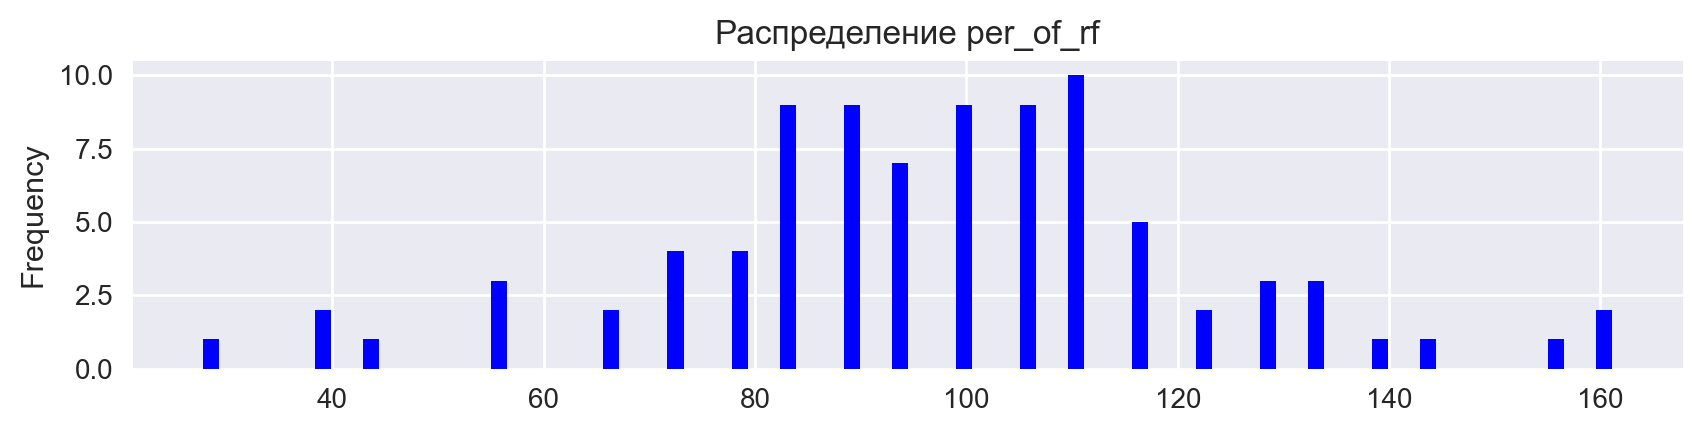

In [168]:
# выведем распределние признака per_of_rf в данных drunk_serious_crimes
feature_histogram(df=drunk_serious_crimes, feature='per_of_rf')

Теперь пометим ПЛОХИЕ регионы (признак *bad_region*).     
Критерии ПЛОХОГО региона:
- положительный тренд + уровень показателя выше 120% от уровня РФ в целом
- а также показатель региона выше 120% от показателя РФ в целом

In [169]:
# отмечаем проблемные регионы
drunk_serious_crimes = data_preparation_step_3(drunk_serious_crimes, bad_trend=1, bad_per_of_rf='more', and_threshold=120, add_threshold=120)

drunk_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений
* 'ПЛОХИЕ' регионы *


,region,2021,trend,per_of_rf,bad_region
6,Калужская область,23.0,1,127.78,1
9,Москва,29.0,0,161.11,1
18,Ярославская область,22.0,-1,122.22,1
19,Архангельская область без Ненецкого АО,26.0,1,144.44,1
21,Санкт-Петербург,28.0,-1,155.56,1
22,Ленинградская область,24.0,1,133.33,1
69,Новосибирская область,24.0,1,133.33,1
72,Республика Тыва,23.0,1,127.78,1
76,Еврейская автономная область,29.0,1,161.11,1
79,Магаданская область,24.0,1,133.33,1


* Всего 'ПЛОХИХ' регионов: 13 *
----------------------------------------------------------------------------------------------------


И снова Москва и Санкт-Петербург в лидерах, только хуже теперь выглядит Москва.

Теперь подправим названия признаков, используя префикс.

In [170]:
# правим названия признаков
data_features_rename(df=drunk_serious_crimes, prefix='drunk_serious_crimes')

drunk_serious_crimes
Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений
Размерность данных: (88, 5)


,region,drunk_serious_crimes,drunk_serious_crimes_trend,drunk_serious_crimes_per_of_rf,drunk_serious_crimes_bad_region
0,РФ,18.0,1,100.00,0
1,Белгородская область,17.0,1,94.44,0
2,Брянская область,12.0,-1,66.67,0
3,Владимирская область,20.0,-1,111.11,0
4,Воронежская область,20.0,1,111.11,0


***
***

## 2. Создание итоговой таблицы для кластеризации

In [171]:
# список со всеми таблицами (кроме таблицы population)
tables = [
    # Население
    # population,
    # Реальные денежные доходы, в процентах к предыдущему году
    real_incomes,
    # Реальная начисленная заработная плата, в процентах к предыдущему году
    real_pay,
    # Доля населения, имеющего среднедушевые денежные доходы ниже 40% среднедушевого денежного дохода населения за период 2013-2022
    poor,
    # Число умерших на первом году жизни детей за год на 100k насления (за год)
    child_mortality_100k,
    # Число людей с инвалидностью по регионам на 100k населения (трудоспособный возраст)
    disabled_100k,
    # Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения
    alco,
    # Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)
    drug,
    # Валовой региональный продукт на душу населения (рубль, значение показателя за год)
    grp,
    # % домохозяйств, указавших, что при проживании испытывают большую стесненность
    constraint,
    # Размер жилой площади в расчете на члена домохозяйства
    living_area,
    # % домохозяйств с плохим или очень плохим состояним жилого помещения + стесненность проживания
    very_bad_living_area,
    # Общая заболеваемость
    general_morbidity,
    # Врожденные пороки развития
    congenital_malformation,
    # Психические расстройства и расстройства поведения
    psychosis,
    # Подростковая беременность (до 14 лет)
    teenage_pregnancy,
    # Отдельные состояния, возникающие в перинатальном периоде (до 14 лет)
    conditions_in_perinatal,
    # Количество новорожденных на 100k населения
    newborn_100k,
    # Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)
    poverty_percent,
    # Малоимущее население (дети) в процентах
    poverty_socdem_children,
    # Малоимущее население (пенсионеры) в процентах
    poverty_socdem_retired,
    # Малоимущее население (трудоспособное) в процентах
    poverty_socdem_employable,
    # Добыча полезных ископаемых за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    mining,
    # Обрабатывающие производства за 2005–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    manufacturing,
    # Обеспечение электроэнергией, газом, паром; кондиционирование воздуха за 2017–2020 гг.
    # (в тысячах рублей, значение показателя за год, полный круг)
    electricity,
    # Водоснабжение; водоотведение, организация сбора и утилизация отходов, деятельность по ликвидации
    #  загрязнений за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    water_supply,
    # Промышленное производство за 2017–2020 гг.(в тысячах рублей, значение показателя за год, полный круг)
    industrial_production,
    # Оборот розничной торговли на душу населения, в рублях.
    retail,
    # Расходы на социальную политику от общих расходов бюджета региона, % в год
    welfare_expense,
    # Удельный вес возрастных групп в общей численности населения, в %
    population_group,
    # Доля особо тяжких и тяжких преступлении совершенных несовершенолетними в % от всех преступлений
    children_serious_crimes,
    # Доля особо тяжких и тяжких преступлении совершенных ранее совершавшими преступления в % от всех преступлений
    repeat_serious_crimes,
    # Доля особо тяжких и тяжких преступлении совершенных в состоянии опьянения в % от всех преступлений
    drunk_serious_crimes
]

In [172]:
# к таблице population будем присоединять все оставшиеся таблицы (сортируем регионы таблицы)
data_final = population.sort_values(by = "region").reset_index().drop('index', axis=1)

for table in tables:
    # сортируем регионы таблицы
    table = table.sort_values(by = "region").reset_index().drop('index', axis=1)
    # проверка идентичности регионов соединяемых таблиц
    if data_final['region'].equals(table['region']):
        data_final = pd.concat([data_final, table.iloc[:,1:]], axis=1)
    else:
        print (f'Нарушены порядок и/или названия регионов в таблице')

print(f'Размерность {data_final.shape}')
display(data_final.head())

Размерность (88, 126)


,region,population,population_trend,population_per_of_rf,population_bad_region,real_incomes,real_incomes_trend,real_incomes_per_of_rf,real_incomes_bad_region,real_pay,...,children_serious_crimes_per_of_rf,children_serious_crimes_bad_region,repeat_serious_crimes,repeat_serious_crimes_trend,repeat_serious_crimes_per_of_rf,repeat_serious_crimes_bad_region,drunk_serious_crimes,drunk_serious_crimes_trend,drunk_serious_crimes_per_of_rf,drunk_serious_crimes_bad_region
0,Алтайский край,2268179.0,-1,1.56,1,95.5,1,96.86,1,103.8,...,92.86,0,18.0,1,90.0,0,14.0,1,77.78,0
1,Амурская область,772525.0,-1,0.53,1,100.3,1,101.72,0,105.2,...,132.14,1,24.0,1,120.0,0,18.0,1,100.00,0
2,Архангельская область,1114322.0,-1,0.77,1,98.6,1,100.00,0,102.8,...,107.14,0,21.0,0,105.0,0,25.0,1,138.89,1
3,Архангельская область без Ненецкого АО,1069782.0,-1,0.73,1,98.4,1,99.80,0,102.9,...,107.14,0,21.0,0,105.0,0,26.0,1,144.44,1
4,Астраханская область,989430.0,-1,0.68,1,97.1,1,98.48,0,104.5,...,125.00,1,20.0,1,100.0,0,10.0,-1,55.56,0


В регионах Архангельская и Тюменская области много пропусков, да и они нам не нужны, т.к. у нас есть отдельные данные по этим регионам без округов и данные по их округам. Кроме того, данные по РФ нам уже не нужны - удалим их.

In [173]:
# удалим ненужные данные
data_final = data_final.loc[data_final['region'] != 'Архангельская область']
data_final = data_final.loc[data_final['region'] != 'Тюменская область']
data_final = data_final.loc[data_final['region'] != 'РФ']

print(f'Размерность {data_final.shape}')
display(data_final.head())

Размерность (85, 126)


,region,population,population_trend,population_per_of_rf,population_bad_region,real_incomes,real_incomes_trend,real_incomes_per_of_rf,real_incomes_bad_region,real_pay,...,children_serious_crimes_per_of_rf,children_serious_crimes_bad_region,repeat_serious_crimes,repeat_serious_crimes_trend,repeat_serious_crimes_per_of_rf,repeat_serious_crimes_bad_region,drunk_serious_crimes,drunk_serious_crimes_trend,drunk_serious_crimes_per_of_rf,drunk_serious_crimes_bad_region
0,Алтайский край,2268179.0,-1,1.56,1,95.5,1,96.86,1,103.8,...,92.86,0,18.0,1,90.0,0,14.0,1,77.78,0
1,Амурская область,772525.0,-1,0.53,1,100.3,1,101.72,0,105.2,...,132.14,1,24.0,1,120.0,0,18.0,1,100.00,0
3,Архангельская область без Ненецкого АО,1069782.0,-1,0.73,1,98.4,1,99.80,0,102.9,...,107.14,0,21.0,0,105.0,0,26.0,1,144.44,1
4,Астраханская область,989430.0,-1,0.68,1,97.1,1,98.48,0,104.5,...,125.00,1,20.0,1,100.0,0,10.0,-1,55.56,0
5,Белгородская область,1531917.0,1,1.05,0,98.1,-1,99.49,1,104.8,...,96.43,0,17.0,1,85.0,0,17.0,1,94.44,0


Проверим наличие пропусков:

In [174]:
# выводим строки, содержащие пропуски в данных
print('Строки содержащие пропуски:')
display(data_final[data_final.isna().any(axis=1)])
# выводим признаки, содержащие пропуски в данных
print('Признаки содержащие пропуски:')
columns = data_final.isnull().any()
print(columns.index[columns == True].to_list())
# всего пропусков в таблице
print(f'Всего пропусков: {data_final.isna().sum().sum()}')

Строки содержащие пропуски:


,region,population,population_trend,population_per_of_rf,population_bad_region,real_incomes,real_incomes_trend,real_incomes_per_of_rf,real_incomes_bad_region,real_pay,...,children_serious_crimes_per_of_rf,children_serious_crimes_bad_region,repeat_serious_crimes,repeat_serious_crimes_trend,repeat_serious_crimes_per_of_rf,repeat_serious_crimes_bad_region,drunk_serious_crimes,drunk_serious_crimes_trend,drunk_serious_crimes_per_of_rf,drunk_serious_crimes_bad_region


Признаки содержащие пропуски:
[]
Всего пропусков: 0


Сохраним итоговую таблицу.

In [175]:
data_final.to_csv('data_output/data_final.csv', index=False)